1. Load data and model

In [1]:
import torch

if torch.cuda.is_available():
    print("GPU is available!")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available. Check your setup.")


GPU is available!
Using GPU: NVIDIA GeForce RTX 4080 Laptop GPU


In [2]:
# Import required libraries
import os
from datasets import Dataset

# Function to read IOB files and split into paragraphs
def read_iob_file(file_path):
    """Read IOB file and convert to token-label samples"""
    examples = []
    words, labels = [], []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                token, label = line.split("\t")
                words.append(token)
                labels.append(label.strip())
            else:
                # End of a sample
                if words and labels:
                    examples.append({"tokens": words, "labels": labels})
                    words, labels = [], []
    # Add the last example if file doesn't end with a blank line
    if words and labels:
        examples.append({"tokens": words, "labels": labels})
    return examples



c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load datasets using the updated function
train_path = 'C:\\S24-25\\TxM\\dataset\\train.tsv'
val_path = 'C:\\S24-25\\TxM\\dataset\\val_gold.tsv'
test_path = 'C:\\S24-25\\TxM\\dataset\\test_gold.tsv'
train_data = read_iob_file(train_path)
val_data = read_iob_file(val_path)
test_data = read_iob_file(test_path)

print(f"Train samples: {len(train_data)}, Val samples: {len(val_data)}, Test samples: {len(test_data)}")


Train samples: 998, Val samples: 124, Test samples: 126


Tokenize and Align Labels

In [4]:
from transformers import AutoTokenizer
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# Define label mappings
label_list = ["O", "B-ADR", "I-ADR", "B-DRU", "I-DRU", "B-DIS", "I-DIS", "B-SYM", "I-SYM"]
label_to_id = {label: i for i, label in enumerate(label_list)}
id_to_label = {i: label for label, i in label_to_id.items()}

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True, padding=True
    )
    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(-100)  # Ignore padding
            elif word_idx != previous_word_idx:
                aligned_labels.append(label_to_id[label[word_idx]])
            else:
                aligned_labels.append(label_to_id[label[word_idx]])
            previous_word_idx = word_idx
        labels.append(aligned_labels)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Tokenize datasets
train_dataset = Dataset.from_list(train_data).map(tokenize_and_align_labels, batched=True)
test_dataset = Dataset.from_list(test_data).map(tokenize_and_align_labels, batched=True)
val_dataset = Dataset.from_list(val_data).map(tokenize_and_align_labels, batched=True)


Map: 100%|██████████| 124/124 [00:00<00:00, 2635.99 examples/s]


In [5]:
from transformers import AutoModelForTokenClassification


# Load the pre-trained BERT model

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id_to_label,
    label2id=label_to_id
)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2. Train and evaluate with default parameters on the test set

In [6]:
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=10,
)


In [7]:
from transformers import Trainer
from evaluate import load
import torch

# Load metric for evaluation
metric = load("seqeval")

def compute_metrics(predictions):
    predictions, labels = predictions
    predictions = torch.argmax(torch.tensor(predictions), dim=2)
    
    # Convert predictions and labels to CPU and then to plain Python integers
    predictions = predictions.cpu().numpy()
    
    true_labels = [
        [id_to_label[label] for label in label_seq if label != -100] 
        for label_seq in labels
    ]
    true_predictions = [
        [id_to_label[int(p)] for (p, l) in zip(prediction, label_seq) if l != -100]  # Convert tensor to int
        for prediction, label_seq in zip(predictions, labels)
    ]
    return metric.compute(predictions=true_predictions, references=true_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()



  5%|▌         | 10/189 [00:04<01:09,  2.59it/s]

{'loss': 1.2417, 'grad_norm': 1.3428797721862793, 'learning_rate': 1.8941798941798943e-05, 'epoch': 0.16}


 11%|█         | 20/189 [00:08<01:04,  2.60it/s]

{'loss': 0.5574, 'grad_norm': 1.0257930755615234, 'learning_rate': 1.7883597883597884e-05, 'epoch': 0.32}


 16%|█▌        | 30/189 [00:11<01:01,  2.59it/s]

{'loss': 0.4797, 'grad_norm': 1.1447668075561523, 'learning_rate': 1.6825396825396828e-05, 'epoch': 0.48}


 21%|██        | 40/189 [00:15<00:56,  2.66it/s]

{'loss': 0.3578, 'grad_norm': 0.6682282090187073, 'learning_rate': 1.576719576719577e-05, 'epoch': 0.63}


 26%|██▋       | 50/189 [00:19<00:52,  2.65it/s]

{'loss': 0.3844, 'grad_norm': 0.9573675394058228, 'learning_rate': 1.470899470899471e-05, 'epoch': 0.79}


 32%|███▏      | 60/189 [00:23<00:48,  2.65it/s]

{'loss': 0.3405, 'grad_norm': 0.8823774456977844, 'learning_rate': 1.3650793650793652e-05, 'epoch': 0.95}


 33%|███▎      | 63/189 [00:24<00:39,  3.22it/s]c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
 33%|███▎      | 63/189 [00:25<00:39,  3.22it/s]

{'eval_loss': 0.31397414207458496, 'eval_ADR': {'precision': 0.29748603351955305, 'recall': 0.32030075187969925, 'f1': 0.3084721216509776, 'number': 665}, 'eval_DIS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 58}, 'eval_DRU': {'precision': 0.6787330316742082, 'recall': 0.75, 'f1': 0.7125890736342042, 'number': 400}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 50}, 'eval_overall_precision': 0.4430051813471503, 'eval_overall_recall': 0.4373401534526854, 'eval_overall_f1': 0.44015444015444016, 'eval_overall_accuracy': 0.8963382507903056, 'eval_runtime': 1.1277, 'eval_samples_per_second': 111.727, 'eval_steps_per_second': 7.094, 'epoch': 1.0}


 37%|███▋      | 70/189 [00:29<00:53,  2.21it/s]

{'loss': 0.272, 'grad_norm': 0.6809940934181213, 'learning_rate': 1.2592592592592593e-05, 'epoch': 1.11}


 42%|████▏     | 80/189 [00:32<00:41,  2.62it/s]

{'loss': 0.2825, 'grad_norm': 0.9899711012840271, 'learning_rate': 1.1534391534391536e-05, 'epoch': 1.27}


 48%|████▊     | 90/189 [00:36<00:38,  2.57it/s]

{'loss': 0.2913, 'grad_norm': 1.50929856300354, 'learning_rate': 1.0476190476190477e-05, 'epoch': 1.43}


 53%|█████▎    | 100/189 [00:40<00:33,  2.65it/s]

{'loss': 0.274, 'grad_norm': 0.797164797782898, 'learning_rate': 9.417989417989418e-06, 'epoch': 1.59}


 58%|█████▊    | 110/189 [00:44<00:29,  2.65it/s]

{'loss': 0.2663, 'grad_norm': 0.9314042329788208, 'learning_rate': 8.35978835978836e-06, 'epoch': 1.75}


 63%|██████▎   | 120/189 [00:48<00:26,  2.63it/s]

{'loss': 0.252, 'grad_norm': 1.4016108512878418, 'learning_rate': 7.301587301587301e-06, 'epoch': 1.9}


 67%|██████▋   | 126/189 [00:50<00:19,  3.22it/s]c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 67%|██████▋   | 126/189 [00:51<00:19,  3.22it/s]

{'eval_loss': 0.26733699440956116, 'eval_ADR': {'precision': 0.3859857482185273, 'recall': 0.48872180451127817, 'f1': 0.43132050431320507, 'number': 665}, 'eval_DIS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 58}, 'eval_DRU': {'precision': 0.7607758620689655, 'recall': 0.8825, 'f1': 0.8171296296296295, 'number': 400}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 50}, 'eval_overall_precision': 0.5191424196018377, 'eval_overall_recall': 0.578005115089514, 'eval_overall_f1': 0.5469947559499798, 'eval_overall_accuracy': 0.9149104320337197, 'eval_runtime': 1.1342, 'eval_samples_per_second': 111.088, 'eval_steps_per_second': 7.053, 'epoch': 2.0}


 69%|██████▉   | 130/189 [00:53<00:35,  1.68it/s]

{'loss': 0.2242, 'grad_norm': 1.6912181377410889, 'learning_rate': 6.243386243386243e-06, 'epoch': 2.06}


 74%|███████▍  | 140/189 [00:57<00:18,  2.58it/s]

{'loss': 0.2159, 'grad_norm': 1.5596275329589844, 'learning_rate': 5.185185185185185e-06, 'epoch': 2.22}


 79%|███████▉  | 150/189 [01:01<00:15,  2.59it/s]

{'loss': 0.2238, 'grad_norm': 1.2799149751663208, 'learning_rate': 4.126984126984127e-06, 'epoch': 2.38}


 85%|████████▍ | 160/189 [01:05<00:10,  2.64it/s]

{'loss': 0.2215, 'grad_norm': 1.266120433807373, 'learning_rate': 3.068783068783069e-06, 'epoch': 2.54}


 90%|████████▉ | 170/189 [01:09<00:07,  2.65it/s]

{'loss': 0.1933, 'grad_norm': 1.7871856689453125, 'learning_rate': 2.0105820105820108e-06, 'epoch': 2.7}


 95%|█████████▌| 180/189 [01:12<00:03,  2.64it/s]

{'loss': 0.2273, 'grad_norm': 1.1185784339904785, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


100%|██████████| 189/189 [01:16<00:00,  3.22it/s]c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
100%|██████████| 189/189 [01:18<00:00,  3.22it/s]

{'eval_loss': 0.2582293152809143, 'eval_ADR': {'precision': 0.4167709637046308, 'recall': 0.5007518796992482, 'f1': 0.4549180327868853, 'number': 665}, 'eval_DIS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 58}, 'eval_DRU': {'precision': 0.8147268408551069, 'recall': 0.8575, 'f1': 0.8355663824604141, 'number': 400}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 50}, 'eval_overall_precision': 0.5540983606557377, 'eval_overall_recall': 0.5763000852514919, 'eval_overall_f1': 0.5649811951525282, 'eval_overall_accuracy': 0.9183350895679663, 'eval_runtime': 1.108, 'eval_samples_per_second': 113.714, 'eval_steps_per_second': 7.22, 'epoch': 3.0}


100%|██████████| 189/189 [01:19<00:00,  2.37it/s]

{'train_runtime': 79.6871, 'train_samples_per_second': 37.572, 'train_steps_per_second': 2.372, 'train_loss': 0.3441286396097254, 'epoch': 3.0}


TrainOutput(global_step=189, training_loss=0.3441286396097254, metrics={'train_runtime': 79.6871, 'train_samples_per_second': 37.572, 'train_steps_per_second': 2.372, 'total_flos': 782372000176128.0, 'train_loss': 0.3441286396097254, 'epoch': 3.0})

In [8]:
# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)


 88%|████████▊ | 7/8 [00:00<00:00,  8.89it/s]c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 8/8 [00:00<00:00,  8.12it/s]

Evaluation Results: {'eval_loss': 0.2582293152809143, 'eval_ADR': {'precision': 0.4167709637046308, 'recall': 0.5007518796992482, 'f1': 0.4549180327868853, 'number': 665}, 'eval_DIS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 58}, 'eval_DRU': {'precision': 0.8147268408551069, 'recall': 0.8575, 'f1': 0.8355663824604141, 'number': 400}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 50}, 'eval_overall_precision': 0.5540983606557377, 'eval_overall_recall': 0.5763000852514919, 'eval_overall_f1': 0.5649811951525282, 'eval_overall_accuracy': 0.9183350895679663, 'eval_runtime': 1.12, 'eval_samples_per_second': 112.501, 'eval_steps_per_second': 7.143, 'epoch': 3.0}


3. Train and test on val set

In [9]:
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=10,
)
from transformers import Trainer
from evaluate import load
import torch

# Load metric for evaluation
metric = load("seqeval")

def compute_metrics(predictions):
    predictions, labels = predictions
    predictions = torch.argmax(torch.tensor(predictions), dim=2)
    
    # Convert predictions and labels to CPU and then to plain Python integers
    predictions = predictions.cpu().numpy()
    
    true_labels = [
        [id_to_label[label] for label in label_seq if label != -100] 
        for label_seq in labels
    ]
    true_predictions = [
        [id_to_label[int(p)] for (p, l) in zip(prediction, label_seq) if l != -100]  # Convert tensor to int
        for prediction, label_seq in zip(predictions, labels)
    ]
    return metric.compute(predictions=true_predictions, references=true_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)


  5%|▌         | 10/189 [00:03<01:10,  2.54it/s]

{'loss': 0.2475, 'grad_norm': 6.022059440612793, 'learning_rate': 1.8941798941798943e-05, 'epoch': 0.16}


 11%|█         | 20/189 [00:07<01:04,  2.60it/s]

{'loss': 0.2204, 'grad_norm': 1.041131615638733, 'learning_rate': 1.7883597883597884e-05, 'epoch': 0.32}


 16%|█▌        | 30/189 [00:11<01:00,  2.65it/s]

{'loss': 0.2257, 'grad_norm': 2.0413544178009033, 'learning_rate': 1.6825396825396828e-05, 'epoch': 0.48}


 21%|██        | 40/189 [00:15<00:57,  2.61it/s]

{'loss': 0.1824, 'grad_norm': 1.4295257329940796, 'learning_rate': 1.576719576719577e-05, 'epoch': 0.63}


 26%|██▋       | 50/189 [00:19<00:52,  2.65it/s]

{'loss': 0.2063, 'grad_norm': 1.1375021934509277, 'learning_rate': 1.470899470899471e-05, 'epoch': 0.79}


 32%|███▏      | 60/189 [00:22<00:48,  2.65it/s]

{'loss': 0.1701, 'grad_norm': 0.9779680371284485, 'learning_rate': 1.3650793650793652e-05, 'epoch': 0.95}


                                                
 33%|███▎      | 63/189 [00:24<00:38,  3.24it/s]

{'eval_loss': 0.192520871758461, 'eval_ADR': {'precision': 0.5593635250917993, 'recall': 0.6700879765395894, 'f1': 0.609739826551034, 'number': 682}, 'eval_DIS': {'precision': 0.2, 'recall': 0.058823529411764705, 'f1': 0.0909090909090909, 'number': 17}, 'eval_DRU': {'precision': 0.8945868945868946, 'recall': 0.8845070422535212, 'f1': 0.8895184135977336, 'number': 355}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 21}, 'eval_overall_precision': 0.6581415174765558, 'eval_overall_recall': 0.718139534883721, 'eval_overall_f1': 0.6868327402135233, 'eval_overall_accuracy': 0.9409407924024336, 'eval_runtime': 1.0482, 'eval_samples_per_second': 118.303, 'eval_steps_per_second': 7.632, 'epoch': 1.0}


 37%|███▋      | 70/189 [00:28<00:53,  2.23it/s]

{'loss': 0.1339, 'grad_norm': 0.7175697684288025, 'learning_rate': 1.2592592592592593e-05, 'epoch': 1.11}


 42%|████▏     | 80/189 [00:32<00:41,  2.64it/s]

{'loss': 0.1476, 'grad_norm': 0.9492819905281067, 'learning_rate': 1.1534391534391536e-05, 'epoch': 1.27}


 48%|████▊     | 90/189 [00:36<00:37,  2.63it/s]

{'loss': 0.1579, 'grad_norm': 1.4367636442184448, 'learning_rate': 1.0476190476190477e-05, 'epoch': 1.43}


 53%|█████▎    | 100/189 [00:40<00:34,  2.58it/s]

{'loss': 0.1524, 'grad_norm': 1.2168656587600708, 'learning_rate': 9.417989417989418e-06, 'epoch': 1.59}


 58%|█████▊    | 110/189 [00:44<00:29,  2.65it/s]

{'loss': 0.151, 'grad_norm': 1.022633671760559, 'learning_rate': 8.35978835978836e-06, 'epoch': 1.75}


 63%|██████▎   | 120/189 [00:47<00:26,  2.65it/s]

{'loss': 0.1469, 'grad_norm': 0.850538969039917, 'learning_rate': 7.301587301587301e-06, 'epoch': 1.9}


 67%|██████▋   | 126/189 [00:49<00:20,  3.13it/s]c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 67%|██████▋   | 126/189 [00:50<00:20,  3.13it/s]

{'eval_loss': 0.19617505371570587, 'eval_ADR': {'precision': 0.571767497034401, 'recall': 0.7067448680351907, 'f1': 0.6321311475409838, 'number': 682}, 'eval_DIS': {'precision': 0.1111111111111111, 'recall': 0.058823529411764705, 'f1': 0.07692307692307691, 'number': 17}, 'eval_DRU': {'precision': 0.9057142857142857, 'recall': 0.8929577464788733, 'f1': 0.8992907801418439, 'number': 355}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 21}, 'eval_overall_precision': 0.6655574043261231, 'eval_overall_recall': 0.7441860465116279, 'eval_overall_f1': 0.7026789635485288, 'eval_overall_accuracy': 0.9412375723401099, 'eval_runtime': 1.008, 'eval_samples_per_second': 123.021, 'eval_steps_per_second': 7.937, 'epoch': 2.0}


 69%|██████▉   | 130/189 [00:53<00:34,  1.71it/s]

{'loss': 0.1307, 'grad_norm': 1.3805452585220337, 'learning_rate': 6.243386243386243e-06, 'epoch': 2.06}


 74%|███████▍  | 140/189 [00:57<00:18,  2.61it/s]

{'loss': 0.1213, 'grad_norm': 1.2385640144348145, 'learning_rate': 5.185185185185185e-06, 'epoch': 2.22}


 79%|███████▉  | 150/189 [01:01<00:14,  2.64it/s]

{'loss': 0.1337, 'grad_norm': 1.6496061086654663, 'learning_rate': 4.126984126984127e-06, 'epoch': 2.38}


 85%|████████▍ | 160/189 [01:04<00:11,  2.61it/s]

{'loss': 0.1393, 'grad_norm': 1.608230710029602, 'learning_rate': 3.068783068783069e-06, 'epoch': 2.54}


 90%|████████▉ | 170/189 [01:08<00:07,  2.65it/s]

{'loss': 0.121, 'grad_norm': 1.3954371213912964, 'learning_rate': 2.0105820105820108e-06, 'epoch': 2.7}


 95%|█████████▌| 180/189 [01:12<00:03,  2.65it/s]

{'loss': 0.1436, 'grad_norm': 1.303672432899475, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


100%|██████████| 189/189 [01:15<00:00,  3.18it/s]c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
100%|██████████| 189/189 [01:17<00:00,  3.18it/s]

{'eval_loss': 0.1969369500875473, 'eval_ADR': {'precision': 0.5789473684210527, 'recall': 0.7096774193548387, 'f1': 0.6376811594202899, 'number': 682}, 'eval_DIS': {'precision': 0.42857142857142855, 'recall': 0.17647058823529413, 'f1': 0.25, 'number': 17}, 'eval_DRU': {'precision': 0.9093484419263456, 'recall': 0.9042253521126761, 'f1': 0.9067796610169493, 'number': 355}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 21}, 'eval_overall_precision': 0.6755852842809364, 'eval_overall_recall': 0.7516279069767442, 'eval_overall_f1': 0.711580801409071, 'eval_overall_accuracy': 0.9405698174803383, 'eval_runtime': 1.0065, 'eval_samples_per_second': 123.205, 'eval_steps_per_second': 7.949, 'epoch': 3.0}


100%|██████████| 189/189 [01:19<00:00,  2.38it/s]


{'train_runtime': 79.3249, 'train_samples_per_second': 37.744, 'train_steps_per_second': 2.383, 'train_loss': 0.1620370805578888, 'epoch': 3.0}


100%|██████████| 8/8 [00:00<00:00, 10.24it/s]c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 8/8 [00:00<00:00,  8.91it/s]

Evaluation Results: {'eval_loss': 0.192520871758461, 'eval_ADR': {'precision': 0.5593635250917993, 'recall': 0.6700879765395894, 'f1': 0.609739826551034, 'number': 682}, 'eval_DIS': {'precision': 0.2, 'recall': 0.058823529411764705, 'f1': 0.0909090909090909, 'number': 17}, 'eval_DRU': {'precision': 0.8945868945868946, 'recall': 0.8845070422535212, 'f1': 0.8895184135977336, 'number': 355}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 21}, 'eval_overall_precision': 0.6581415174765558, 'eval_overall_recall': 0.718139534883721, 'eval_overall_f1': 0.6868327402135233, 'eval_overall_accuracy': 0.9409407924024336, 'eval_runtime': 1.0278, 'eval_samples_per_second': 120.647, 'eval_steps_per_second': 7.784, 'epoch': 3.0}


4. HPO

In [10]:
from itertools import product
from transformers import Trainer
import json

# Define a grid of hyperparameters
hyperparameter_grid = {
    "learning_rate": [1e-5, 2e-5, 5e-5],
    "per_device_train_batch_size": [8, 16],
    "num_train_epochs": [3, 6],
}

# Generate all combinations of hyperparameters
def get_hyperparameter_combinations(grid):
    keys, values = zip(*grid.items())
    return [dict(zip(keys, combination)) for combination in product(*values)]

hyperparameter_combinations = get_hyperparameter_combinations(hyperparameter_grid)

# Store results for analysis
results = []

for idx, hparams in enumerate(hyperparameter_combinations):
    print(f"Running configuration {idx + 1}/{len(hyperparameter_combinations)}: {hparams}")

    # Update training arguments with current hyperparameters
    training_args = TrainingArguments(
        output_dir=f"./hpo/baseBERT/results_{idx}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=hparams["learning_rate"],
        per_device_train_batch_size=hparams["per_device_train_batch_size"],
        per_device_eval_batch_size=hparams["per_device_train_batch_size"],
        num_train_epochs=hparams["num_train_epochs"],
        weight_decay=0.01,
        save_total_limit=2,
        load_best_model_at_end=True,
        logging_dir=f"./logs_{idx}",
        logging_steps=10,
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    evaluation_results = trainer.evaluate()
    print(f"Evaluation results for configuration {idx + 1}: {evaluation_results}")

    # Save the results
    results.append({"config": hparams, "results": evaluation_results})

# Save all results to a JSON file for later analysis
with open("hpo_results_bert.json", "w") as f:
    json.dump(results, f, indent=4)

print("Hyperparameter optimization completed. Results saved to hpo_results.json.")


Running configuration 1/12: {'learning_rate': 1e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3}


  3%|▎         | 10/375 [00:02<01:17,  4.70it/s]

{'loss': 0.1485, 'grad_norm': 2.2186813354492188, 'learning_rate': 9.733333333333334e-06, 'epoch': 0.08}


  6%|▌         | 21/375 [00:04<01:16,  4.63it/s]

{'loss': 0.1915, 'grad_norm': 2.22640323638916, 'learning_rate': 9.466666666666667e-06, 'epoch': 0.16}


  8%|▊         | 31/375 [00:06<01:12,  4.75it/s]

{'loss': 0.1487, 'grad_norm': 2.2740116119384766, 'learning_rate': 9.200000000000002e-06, 'epoch': 0.24}


 11%|█         | 41/375 [00:08<01:10,  4.71it/s]

{'loss': 0.1839, 'grad_norm': 1.5830210447311401, 'learning_rate': 8.933333333333333e-06, 'epoch': 0.32}


 14%|█▎        | 51/375 [00:10<01:08,  4.74it/s]

{'loss': 0.1924, 'grad_norm': 3.188905954360962, 'learning_rate': 8.666666666666668e-06, 'epoch': 0.4}


 16%|█▋        | 61/375 [00:12<01:06,  4.75it/s]

{'loss': 0.1611, 'grad_norm': 2.286383628845215, 'learning_rate': 8.400000000000001e-06, 'epoch': 0.48}


 19%|█▉        | 71/375 [00:15<01:04,  4.75it/s]

{'loss': 0.1667, 'grad_norm': 1.264703631401062, 'learning_rate': 8.133333333333334e-06, 'epoch': 0.56}


 22%|██▏       | 81/375 [00:17<01:01,  4.76it/s]

{'loss': 0.1237, 'grad_norm': 1.4258642196655273, 'learning_rate': 7.866666666666667e-06, 'epoch': 0.64}


 24%|██▍       | 91/375 [00:19<01:01,  4.62it/s]

{'loss': 0.1721, 'grad_norm': 1.9653270244598389, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.72}


 27%|██▋       | 101/375 [00:21<00:57,  4.78it/s]

{'loss': 0.1751, 'grad_norm': 1.6426067352294922, 'learning_rate': 7.333333333333333e-06, 'epoch': 0.8}


 30%|██▉       | 111/375 [00:23<00:55,  4.78it/s]

{'loss': 0.1453, 'grad_norm': 3.146470069885254, 'learning_rate': 7.066666666666667e-06, 'epoch': 0.88}


 32%|███▏      | 120/375 [00:25<00:54,  4.70it/s]

{'loss': 0.1645, 'grad_norm': 1.552003026008606, 'learning_rate': 6.800000000000001e-06, 'epoch': 0.96}


 33%|███▎      | 125/375 [00:27<00:47,  5.21it/s]

{'eval_loss': 0.1995694488286972, 'eval_ADR': {'precision': 0.5870646766169154, 'recall': 0.6920821114369502, 'f1': 0.6352624495289368, 'number': 682}, 'eval_DIS': {'precision': 0.3, 'recall': 0.17647058823529413, 'f1': 0.22222222222222224, 'number': 17}, 'eval_DRU': {'precision': 0.9191616766467066, 'recall': 0.8647887323943662, 'f1': 0.8911465892597968, 'number': 355}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 21}, 'eval_overall_precision': 0.681184668989547, 'eval_overall_recall': 0.7274418604651163, 'eval_overall_f1': 0.7035537561853352, 'eval_overall_accuracy': 0.9433150319038432, 'eval_runtime': 1.0342, 'eval_samples_per_second': 119.9, 'eval_steps_per_second': 15.471, 'epoch': 1.0}


 35%|███▍      | 131/375 [00:29<01:16,  3.18it/s]

{'loss': 0.131, 'grad_norm': 1.5912585258483887, 'learning_rate': 6.533333333333334e-06, 'epoch': 1.04}


 38%|███▊      | 141/375 [00:31<00:48,  4.78it/s]

{'loss': 0.1221, 'grad_norm': 1.5164421796798706, 'learning_rate': 6.266666666666668e-06, 'epoch': 1.12}


 40%|████      | 150/375 [00:33<00:46,  4.79it/s]

{'loss': 0.144, 'grad_norm': 1.4799656867980957, 'learning_rate': 6e-06, 'epoch': 1.2}


 43%|████▎     | 161/375 [00:36<00:44,  4.84it/s]

{'loss': 0.1313, 'grad_norm': 1.7089273929595947, 'learning_rate': 5.733333333333334e-06, 'epoch': 1.28}


 46%|████▌     | 171/375 [00:38<00:43,  4.74it/s]

{'loss': 0.1637, 'grad_norm': 2.0037498474121094, 'learning_rate': 5.466666666666667e-06, 'epoch': 1.36}


 48%|████▊     | 181/375 [00:40<00:41,  4.73it/s]

{'loss': 0.1406, 'grad_norm': 2.2211265563964844, 'learning_rate': 5.2e-06, 'epoch': 1.44}


 51%|█████     | 191/375 [00:42<00:38,  4.75it/s]

{'loss': 0.1176, 'grad_norm': 1.182267189025879, 'learning_rate': 4.933333333333334e-06, 'epoch': 1.52}


 53%|█████▎    | 200/375 [00:44<00:37,  4.64it/s]

{'loss': 0.1777, 'grad_norm': 1.7072088718414307, 'learning_rate': 4.666666666666667e-06, 'epoch': 1.6}


 56%|█████▋    | 211/375 [00:46<00:34,  4.75it/s]

{'loss': 0.1286, 'grad_norm': 2.348710060119629, 'learning_rate': 4.4e-06, 'epoch': 1.68}


 59%|█████▉    | 221/375 [00:48<00:32,  4.78it/s]

{'loss': 0.1518, 'grad_norm': 1.6562743186950684, 'learning_rate': 4.133333333333333e-06, 'epoch': 1.76}


 62%|██████▏   | 231/375 [00:50<00:30,  4.78it/s]

{'loss': 0.1567, 'grad_norm': 10.091776847839355, 'learning_rate': 3.866666666666667e-06, 'epoch': 1.84}


 64%|██████▍   | 241/375 [00:52<00:28,  4.75it/s]

{'loss': 0.1151, 'grad_norm': 2.451451063156128, 'learning_rate': 3.6000000000000003e-06, 'epoch': 1.92}


 67%|██████▋   | 250/375 [00:54<00:24,  5.11it/s]

{'loss': 0.1104, 'grad_norm': 1.5246117115020752, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.0}


c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 250/375 [00:55<00:24,  5.11it/s]

{'eval_loss': 0.20567907392978668, 'eval_ADR': {'precision': 0.5734104046242775, 'recall': 0.7272727272727273, 'f1': 0.6412411118293472, 'number': 682}, 'eval_DIS': {'precision': 0.375, 'recall': 0.17647058823529413, 'f1': 0.24, 'number': 17}, 'eval_DRU': {'precision': 0.9030470914127424, 'recall': 0.9183098591549296, 'f1': 0.9106145251396649, 'number': 355}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 21}, 'eval_overall_precision': 0.6685575364667747, 'eval_overall_recall': 0.7674418604651163, 'eval_overall_f1': 0.7145950627977479, 'eval_overall_accuracy': 0.9413859623089479, 'eval_runtime': 1.0441, 'eval_samples_per_second': 118.759, 'eval_steps_per_second': 15.324, 'epoch': 2.0}


 70%|██████▉   | 261/375 [00:59<00:26,  4.24it/s]

{'loss': 0.1216, 'grad_norm': 1.1934934854507446, 'learning_rate': 3.066666666666667e-06, 'epoch': 2.08}


 72%|███████▏  | 271/375 [01:01<00:21,  4.76it/s]

{'loss': 0.1258, 'grad_norm': 1.733364462852478, 'learning_rate': 2.8000000000000003e-06, 'epoch': 2.16}


 75%|███████▍  | 281/375 [01:03<00:19,  4.84it/s]

{'loss': 0.104, 'grad_norm': 2.298524856567383, 'learning_rate': 2.5333333333333338e-06, 'epoch': 2.24}


 78%|███████▊  | 291/375 [01:05<00:17,  4.77it/s]

{'loss': 0.1398, 'grad_norm': 2.139699935913086, 'learning_rate': 2.266666666666667e-06, 'epoch': 2.32}


 80%|████████  | 301/375 [01:07<00:15,  4.78it/s]

{'loss': 0.1177, 'grad_norm': 2.1189701557159424, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.4}


 83%|████████▎ | 311/375 [01:09<00:13,  4.73it/s]

{'loss': 0.1282, 'grad_norm': 1.8649823665618896, 'learning_rate': 1.7333333333333336e-06, 'epoch': 2.48}


 86%|████████▌ | 321/375 [01:11<00:11,  4.81it/s]

{'loss': 0.1274, 'grad_norm': 1.2381494045257568, 'learning_rate': 1.4666666666666669e-06, 'epoch': 2.56}


 88%|████████▊ | 330/375 [01:13<00:09,  4.79it/s]

{'loss': 0.1222, 'grad_norm': 1.6391057968139648, 'learning_rate': 1.2000000000000002e-06, 'epoch': 2.64}


 91%|█████████ | 341/375 [01:16<00:07,  4.75it/s]

{'loss': 0.1281, 'grad_norm': 5.608532905578613, 'learning_rate': 9.333333333333334e-07, 'epoch': 2.72}


 94%|█████████▎| 351/375 [01:18<00:05,  4.76it/s]

{'loss': 0.1197, 'grad_norm': 1.423703670501709, 'learning_rate': 6.666666666666667e-07, 'epoch': 2.8}


 96%|█████████▋| 361/375 [01:20<00:02,  4.74it/s]

{'loss': 0.1314, 'grad_norm': 1.7253159284591675, 'learning_rate': 4.0000000000000003e-07, 'epoch': 2.88}


 99%|█████████▊| 370/375 [01:22<00:01,  4.58it/s]

{'loss': 0.1352, 'grad_norm': 2.4011106491088867, 'learning_rate': 1.3333333333333336e-07, 'epoch': 2.96}


100%|██████████| 375/375 [01:25<00:00,  5.11it/s]

{'eval_loss': 0.20777560770511627, 'eval_ADR': {'precision': 0.5853080568720379, 'recall': 0.7243401759530792, 'f1': 0.6474442988204456, 'number': 682}, 'eval_DIS': {'precision': 0.3333333333333333, 'recall': 0.17647058823529413, 'f1': 0.23076923076923078, 'number': 17}, 'eval_DRU': {'precision': 0.9210526315789473, 'recall': 0.8873239436619719, 'f1': 0.9038737446197991, 'number': 355}, 'eval_SYM': {'precision': 1.0, 'recall': 0.047619047619047616, 'f1': 0.0909090909090909, 'number': 21}, 'eval_overall_precision': 0.6797658862876255, 'eval_overall_recall': 0.7562790697674419, 'eval_overall_f1': 0.7159841479524439, 'eval_overall_accuracy': 0.9413859623089479, 'eval_runtime': 1.0459, 'eval_samples_per_second': 118.557, 'eval_steps_per_second': 15.298, 'epoch': 3.0}


100%|██████████| 375/375 [01:26<00:00,  4.33it/s]


{'train_runtime': 86.658, 'train_samples_per_second': 34.55, 'train_steps_per_second': 4.327, 'train_loss': 0.14216107988357543, 'epoch': 3.0}


 94%|█████████▍| 15/16 [00:00<00:00, 18.47it/s]c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 16/16 [00:00<00:00, 16.85it/s]


Evaluation results for configuration 1: {'eval_loss': 0.1995694488286972, 'eval_ADR': {'precision': 0.5870646766169154, 'recall': 0.6920821114369502, 'f1': 0.6352624495289368, 'number': 682}, 'eval_DIS': {'precision': 0.3, 'recall': 0.17647058823529413, 'f1': 0.22222222222222224, 'number': 17}, 'eval_DRU': {'precision': 0.9191616766467066, 'recall': 0.8647887323943662, 'f1': 0.8911465892597968, 'number': 355}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 21}, 'eval_overall_precision': 0.681184668989547, 'eval_overall_recall': 0.7274418604651163, 'eval_overall_f1': 0.7035537561853352, 'eval_overall_accuracy': 0.9433150319038432, 'eval_runtime': 1.0103, 'eval_samples_per_second': 122.734, 'eval_steps_per_second': 15.837, 'epoch': 3.0}
Running configuration 2/12: {'learning_rate': 1e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 6}


  1%|▏         | 11/750 [00:02<02:35,  4.74it/s]

{'loss': 0.1105, 'grad_norm': 3.2033815383911133, 'learning_rate': 9.866666666666668e-06, 'epoch': 0.08}


  3%|▎         | 21/750 [00:04<02:33,  4.74it/s]

{'loss': 0.1337, 'grad_norm': 2.423313617706299, 'learning_rate': 9.733333333333334e-06, 'epoch': 0.16}


  4%|▍         | 31/750 [00:06<02:35,  4.63it/s]

{'loss': 0.097, 'grad_norm': 1.7133941650390625, 'learning_rate': 9.600000000000001e-06, 'epoch': 0.24}


  5%|▌         | 41/750 [00:08<02:28,  4.76it/s]

{'loss': 0.1299, 'grad_norm': 1.6114493608474731, 'learning_rate': 9.466666666666667e-06, 'epoch': 0.32}


  7%|▋         | 51/750 [00:10<02:26,  4.78it/s]

{'loss': 0.133, 'grad_norm': 3.337068557739258, 'learning_rate': 9.333333333333334e-06, 'epoch': 0.4}


  8%|▊         | 61/750 [00:12<02:26,  4.72it/s]

{'loss': 0.1113, 'grad_norm': 1.4108049869537354, 'learning_rate': 9.200000000000002e-06, 'epoch': 0.48}


  9%|▉         | 71/750 [00:14<02:20,  4.82it/s]

{'loss': 0.1145, 'grad_norm': 1.5007836818695068, 'learning_rate': 9.066666666666667e-06, 'epoch': 0.56}


 11%|█         | 81/750 [00:17<02:21,  4.73it/s]

{'loss': 0.0784, 'grad_norm': 1.259853720664978, 'learning_rate': 8.933333333333333e-06, 'epoch': 0.64}


 12%|█▏        | 91/750 [00:19<02:18,  4.76it/s]

{'loss': 0.1199, 'grad_norm': 2.5107359886169434, 'learning_rate': 8.8e-06, 'epoch': 0.72}


 13%|█▎        | 101/750 [00:21<02:22,  4.56it/s]

{'loss': 0.1225, 'grad_norm': 1.4827442169189453, 'learning_rate': 8.666666666666668e-06, 'epoch': 0.8}


 15%|█▍        | 111/750 [00:23<02:13,  4.78it/s]

{'loss': 0.1021, 'grad_norm': 3.360522508621216, 'learning_rate': 8.533333333333335e-06, 'epoch': 0.88}


 16%|█▌        | 120/750 [00:25<02:11,  4.79it/s]

{'loss': 0.1335, 'grad_norm': 2.2198078632354736, 'learning_rate': 8.400000000000001e-06, 'epoch': 0.96}


 17%|█▋        | 125/750 [00:27<02:05,  4.97it/s]

{'eval_loss': 0.21691839396953583, 'eval_ADR': {'precision': 0.5833333333333334, 'recall': 0.6774193548387096, 'f1': 0.626865671641791, 'number': 682}, 'eval_DIS': {'precision': 0.21428571428571427, 'recall': 0.17647058823529413, 'f1': 0.1935483870967742, 'number': 17}, 'eval_DRU': {'precision': 0.9272727272727272, 'recall': 0.8619718309859155, 'f1': 0.8934306569343066, 'number': 355}, 'eval_SYM': {'precision': 0.5, 'recall': 0.047619047619047616, 'f1': 0.08695652173913042, 'number': 21}, 'eval_overall_precision': 0.6783831282952548, 'eval_overall_recall': 0.718139534883721, 'eval_overall_f1': 0.6976954360596476, 'eval_overall_accuracy': 0.9424246920908147, 'eval_runtime': 1.0124, 'eval_samples_per_second': 122.482, 'eval_steps_per_second': 15.804, 'epoch': 1.0}


 17%|█▋        | 130/750 [00:29<03:39,  2.83it/s]

{'loss': 0.1214, 'grad_norm': 3.5905072689056396, 'learning_rate': 8.266666666666667e-06, 'epoch': 1.04}


 19%|█▉        | 141/750 [00:31<02:11,  4.63it/s]

{'loss': 0.101, 'grad_norm': 1.9571738243103027, 'learning_rate': 8.133333333333334e-06, 'epoch': 1.12}


 20%|██        | 151/750 [00:33<02:05,  4.78it/s]

{'loss': 0.1227, 'grad_norm': 1.9139093160629272, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.2}


 21%|██▏       | 161/750 [00:35<02:02,  4.81it/s]

{'loss': 0.1141, 'grad_norm': 1.7107229232788086, 'learning_rate': 7.866666666666667e-06, 'epoch': 1.28}


 23%|██▎       | 171/750 [00:38<02:01,  4.78it/s]

{'loss': 0.1411, 'grad_norm': 2.215925693511963, 'learning_rate': 7.733333333333334e-06, 'epoch': 1.36}


 24%|██▍       | 181/750 [00:40<01:58,  4.80it/s]

{'loss': 0.1181, 'grad_norm': 2.529379367828369, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.44}


 25%|██▌       | 191/750 [00:42<01:57,  4.75it/s]

{'loss': 0.1023, 'grad_norm': 1.310590386390686, 'learning_rate': 7.4666666666666675e-06, 'epoch': 1.52}


 27%|██▋       | 201/750 [00:44<01:54,  4.81it/s]

{'loss': 0.1582, 'grad_norm': 2.393177032470703, 'learning_rate': 7.333333333333333e-06, 'epoch': 1.6}


 28%|██▊       | 210/750 [00:46<01:56,  4.65it/s]

{'loss': 0.1106, 'grad_norm': 2.4122092723846436, 'learning_rate': 7.2000000000000005e-06, 'epoch': 1.68}


 29%|██▉       | 221/750 [00:48<01:49,  4.81it/s]

{'loss': 0.1379, 'grad_norm': 1.6480032205581665, 'learning_rate': 7.066666666666667e-06, 'epoch': 1.76}


 31%|███       | 231/750 [00:50<01:48,  4.78it/s]

{'loss': 0.1378, 'grad_norm': 5.894758224487305, 'learning_rate': 6.9333333333333344e-06, 'epoch': 1.84}


 32%|███▏      | 241/750 [00:52<01:46,  4.76it/s]

{'loss': 0.1002, 'grad_norm': 2.778581142425537, 'learning_rate': 6.800000000000001e-06, 'epoch': 1.92}


 33%|███▎      | 250/750 [00:54<01:36,  5.16it/s]

{'loss': 0.0945, 'grad_norm': 1.5484338998794556, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}



 33%|███▎      | 250/750 [00:55<01:36,  5.16it/s]

{'eval_loss': 0.21308591961860657, 'eval_ADR': {'precision': 0.5838287752675386, 'recall': 0.7199413489736071, 'f1': 0.6447800393959291, 'number': 682}, 'eval_DIS': {'precision': 0.38461538461538464, 'recall': 0.29411764705882354, 'f1': 0.33333333333333337, 'number': 17}, 'eval_DRU': {'precision': 0.9204545454545454, 'recall': 0.9126760563380282, 'f1': 0.9165487977369164, 'number': 355}, 'eval_SYM': {'precision': 0.5, 'recall': 0.09523809523809523, 'f1': 0.16, 'number': 21}, 'eval_overall_precision': 0.6793388429752066, 'eval_overall_recall': 0.7646511627906977, 'eval_overall_f1': 0.7194748358862144, 'eval_overall_accuracy': 0.9419053271998813, 'eval_runtime': 1.0196, 'eval_samples_per_second': 121.618, 'eval_steps_per_second': 15.693, 'epoch': 2.0}


 35%|███▍      | 261/750 [00:58<01:49,  4.47it/s]

{'loss': 0.1014, 'grad_norm': 1.3626636266708374, 'learning_rate': 6.533333333333334e-06, 'epoch': 2.08}


 36%|███▌      | 271/750 [01:01<01:42,  4.68it/s]

{'loss': 0.1009, 'grad_norm': 2.070096015930176, 'learning_rate': 6.4000000000000006e-06, 'epoch': 2.16}


 37%|███▋      | 281/750 [01:03<01:36,  4.84it/s]

{'loss': 0.0864, 'grad_norm': 3.9832351207733154, 'learning_rate': 6.266666666666668e-06, 'epoch': 2.24}


 39%|███▉      | 291/750 [01:05<01:36,  4.77it/s]

{'loss': 0.1158, 'grad_norm': 2.604633331298828, 'learning_rate': 6.133333333333334e-06, 'epoch': 2.32}


 40%|████      | 301/750 [01:07<01:33,  4.83it/s]

{'loss': 0.0941, 'grad_norm': 2.0825555324554443, 'learning_rate': 6e-06, 'epoch': 2.4}


 41%|████▏     | 311/750 [01:09<01:32,  4.76it/s]

{'loss': 0.1064, 'grad_norm': 2.048713445663452, 'learning_rate': 5.8666666666666675e-06, 'epoch': 2.48}


 43%|████▎     | 321/750 [01:11<01:30,  4.72it/s]

{'loss': 0.109, 'grad_norm': 1.2608393430709839, 'learning_rate': 5.733333333333334e-06, 'epoch': 2.56}


 44%|████▍     | 331/750 [01:13<01:29,  4.68it/s]

{'loss': 0.1004, 'grad_norm': 1.661960244178772, 'learning_rate': 5.600000000000001e-06, 'epoch': 2.64}


 45%|████▌     | 341/750 [01:15<01:24,  4.86it/s]

{'loss': 0.1062, 'grad_norm': 4.500345230102539, 'learning_rate': 5.466666666666667e-06, 'epoch': 2.72}


 47%|████▋     | 351/750 [01:17<01:24,  4.72it/s]

{'loss': 0.0972, 'grad_norm': 1.8171236515045166, 'learning_rate': 5.333333333333334e-06, 'epoch': 2.8}


 48%|████▊     | 361/750 [01:19<01:19,  4.87it/s]

{'loss': 0.1092, 'grad_norm': 1.8706214427947998, 'learning_rate': 5.2e-06, 'epoch': 2.88}


 49%|████▉     | 371/750 [01:22<01:21,  4.65it/s]

{'loss': 0.1091, 'grad_norm': 3.7014102935791016, 'learning_rate': 5.0666666666666676e-06, 'epoch': 2.96}


 50%|█████     | 375/750 [01:23<01:13,  5.12it/s]

{'eval_loss': 0.21790887415409088, 'eval_ADR': {'precision': 0.5917874396135265, 'recall': 0.718475073313783, 'f1': 0.6490066225165563, 'number': 682}, 'eval_DIS': {'precision': 0.5, 'recall': 0.29411764705882354, 'f1': 0.37037037037037035, 'number': 17}, 'eval_DRU': {'precision': 0.9323529411764706, 'recall': 0.8929577464788733, 'f1': 0.9122302158273382, 'number': 355}, 'eval_SYM': {'precision': 0.6, 'recall': 0.14285714285714285, 'f1': 0.23076923076923073, 'number': 21}, 'eval_overall_precision': 0.6889264581572274, 'eval_overall_recall': 0.7581395348837209, 'eval_overall_f1': 0.7218777679362266, 'eval_overall_accuracy': 0.9413859623089479, 'eval_runtime': 1.0355, 'eval_samples_per_second': 119.747, 'eval_steps_per_second': 15.451, 'epoch': 3.0}


 51%|█████     | 381/750 [01:26<01:59,  3.08it/s]

{'loss': 0.0952, 'grad_norm': 2.950272798538208, 'learning_rate': 4.933333333333334e-06, 'epoch': 3.04}


 52%|█████▏    | 391/750 [01:28<01:16,  4.71it/s]

{'loss': 0.0813, 'grad_norm': 2.0689313411712646, 'learning_rate': 4.800000000000001e-06, 'epoch': 3.12}


 53%|█████▎    | 401/750 [01:30<01:13,  4.76it/s]

{'loss': 0.0861, 'grad_norm': 1.3331496715545654, 'learning_rate': 4.666666666666667e-06, 'epoch': 3.2}


 55%|█████▍    | 410/750 [01:32<01:12,  4.72it/s]

{'loss': 0.0859, 'grad_norm': 2.0943591594696045, 'learning_rate': 4.533333333333334e-06, 'epoch': 3.28}


 56%|█████▌    | 420/750 [01:34<01:08,  4.80it/s]

{'loss': 0.0957, 'grad_norm': 1.9543817043304443, 'learning_rate': 4.4e-06, 'epoch': 3.36}


 57%|█████▋    | 430/750 [01:36<01:08,  4.64it/s]

{'loss': 0.1054, 'grad_norm': 1.6382272243499756, 'learning_rate': 4.266666666666668e-06, 'epoch': 3.44}


 59%|█████▉    | 441/750 [01:38<01:04,  4.79it/s]

{'loss': 0.0995, 'grad_norm': 2.0392189025878906, 'learning_rate': 4.133333333333333e-06, 'epoch': 3.52}


 60%|██████    | 450/750 [01:40<01:03,  4.75it/s]

{'loss': 0.097, 'grad_norm': 1.8229751586914062, 'learning_rate': 4.000000000000001e-06, 'epoch': 3.6}


 61%|██████▏   | 461/750 [01:43<01:00,  4.74it/s]

{'loss': 0.0798, 'grad_norm': 2.4835784435272217, 'learning_rate': 3.866666666666667e-06, 'epoch': 3.68}


 63%|██████▎   | 471/750 [01:45<00:58,  4.75it/s]

{'loss': 0.0917, 'grad_norm': 2.071901798248291, 'learning_rate': 3.7333333333333337e-06, 'epoch': 3.76}


 64%|██████▍   | 481/750 [01:47<00:57,  4.69it/s]

{'loss': 0.1004, 'grad_norm': 1.9181628227233887, 'learning_rate': 3.6000000000000003e-06, 'epoch': 3.84}


 65%|██████▌   | 491/750 [01:49<00:54,  4.76it/s]

{'loss': 0.0907, 'grad_norm': 1.424381971359253, 'learning_rate': 3.4666666666666672e-06, 'epoch': 3.92}


 67%|██████▋   | 500/750 [01:51<00:50,  4.96it/s]

{'loss': 0.079, 'grad_norm': 0.8990073204040527, 'learning_rate': 3.3333333333333333e-06, 'epoch': 4.0}



 67%|██████▋   | 500/750 [01:52<00:50,  4.96it/s]

{'eval_loss': 0.2281990647315979, 'eval_ADR': {'precision': 0.6100861008610086, 'recall': 0.7272727272727273, 'f1': 0.6635451505016723, 'number': 682}, 'eval_DIS': {'precision': 0.3333333333333333, 'recall': 0.17647058823529413, 'f1': 0.23076923076923078, 'number': 17}, 'eval_DRU': {'precision': 0.933933933933934, 'recall': 0.8760563380281691, 'f1': 0.9040697674418605, 'number': 355}, 'eval_SYM': {'precision': 0.5, 'recall': 0.14285714285714285, 'f1': 0.22222222222222224, 'number': 21}, 'eval_overall_precision': 0.7002583979328165, 'eval_overall_recall': 0.7562790697674419, 'eval_overall_f1': 0.7271914132379248, 'eval_overall_accuracy': 0.9422763021219766, 'eval_runtime': 1.0425, 'eval_samples_per_second': 118.95, 'eval_steps_per_second': 15.348, 'epoch': 4.0}


 68%|██████▊   | 511/750 [01:55<00:54,  4.40it/s]

{'loss': 0.0627, 'grad_norm': 1.4498610496520996, 'learning_rate': 3.2000000000000003e-06, 'epoch': 4.08}


 69%|██████▉   | 521/750 [01:58<00:48,  4.70it/s]

{'loss': 0.0905, 'grad_norm': 1.6618475914001465, 'learning_rate': 3.066666666666667e-06, 'epoch': 4.16}


 71%|███████   | 531/750 [02:00<00:45,  4.83it/s]

{'loss': 0.0789, 'grad_norm': 1.3053826093673706, 'learning_rate': 2.9333333333333338e-06, 'epoch': 4.24}


 72%|███████▏  | 541/750 [02:02<00:44,  4.74it/s]

{'loss': 0.0924, 'grad_norm': 1.4056661128997803, 'learning_rate': 2.8000000000000003e-06, 'epoch': 4.32}


 73%|███████▎  | 551/750 [02:04<00:41,  4.80it/s]

{'loss': 0.0897, 'grad_norm': 1.6548174619674683, 'learning_rate': 2.666666666666667e-06, 'epoch': 4.4}


 75%|███████▍  | 561/750 [02:06<00:41,  4.61it/s]

{'loss': 0.09, 'grad_norm': 2.688612461090088, 'learning_rate': 2.5333333333333338e-06, 'epoch': 4.48}


 76%|███████▌  | 571/750 [02:08<00:37,  4.77it/s]

{'loss': 0.0837, 'grad_norm': 1.8142114877700806, 'learning_rate': 2.4000000000000003e-06, 'epoch': 4.56}


 77%|███████▋  | 581/750 [02:10<00:35,  4.75it/s]

{'loss': 0.0804, 'grad_norm': 2.512552499771118, 'learning_rate': 2.266666666666667e-06, 'epoch': 4.64}


 79%|███████▊  | 590/750 [02:12<00:33,  4.75it/s]

{'loss': 0.0644, 'grad_norm': 1.1661124229431152, 'learning_rate': 2.133333333333334e-06, 'epoch': 4.72}


 80%|████████  | 600/750 [02:14<00:31,  4.76it/s]

{'loss': 0.0793, 'grad_norm': 1.503021478652954, 'learning_rate': 2.0000000000000003e-06, 'epoch': 4.8}


 81%|████████▏ | 611/750 [02:16<00:29,  4.69it/s]

{'loss': 0.0862, 'grad_norm': 2.8603923320770264, 'learning_rate': 1.8666666666666669e-06, 'epoch': 4.88}


 83%|████████▎ | 620/750 [02:18<00:27,  4.77it/s]

{'loss': 0.0821, 'grad_norm': 1.5349897146224976, 'learning_rate': 1.7333333333333336e-06, 'epoch': 4.96}


 83%|████████▎ | 625/750 [02:20<00:23,  5.25it/s]

{'eval_loss': 0.2329067885875702, 'eval_ADR': {'precision': 0.6024242424242424, 'recall': 0.7287390029325513, 'f1': 0.6595885865958859, 'number': 682}, 'eval_DIS': {'precision': 0.35294117647058826, 'recall': 0.35294117647058826, 'f1': 0.35294117647058826, 'number': 17}, 'eval_DRU': {'precision': 0.9312320916905444, 'recall': 0.9154929577464789, 'f1': 0.9232954545454546, 'number': 355}, 'eval_SYM': {'precision': 0.5555555555555556, 'recall': 0.23809523809523808, 'f1': 0.33333333333333326, 'number': 21}, 'eval_overall_precision': 0.6941666666666667, 'eval_overall_recall': 0.7748837209302326, 'eval_overall_f1': 0.7323076923076924, 'eval_overall_accuracy': 0.942944056981748, 'eval_runtime': 1.0361, 'eval_samples_per_second': 119.674, 'eval_steps_per_second': 15.442, 'epoch': 5.0}


 84%|████████▍ | 631/750 [02:23<00:37,  3.14it/s]

{'loss': 0.093, 'grad_norm': 1.4602618217468262, 'learning_rate': 1.6000000000000001e-06, 'epoch': 5.04}


 85%|████████▌ | 641/750 [02:25<00:23,  4.69it/s]

{'loss': 0.077, 'grad_norm': 1.5550488233566284, 'learning_rate': 1.4666666666666669e-06, 'epoch': 5.12}


 87%|████████▋ | 650/750 [02:27<00:20,  4.77it/s]

{'loss': 0.0607, 'grad_norm': 2.921639919281006, 'learning_rate': 1.3333333333333334e-06, 'epoch': 5.2}


 88%|████████▊ | 661/750 [02:29<00:18,  4.76it/s]

{'loss': 0.0734, 'grad_norm': 2.081794261932373, 'learning_rate': 1.2000000000000002e-06, 'epoch': 5.28}


 89%|████████▉ | 670/750 [02:31<00:17,  4.64it/s]

{'loss': 0.077, 'grad_norm': 2.0472469329833984, 'learning_rate': 1.066666666666667e-06, 'epoch': 5.36}


 91%|█████████ | 681/750 [02:33<00:14,  4.70it/s]

{'loss': 0.078, 'grad_norm': 1.2580246925354004, 'learning_rate': 9.333333333333334e-07, 'epoch': 5.44}


 92%|█████████▏| 691/750 [02:35<00:12,  4.81it/s]

{'loss': 0.0848, 'grad_norm': 1.341107964515686, 'learning_rate': 8.000000000000001e-07, 'epoch': 5.52}


 93%|█████████▎| 701/750 [02:38<00:10,  4.75it/s]

{'loss': 0.0644, 'grad_norm': 1.4761037826538086, 'learning_rate': 6.666666666666667e-07, 'epoch': 5.6}


 95%|█████████▍| 711/750 [02:40<00:08,  4.79it/s]

{'loss': 0.066, 'grad_norm': 2.044915199279785, 'learning_rate': 5.333333333333335e-07, 'epoch': 5.68}


 96%|█████████▌| 721/750 [02:42<00:06,  4.80it/s]

{'loss': 0.0824, 'grad_norm': 1.2513415813446045, 'learning_rate': 4.0000000000000003e-07, 'epoch': 5.76}


 97%|█████████▋| 731/750 [02:44<00:03,  4.81it/s]

{'loss': 0.0916, 'grad_norm': 1.910042643547058, 'learning_rate': 2.666666666666667e-07, 'epoch': 5.84}


 99%|█████████▊| 740/750 [02:46<00:02,  4.62it/s]

{'loss': 0.0782, 'grad_norm': 2.4464845657348633, 'learning_rate': 1.3333333333333336e-07, 'epoch': 5.92}


100%|██████████| 750/750 [02:48<00:00,  5.26it/s]

{'loss': 0.0751, 'grad_norm': 4.348578929901123, 'learning_rate': 0.0, 'epoch': 6.0}



100%|██████████| 750/750 [02:50<00:00,  5.26it/s]

{'eval_loss': 0.237862691283226, 'eval_ADR': {'precision': 0.6090133982947625, 'recall': 0.7331378299120235, 'f1': 0.6653359946773121, 'number': 682}, 'eval_DIS': {'precision': 0.42857142857142855, 'recall': 0.35294117647058826, 'f1': 0.3870967741935484, 'number': 17}, 'eval_DRU': {'precision': 0.9327485380116959, 'recall': 0.8985915492957747, 'f1': 0.9153515064562411, 'number': 355}, 'eval_SYM': {'precision': 0.5555555555555556, 'recall': 0.23809523809523808, 'f1': 0.33333333333333326, 'number': 21}, 'eval_overall_precision': 0.6998313659359191, 'eval_overall_recall': 0.772093023255814, 'eval_overall_f1': 0.7341884122069882, 'eval_overall_accuracy': 0.9424988870752337, 'eval_runtime': 1.0402, 'eval_samples_per_second': 119.21, 'eval_steps_per_second': 15.382, 'epoch': 6.0}


100%|██████████| 750/750 [02:51<00:00,  4.37it/s]


{'train_runtime': 171.7985, 'train_samples_per_second': 34.855, 'train_steps_per_second': 4.366, 'train_loss': 0.09802321863174439, 'epoch': 6.0}


100%|██████████| 16/16 [00:00<00:00, 16.89it/s]


Evaluation results for configuration 2: {'eval_loss': 0.21308591961860657, 'eval_ADR': {'precision': 0.5838287752675386, 'recall': 0.7199413489736071, 'f1': 0.6447800393959291, 'number': 682}, 'eval_DIS': {'precision': 0.38461538461538464, 'recall': 0.29411764705882354, 'f1': 0.33333333333333337, 'number': 17}, 'eval_DRU': {'precision': 0.9204545454545454, 'recall': 0.9126760563380282, 'f1': 0.9165487977369164, 'number': 355}, 'eval_SYM': {'precision': 0.5, 'recall': 0.09523809523809523, 'f1': 0.16, 'number': 21}, 'eval_overall_precision': 0.6793388429752066, 'eval_overall_recall': 0.7646511627906977, 'eval_overall_f1': 0.7194748358862144, 'eval_overall_accuracy': 0.9419053271998813, 'eval_runtime': 1.0073, 'eval_samples_per_second': 123.098, 'eval_steps_per_second': 15.884, 'epoch': 6.0}
Running configuration 3/12: {'learning_rate': 1e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}


  5%|▌         | 10/189 [00:03<01:08,  2.61it/s]

{'loss': 0.0858, 'grad_norm': 1.1976250410079956, 'learning_rate': 9.470899470899471e-06, 'epoch': 0.16}


 11%|█         | 20/189 [00:07<01:03,  2.65it/s]

{'loss': 0.0866, 'grad_norm': 1.1032960414886475, 'learning_rate': 8.941798941798942e-06, 'epoch': 0.32}


 16%|█▌        | 30/189 [00:11<00:59,  2.65it/s]

{'loss': 0.0841, 'grad_norm': 0.9161785244941711, 'learning_rate': 8.412698412698414e-06, 'epoch': 0.48}


 21%|██        | 40/189 [00:15<00:56,  2.64it/s]

{'loss': 0.0715, 'grad_norm': 0.9582507014274597, 'learning_rate': 7.883597883597884e-06, 'epoch': 0.63}


 26%|██▋       | 50/189 [00:19<00:53,  2.62it/s]

{'loss': 0.0901, 'grad_norm': 1.2187317609786987, 'learning_rate': 7.354497354497355e-06, 'epoch': 0.79}


 32%|███▏      | 60/189 [00:22<00:48,  2.66it/s]

{'loss': 0.08, 'grad_norm': 1.5458904504776, 'learning_rate': 6.825396825396826e-06, 'epoch': 0.95}


 33%|███▎      | 63/189 [00:24<00:39,  3.17it/s]

{'eval_loss': 0.22740383446216583, 'eval_ADR': {'precision': 0.5586592178770949, 'recall': 0.7331378299120235, 'f1': 0.6341154090044389, 'number': 682}, 'eval_DIS': {'precision': 0.4, 'recall': 0.35294117647058826, 'f1': 0.37500000000000006, 'number': 17}, 'eval_DRU': {'precision': 0.9289940828402367, 'recall': 0.8845070422535212, 'f1': 0.9062049062049062, 'number': 355}, 'eval_SYM': {'precision': 0.5, 'recall': 0.14285714285714285, 'f1': 0.22222222222222224, 'number': 21}, 'eval_overall_precision': 0.6562998405103668, 'eval_overall_recall': 0.7655813953488372, 'eval_overall_f1': 0.7067410905968227, 'eval_overall_accuracy': 0.9376020181035762, 'eval_runtime': 1.015, 'eval_samples_per_second': 122.168, 'eval_steps_per_second': 7.882, 'epoch': 1.0}


 37%|███▋      | 70/189 [00:28<00:53,  2.21it/s]

{'loss': 0.0709, 'grad_norm': 0.827823281288147, 'learning_rate': 6.296296296296297e-06, 'epoch': 1.11}


 42%|████▏     | 80/189 [00:32<00:41,  2.65it/s]

{'loss': 0.0845, 'grad_norm': 1.3840773105621338, 'learning_rate': 5.767195767195768e-06, 'epoch': 1.27}


 48%|████▊     | 90/189 [00:36<00:37,  2.64it/s]

{'loss': 0.0846, 'grad_norm': 1.1042226552963257, 'learning_rate': 5.2380952380952384e-06, 'epoch': 1.43}


 53%|█████▎    | 100/189 [00:39<00:33,  2.64it/s]

{'loss': 0.0806, 'grad_norm': 1.0814462900161743, 'learning_rate': 4.708994708994709e-06, 'epoch': 1.59}


 58%|█████▊    | 110/189 [00:43<00:30,  2.61it/s]

{'loss': 0.0818, 'grad_norm': 1.0492056608200073, 'learning_rate': 4.17989417989418e-06, 'epoch': 1.75}


 63%|██████▎   | 120/189 [00:47<00:26,  2.65it/s]

{'loss': 0.0834, 'grad_norm': 0.9985365867614746, 'learning_rate': 3.6507936507936507e-06, 'epoch': 1.9}


 67%|██████▋   | 126/189 [00:50<00:19,  3.19it/s]

{'eval_loss': 0.2229260802268982, 'eval_ADR': {'precision': 0.6004932182490752, 'recall': 0.7140762463343109, 'f1': 0.652377762893503, 'number': 682}, 'eval_DIS': {'precision': 0.3, 'recall': 0.17647058823529413, 'f1': 0.22222222222222224, 'number': 17}, 'eval_DRU': {'precision': 0.9313432835820895, 'recall': 0.8788732394366198, 'f1': 0.9043478260869565, 'number': 355}, 'eval_SYM': {'precision': 0.42857142857142855, 'recall': 0.14285714285714285, 'f1': 0.21428571428571427, 'number': 21}, 'eval_overall_precision': 0.6921754084264833, 'eval_overall_recall': 0.7488372093023256, 'eval_overall_f1': 0.7193923145665773, 'eval_overall_accuracy': 0.942869861997329, 'eval_runtime': 1.0202, 'eval_samples_per_second': 121.546, 'eval_steps_per_second': 7.842, 'epoch': 2.0}


 69%|██████▉   | 130/189 [00:53<00:34,  1.70it/s]

{'loss': 0.0753, 'grad_norm': 1.6425269842147827, 'learning_rate': 3.1216931216931216e-06, 'epoch': 2.06}


 74%|███████▍  | 140/189 [00:56<00:18,  2.60it/s]

{'loss': 0.0687, 'grad_norm': 0.7838758230209351, 'learning_rate': 2.5925925925925925e-06, 'epoch': 2.22}


 79%|███████▉  | 150/189 [01:00<00:14,  2.64it/s]

{'loss': 0.0773, 'grad_norm': 1.7135002613067627, 'learning_rate': 2.0634920634920634e-06, 'epoch': 2.38}


 85%|████████▍ | 160/189 [01:04<00:11,  2.64it/s]

{'loss': 0.0833, 'grad_norm': 1.35054349899292, 'learning_rate': 1.5343915343915345e-06, 'epoch': 2.54}


 90%|████████▉ | 170/189 [01:08<00:07,  2.59it/s]

{'loss': 0.0693, 'grad_norm': 1.4552425146102905, 'learning_rate': 1.0052910052910054e-06, 'epoch': 2.7}


 95%|█████████▌| 180/189 [01:12<00:03,  2.65it/s]

{'loss': 0.0843, 'grad_norm': 1.182816505432129, 'learning_rate': 4.7619047619047623e-07, 'epoch': 2.86}


100%|██████████| 189/189 [01:20<00:00,  3.20it/s]

{'eval_loss': 0.22641272842884064, 'eval_ADR': {'precision': 0.601965601965602, 'recall': 0.718475073313783, 'f1': 0.6550802139037434, 'number': 682}, 'eval_DIS': {'precision': 0.3076923076923077, 'recall': 0.23529411764705882, 'f1': 0.26666666666666666, 'number': 17}, 'eval_DRU': {'precision': 0.9315476190476191, 'recall': 0.8816901408450705, 'f1': 0.9059334298118669, 'number': 355}, 'eval_SYM': {'precision': 0.5555555555555556, 'recall': 0.23809523809523808, 'f1': 0.33333333333333326, 'number': 21}, 'eval_overall_precision': 0.6928327645051194, 'eval_overall_recall': 0.7553488372093023, 'eval_overall_f1': 0.7227414330218068, 'eval_overall_accuracy': 0.9420537171687194, 'eval_runtime': 1.241, 'eval_samples_per_second': 99.922, 'eval_steps_per_second': 6.447, 'epoch': 3.0}


100%|██████████| 189/189 [01:21<00:00,  2.31it/s]


{'train_runtime': 81.8578, 'train_samples_per_second': 36.576, 'train_steps_per_second': 2.309, 'train_loss': 0.0803777534494955, 'epoch': 3.0}


100%|██████████| 8/8 [00:00<00:00,  9.06it/s]


Evaluation results for configuration 3: {'eval_loss': 0.2229260802268982, 'eval_ADR': {'precision': 0.6004932182490752, 'recall': 0.7140762463343109, 'f1': 0.652377762893503, 'number': 682}, 'eval_DIS': {'precision': 0.3, 'recall': 0.17647058823529413, 'f1': 0.22222222222222224, 'number': 17}, 'eval_DRU': {'precision': 0.9313432835820895, 'recall': 0.8788732394366198, 'f1': 0.9043478260869565, 'number': 355}, 'eval_SYM': {'precision': 0.42857142857142855, 'recall': 0.14285714285714285, 'f1': 0.21428571428571427, 'number': 21}, 'eval_overall_precision': 0.6921754084264833, 'eval_overall_recall': 0.7488372093023256, 'eval_overall_f1': 0.7193923145665773, 'eval_overall_accuracy': 0.942869861997329, 'eval_runtime': 1.0031, 'eval_samples_per_second': 123.611, 'eval_steps_per_second': 7.975, 'epoch': 3.0}
Running configuration 4/12: {'learning_rate': 1e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 6}


  3%|▎         | 10/378 [00:03<02:18,  2.65it/s]

{'loss': 0.0507, 'grad_norm': 2.6014249324798584, 'learning_rate': 9.735449735449735e-06, 'epoch': 0.16}


  5%|▌         | 20/378 [00:07<02:16,  2.63it/s]

{'loss': 0.0554, 'grad_norm': 2.154100179672241, 'learning_rate': 9.470899470899471e-06, 'epoch': 0.32}


  8%|▊         | 30/378 [00:11<02:13,  2.61it/s]

{'loss': 0.0556, 'grad_norm': 1.2479583024978638, 'learning_rate': 9.206349206349207e-06, 'epoch': 0.48}


 11%|█         | 40/378 [00:15<02:11,  2.58it/s]

{'loss': 0.0451, 'grad_norm': 0.7907655239105225, 'learning_rate': 8.941798941798942e-06, 'epoch': 0.63}


 13%|█▎        | 50/378 [00:19<02:03,  2.65it/s]

{'loss': 0.057, 'grad_norm': 0.8766422271728516, 'learning_rate': 8.677248677248678e-06, 'epoch': 0.79}


 16%|█▌        | 60/378 [00:22<02:00,  2.64it/s]

{'loss': 0.0525, 'grad_norm': 1.2757494449615479, 'learning_rate': 8.412698412698414e-06, 'epoch': 0.95}


 17%|█▋        | 63/378 [00:24<01:37,  3.23it/s]

{'eval_loss': 0.267049640417099, 'eval_ADR': {'precision': 0.5559246954595792, 'recall': 0.7360703812316716, 'f1': 0.6334384858044165, 'number': 682}, 'eval_DIS': {'precision': 0.3157894736842105, 'recall': 0.35294117647058826, 'f1': 0.33333333333333337, 'number': 17}, 'eval_DRU': {'precision': 0.9292035398230089, 'recall': 0.8873239436619719, 'f1': 0.9077809798270893, 'number': 355}, 'eval_SYM': {'precision': 0.4166666666666667, 'recall': 0.23809523809523808, 'f1': 0.30303030303030304, 'number': 21}, 'eval_overall_precision': 0.6504320502749411, 'eval_overall_recall': 0.7702325581395348, 'eval_overall_f1': 0.7052810902896082, 'eval_overall_accuracy': 0.9380471880100906, 'eval_runtime': 1.0339, 'eval_samples_per_second': 119.937, 'eval_steps_per_second': 7.738, 'epoch': 1.0}


 19%|█▊        | 70/378 [00:31<02:49,  1.82it/s]

{'loss': 0.0436, 'grad_norm': 0.8516279458999634, 'learning_rate': 8.148148148148148e-06, 'epoch': 1.11}


 21%|██        | 80/378 [00:35<01:55,  2.57it/s]

{'loss': 0.057, 'grad_norm': 1.335344910621643, 'learning_rate': 7.883597883597884e-06, 'epoch': 1.27}


 24%|██▍       | 90/378 [00:38<01:49,  2.64it/s]

{'loss': 0.0537, 'grad_norm': 1.0144660472869873, 'learning_rate': 7.61904761904762e-06, 'epoch': 1.43}


 26%|██▋       | 100/378 [00:42<01:44,  2.65it/s]

{'loss': 0.0523, 'grad_norm': 1.0767515897750854, 'learning_rate': 7.354497354497355e-06, 'epoch': 1.59}


 29%|██▉       | 110/378 [00:46<01:43,  2.59it/s]

{'loss': 0.058, 'grad_norm': 1.0630207061767578, 'learning_rate': 7.08994708994709e-06, 'epoch': 1.75}


 32%|███▏      | 120/378 [00:50<01:41,  2.55it/s]

{'loss': 0.0636, 'grad_norm': 1.139009714126587, 'learning_rate': 6.825396825396826e-06, 'epoch': 1.9}


 33%|███▎      | 126/378 [00:53<01:20,  3.13it/s]

{'eval_loss': 0.2532736659049988, 'eval_ADR': {'precision': 0.6049079754601226, 'recall': 0.7228739002932552, 'f1': 0.6586506346025385, 'number': 682}, 'eval_DIS': {'precision': 0.17647058823529413, 'recall': 0.17647058823529413, 'f1': 0.17647058823529413, 'number': 17}, 'eval_DRU': {'precision': 0.9281437125748503, 'recall': 0.8732394366197183, 'f1': 0.899854862119013, 'number': 355}, 'eval_SYM': {'precision': 0.4444444444444444, 'recall': 0.19047619047619047, 'f1': 0.26666666666666666, 'number': 21}, 'eval_overall_precision': 0.6893617021276596, 'eval_overall_recall': 0.7534883720930232, 'eval_overall_f1': 0.72, 'eval_overall_accuracy': 0.9412375723401099, 'eval_runtime': 1.0302, 'eval_samples_per_second': 120.368, 'eval_steps_per_second': 7.766, 'epoch': 2.0}


 34%|███▍      | 130/378 [00:59<03:40,  1.12it/s]

{'loss': 0.0591, 'grad_norm': 1.596582055091858, 'learning_rate': 6.560846560846561e-06, 'epoch': 2.06}


 37%|███▋      | 140/378 [01:03<01:34,  2.51it/s]

{'loss': 0.0547, 'grad_norm': 0.8709779381752014, 'learning_rate': 6.296296296296297e-06, 'epoch': 2.22}


 40%|███▉      | 150/378 [01:06<01:27,  2.61it/s]

{'loss': 0.0605, 'grad_norm': 1.8152276277542114, 'learning_rate': 6.031746031746032e-06, 'epoch': 2.38}


 42%|████▏     | 160/378 [01:10<01:25,  2.55it/s]

{'loss': 0.0713, 'grad_norm': 1.8698220252990723, 'learning_rate': 5.767195767195768e-06, 'epoch': 2.54}


 45%|████▍     | 170/378 [01:14<01:20,  2.60it/s]

{'loss': 0.0567, 'grad_norm': 1.4978930950164795, 'learning_rate': 5.502645502645503e-06, 'epoch': 2.7}


 48%|████▊     | 180/378 [01:18<01:15,  2.61it/s]

{'loss': 0.073, 'grad_norm': 1.4595755338668823, 'learning_rate': 5.2380952380952384e-06, 'epoch': 2.86}


 50%|█████     | 189/378 [01:22<01:00,  3.15it/s]

{'eval_loss': 0.2355690449476242, 'eval_ADR': {'precision': 0.6128236744759556, 'recall': 0.7287390029325513, 'f1': 0.6657736101808439, 'number': 682}, 'eval_DIS': {'precision': 0.29411764705882354, 'recall': 0.29411764705882354, 'f1': 0.29411764705882354, 'number': 17}, 'eval_DRU': {'precision': 0.9319526627218935, 'recall': 0.8873239436619719, 'f1': 0.9090909090909091, 'number': 355}, 'eval_SYM': {'precision': 0.5384615384615384, 'recall': 0.3333333333333333, 'f1': 0.41176470588235287, 'number': 21}, 'eval_overall_precision': 0.6988973706530959, 'eval_overall_recall': 0.7665116279069767, 'eval_overall_f1': 0.7311446317657498, 'eval_overall_accuracy': 0.9436860068259386, 'eval_runtime': 1.0289, 'eval_samples_per_second': 120.519, 'eval_steps_per_second': 7.775, 'epoch': 3.0}


 50%|█████     | 190/378 [01:27<06:21,  2.03s/it]

{'loss': 0.0699, 'grad_norm': 1.6737804412841797, 'learning_rate': 4.973544973544974e-06, 'epoch': 3.02}


 53%|█████▎    | 200/378 [01:31<01:17,  2.29it/s]

{'loss': 0.0614, 'grad_norm': 2.2057430744171143, 'learning_rate': 4.708994708994709e-06, 'epoch': 3.17}


 56%|█████▌    | 210/378 [01:35<01:07,  2.49it/s]

{'loss': 0.0602, 'grad_norm': 1.4724791049957275, 'learning_rate': 4.444444444444444e-06, 'epoch': 3.33}


 58%|█████▊    | 220/378 [01:39<01:00,  2.61it/s]

{'loss': 0.0713, 'grad_norm': 1.1114027500152588, 'learning_rate': 4.17989417989418e-06, 'epoch': 3.49}


 61%|██████    | 230/378 [01:43<00:56,  2.62it/s]

{'loss': 0.0633, 'grad_norm': 1.5113059282302856, 'learning_rate': 3.9153439153439155e-06, 'epoch': 3.65}


 63%|██████▎   | 240/378 [01:47<00:53,  2.59it/s]

{'loss': 0.0575, 'grad_norm': 1.198936939239502, 'learning_rate': 3.6507936507936507e-06, 'epoch': 3.81}


 66%|██████▌   | 250/378 [01:51<00:49,  2.57it/s]

{'loss': 0.054, 'grad_norm': 0.9805751442909241, 'learning_rate': 3.3862433862433864e-06, 'epoch': 3.97}


 67%|██████▋   | 252/378 [01:52<00:40,  3.15it/s]

{'eval_loss': 0.24542763829231262, 'eval_ADR': {'precision': 0.612942612942613, 'recall': 0.7360703812316716, 'f1': 0.6688874083944037, 'number': 682}, 'eval_DIS': {'precision': 0.21428571428571427, 'recall': 0.17647058823529413, 'f1': 0.1935483870967742, 'number': 17}, 'eval_DRU': {'precision': 0.935672514619883, 'recall': 0.9014084507042254, 'f1': 0.9182209469153514, 'number': 355}, 'eval_SYM': {'precision': 0.45454545454545453, 'recall': 0.23809523809523808, 'f1': 0.31249999999999994, 'number': 21}, 'eval_overall_precision': 0.6998313659359191, 'eval_overall_recall': 0.772093023255814, 'eval_overall_f1': 0.7341884122069882, 'eval_overall_accuracy': 0.9424246920908147, 'eval_runtime': 1.0251, 'eval_samples_per_second': 120.961, 'eval_steps_per_second': 7.804, 'epoch': 4.0}


 69%|██████▉   | 260/378 [02:00<01:01,  1.91it/s]

{'loss': 0.0469, 'grad_norm': 1.036271333694458, 'learning_rate': 3.1216931216931216e-06, 'epoch': 4.13}


 71%|███████▏  | 270/378 [02:04<00:42,  2.54it/s]

{'loss': 0.061, 'grad_norm': 1.2621256113052368, 'learning_rate': 2.8571428571428573e-06, 'epoch': 4.29}


 74%|███████▍  | 280/378 [02:08<00:38,  2.53it/s]

{'loss': 0.0599, 'grad_norm': 1.486796259880066, 'learning_rate': 2.5925925925925925e-06, 'epoch': 4.44}


 77%|███████▋  | 290/378 [02:12<00:34,  2.53it/s]

{'loss': 0.0499, 'grad_norm': 1.3792576789855957, 'learning_rate': 2.328042328042328e-06, 'epoch': 4.6}


 79%|███████▉  | 300/378 [02:15<00:30,  2.53it/s]

{'loss': 0.0508, 'grad_norm': 1.548397183418274, 'learning_rate': 2.0634920634920634e-06, 'epoch': 4.76}


 82%|████████▏ | 310/378 [02:19<00:26,  2.56it/s]

{'loss': 0.0532, 'grad_norm': 1.049660325050354, 'learning_rate': 1.798941798941799e-06, 'epoch': 4.92}


 83%|████████▎ | 315/378 [02:22<00:20,  3.09it/s]

{'eval_loss': 0.2480364441871643, 'eval_ADR': {'precision': 0.6098765432098765, 'recall': 0.7243401759530792, 'f1': 0.6621983914209115, 'number': 682}, 'eval_DIS': {'precision': 0.21428571428571427, 'recall': 0.17647058823529413, 'f1': 0.1935483870967742, 'number': 17}, 'eval_DRU': {'precision': 0.9325513196480938, 'recall': 0.895774647887324, 'f1': 0.9137931034482759, 'number': 355}, 'eval_SYM': {'precision': 0.6153846153846154, 'recall': 0.38095238095238093, 'f1': 0.47058823529411764, 'number': 21}, 'eval_overall_precision': 0.698641765704584, 'eval_overall_recall': 0.7655813953488372, 'eval_overall_f1': 0.7305814469596094, 'eval_overall_accuracy': 0.9426472770440718, 'eval_runtime': 1.0615, 'eval_samples_per_second': 116.816, 'eval_steps_per_second': 7.537, 'epoch': 5.0}


 85%|████████▍ | 320/378 [02:28<00:43,  1.34it/s]

{'loss': 0.065, 'grad_norm': 1.5509675741195679, 'learning_rate': 1.5343915343915345e-06, 'epoch': 5.08}


 87%|████████▋ | 330/378 [02:32<00:19,  2.45it/s]

{'loss': 0.0426, 'grad_norm': 1.280561089515686, 'learning_rate': 1.26984126984127e-06, 'epoch': 5.24}


 90%|████████▉ | 340/378 [02:36<00:14,  2.55it/s]

{'loss': 0.0528, 'grad_norm': 1.453068733215332, 'learning_rate': 1.0052910052910054e-06, 'epoch': 5.4}


 93%|█████████▎| 350/378 [02:40<00:11,  2.54it/s]

{'loss': 0.0513, 'grad_norm': 0.9573904871940613, 'learning_rate': 7.407407407407407e-07, 'epoch': 5.56}


 95%|█████████▌| 360/378 [02:44<00:07,  2.50it/s]

{'loss': 0.0506, 'grad_norm': 1.01303231716156, 'learning_rate': 4.7619047619047623e-07, 'epoch': 5.71}


 98%|█████████▊| 370/378 [02:48<00:03,  2.59it/s]

{'loss': 0.0584, 'grad_norm': 1.132080316543579, 'learning_rate': 2.1164021164021165e-07, 'epoch': 5.87}


100%|██████████| 378/378 [02:56<00:00,  3.12it/s]

{'eval_loss': 0.24954891204833984, 'eval_ADR': {'precision': 0.6007326007326007, 'recall': 0.7214076246334311, 'f1': 0.6555629580279814, 'number': 682}, 'eval_DIS': {'precision': 0.1875, 'recall': 0.17647058823529413, 'f1': 0.1818181818181818, 'number': 17}, 'eval_DRU': {'precision': 0.936046511627907, 'recall': 0.9070422535211268, 'f1': 0.9213161659513591, 'number': 355}, 'eval_SYM': {'precision': 0.6, 'recall': 0.42857142857142855, 'f1': 0.5, 'number': 21}, 'eval_overall_precision': 0.6917922948073701, 'eval_overall_recall': 0.7683720930232558, 'eval_overall_f1': 0.7280740414279417, 'eval_overall_accuracy': 0.9419795221843004, 'eval_runtime': 1.3158, 'eval_samples_per_second': 94.237, 'eval_steps_per_second': 6.08, 'epoch': 6.0}


100%|██████████| 378/378 [02:58<00:00,  2.11it/s]


{'train_runtime': 178.8406, 'train_samples_per_second': 33.482, 'train_steps_per_second': 2.114, 'train_loss': 0.05664191280723249, 'epoch': 6.0}


100%|██████████| 8/8 [00:00<00:00,  8.28it/s]


Evaluation results for configuration 4: {'eval_loss': 0.2355690449476242, 'eval_ADR': {'precision': 0.6128236744759556, 'recall': 0.7287390029325513, 'f1': 0.6657736101808439, 'number': 682}, 'eval_DIS': {'precision': 0.29411764705882354, 'recall': 0.29411764705882354, 'f1': 0.29411764705882354, 'number': 17}, 'eval_DRU': {'precision': 0.9319526627218935, 'recall': 0.8873239436619719, 'f1': 0.9090909090909091, 'number': 355}, 'eval_SYM': {'precision': 0.5384615384615384, 'recall': 0.3333333333333333, 'f1': 0.41176470588235287, 'number': 21}, 'eval_overall_precision': 0.6988973706530959, 'eval_overall_recall': 0.7665116279069767, 'eval_overall_f1': 0.7311446317657498, 'eval_overall_accuracy': 0.9436860068259386, 'eval_runtime': 1.2141, 'eval_samples_per_second': 102.135, 'eval_steps_per_second': 6.589, 'epoch': 6.0}
Running configuration 5/12: {'learning_rate': 2e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3}


  3%|▎         | 11/375 [00:02<01:18,  4.65it/s]

{'loss': 0.0435, 'grad_norm': 1.9785442352294922, 'learning_rate': 1.9466666666666668e-05, 'epoch': 0.08}


  6%|▌         | 21/375 [00:04<01:14,  4.74it/s]

{'loss': 0.0453, 'grad_norm': 1.1910228729248047, 'learning_rate': 1.8933333333333334e-05, 'epoch': 0.16}


  8%|▊         | 30/375 [00:06<01:14,  4.61it/s]

{'loss': 0.0353, 'grad_norm': 1.8721848726272583, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.24}


 11%|█         | 41/375 [00:08<01:11,  4.65it/s]

{'loss': 0.0608, 'grad_norm': 1.752526044845581, 'learning_rate': 1.7866666666666666e-05, 'epoch': 0.32}


 14%|█▎        | 51/375 [00:11<01:10,  4.60it/s]

{'loss': 0.0539, 'grad_norm': 2.173771858215332, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.4}


 16%|█▌        | 60/375 [00:13<01:07,  4.64it/s]

{'loss': 0.044, 'grad_norm': 1.3053315877914429, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.48}


 19%|█▉        | 71/375 [00:15<01:06,  4.58it/s]

{'loss': 0.0539, 'grad_norm': 1.6481164693832397, 'learning_rate': 1.6266666666666668e-05, 'epoch': 0.56}


 21%|██▏       | 80/375 [00:17<01:03,  4.65it/s]

{'loss': 0.0271, 'grad_norm': 1.6846126317977905, 'learning_rate': 1.5733333333333334e-05, 'epoch': 0.64}


 24%|██▍       | 90/375 [00:19<01:00,  4.68it/s]

{'loss': 0.047, 'grad_norm': 2.304046392440796, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.72}


 27%|██▋       | 101/375 [00:21<00:59,  4.61it/s]

{'loss': 0.0559, 'grad_norm': 2.730775833129883, 'learning_rate': 1.4666666666666666e-05, 'epoch': 0.8}


 30%|██▉       | 111/375 [00:23<00:56,  4.69it/s]

{'loss': 0.0457, 'grad_norm': 1.3860324621200562, 'learning_rate': 1.4133333333333334e-05, 'epoch': 0.88}


 32%|███▏      | 121/375 [00:26<00:55,  4.57it/s]

{'loss': 0.0485, 'grad_norm': 1.3632234334945679, 'learning_rate': 1.3600000000000002e-05, 'epoch': 0.96}


 33%|███▎      | 125/375 [00:28<00:50,  4.92it/s]

{'eval_loss': 0.26426881551742554, 'eval_ADR': {'precision': 0.61625, 'recall': 0.7228739002932552, 'f1': 0.6653171390013495, 'number': 682}, 'eval_DIS': {'precision': 0.3333333333333333, 'recall': 0.17647058823529413, 'f1': 0.23076923076923078, 'number': 17}, 'eval_DRU': {'precision': 0.9429429429429429, 'recall': 0.8845070422535212, 'f1': 0.9127906976744186, 'number': 355}, 'eval_SYM': {'precision': 0.5714285714285714, 'recall': 0.38095238095238093, 'f1': 0.4571428571428571, 'number': 21}, 'eval_overall_precision': 0.7076124567474048, 'eval_overall_recall': 0.7609302325581395, 'eval_overall_f1': 0.7333034513670998, 'eval_overall_accuracy': 0.9431666419350052, 'eval_runtime': 1.0534, 'eval_samples_per_second': 117.71, 'eval_steps_per_second': 15.188, 'epoch': 1.0}


 35%|███▍      | 131/375 [00:33<02:01,  2.01it/s]

{'loss': 0.0327, 'grad_norm': 1.1019439697265625, 'learning_rate': 1.3066666666666668e-05, 'epoch': 1.04}


 37%|███▋      | 140/375 [00:36<01:01,  3.83it/s]

{'loss': 0.0344, 'grad_norm': 1.2162724733352661, 'learning_rate': 1.2533333333333336e-05, 'epoch': 1.12}


 40%|████      | 151/375 [00:38<00:51,  4.31it/s]

{'loss': 0.0455, 'grad_norm': 1.7314984798431396, 'learning_rate': 1.2e-05, 'epoch': 1.2}


 43%|████▎     | 161/375 [00:40<00:46,  4.56it/s]

{'loss': 0.0448, 'grad_norm': 1.5026769638061523, 'learning_rate': 1.1466666666666668e-05, 'epoch': 1.28}


 46%|████▌     | 171/375 [00:43<00:43,  4.68it/s]

{'loss': 0.0468, 'grad_norm': 1.8952219486236572, 'learning_rate': 1.0933333333333334e-05, 'epoch': 1.36}


 48%|████▊     | 181/375 [00:45<00:43,  4.45it/s]

{'loss': 0.0345, 'grad_norm': 1.6097800731658936, 'learning_rate': 1.04e-05, 'epoch': 1.44}


 51%|█████     | 191/375 [00:47<00:39,  4.68it/s]

{'loss': 0.0438, 'grad_norm': 1.3401055335998535, 'learning_rate': 9.866666666666668e-06, 'epoch': 1.52}


 53%|█████▎    | 200/375 [00:49<00:37,  4.73it/s]

{'loss': 0.0588, 'grad_norm': 1.487744688987732, 'learning_rate': 9.333333333333334e-06, 'epoch': 1.6}


 56%|█████▋    | 211/375 [00:51<00:35,  4.64it/s]

{'loss': 0.0387, 'grad_norm': 1.2603588104248047, 'learning_rate': 8.8e-06, 'epoch': 1.68}


 59%|█████▉    | 221/375 [00:53<00:33,  4.67it/s]

{'loss': 0.0464, 'grad_norm': 1.1143313646316528, 'learning_rate': 8.266666666666667e-06, 'epoch': 1.76}


 61%|██████▏   | 230/375 [00:55<00:31,  4.60it/s]

{'loss': 0.0811, 'grad_norm': 9.026494979858398, 'learning_rate': 7.733333333333334e-06, 'epoch': 1.84}


 64%|██████▍   | 241/375 [00:58<00:28,  4.67it/s]

{'loss': 0.0409, 'grad_norm': 2.579700231552124, 'learning_rate': 7.2000000000000005e-06, 'epoch': 1.92}


 67%|██████▋   | 250/375 [01:00<00:25,  4.85it/s]

{'loss': 0.0385, 'grad_norm': 1.3942503929138184, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}



 67%|██████▋   | 250/375 [01:01<00:25,  4.85it/s]

{'eval_loss': 0.2754082977771759, 'eval_ADR': {'precision': 0.6084788029925187, 'recall': 0.7155425219941349, 'f1': 0.6576819407008085, 'number': 682}, 'eval_DIS': {'precision': 0.23529411764705882, 'recall': 0.23529411764705882, 'f1': 0.23529411764705882, 'number': 17}, 'eval_DRU': {'precision': 0.9318181818181818, 'recall': 0.923943661971831, 'f1': 0.9278642149929279, 'number': 355}, 'eval_SYM': {'precision': 0.6, 'recall': 0.42857142857142855, 'f1': 0.5, 'number': 21}, 'eval_overall_precision': 0.6989881956155143, 'eval_overall_recall': 0.7711627906976745, 'eval_overall_f1': 0.7333038478549315, 'eval_overall_accuracy': 0.9436860068259386, 'eval_runtime': 1.0332, 'eval_samples_per_second': 120.01, 'eval_steps_per_second': 15.485, 'epoch': 2.0}


 70%|██████▉   | 261/375 [01:08<00:29,  3.86it/s]

{'loss': 0.0501, 'grad_norm': 2.0824344158172607, 'learning_rate': 6.133333333333334e-06, 'epoch': 2.08}


 72%|███████▏  | 271/375 [01:10<00:22,  4.63it/s]

{'loss': 0.0476, 'grad_norm': 3.7471210956573486, 'learning_rate': 5.600000000000001e-06, 'epoch': 2.16}


 75%|███████▍  | 281/375 [01:12<00:19,  4.76it/s]

{'loss': 0.0368, 'grad_norm': 1.889676570892334, 'learning_rate': 5.0666666666666676e-06, 'epoch': 2.24}


 78%|███████▊  | 291/375 [01:14<00:18,  4.67it/s]

{'loss': 0.0545, 'grad_norm': 3.0130372047424316, 'learning_rate': 4.533333333333334e-06, 'epoch': 2.32}


 80%|████████  | 301/375 [01:16<00:15,  4.69it/s]

{'loss': 0.0355, 'grad_norm': 3.1551296710968018, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.4}


 83%|████████▎ | 311/375 [01:18<00:13,  4.83it/s]

{'loss': 0.0469, 'grad_norm': 2.433534860610962, 'learning_rate': 3.4666666666666672e-06, 'epoch': 2.48}


 86%|████████▌ | 321/375 [01:21<00:11,  4.68it/s]

{'loss': 0.0505, 'grad_norm': 1.575263261795044, 'learning_rate': 2.9333333333333338e-06, 'epoch': 2.56}


 88%|████████▊ | 331/375 [01:23<00:09,  4.74it/s]

{'loss': 0.0438, 'grad_norm': 2.5381553173065186, 'learning_rate': 2.4000000000000003e-06, 'epoch': 2.64}


 91%|█████████ | 341/375 [01:25<00:07,  4.60it/s]

{'loss': 0.0536, 'grad_norm': 6.69558572769165, 'learning_rate': 1.8666666666666669e-06, 'epoch': 2.72}


 94%|█████████▎| 351/375 [01:27<00:05,  4.70it/s]

{'loss': 0.0472, 'grad_norm': 2.042409896850586, 'learning_rate': 1.3333333333333334e-06, 'epoch': 2.8}


 96%|█████████▋| 361/375 [01:29<00:02,  4.72it/s]

{'loss': 0.048, 'grad_norm': 2.191021680831909, 'learning_rate': 8.000000000000001e-07, 'epoch': 2.88}


 99%|█████████▉| 371/375 [01:31<00:00,  4.74it/s]

{'loss': 0.0479, 'grad_norm': 3.783693790435791, 'learning_rate': 2.666666666666667e-07, 'epoch': 2.96}


100%|██████████| 375/375 [01:37<00:00,  5.08it/s]

{'eval_loss': 0.2733305096626282, 'eval_ADR': {'precision': 0.6094890510948905, 'recall': 0.7346041055718475, 'f1': 0.6662234042553191, 'number': 682}, 'eval_DIS': {'precision': 0.1875, 'recall': 0.17647058823529413, 'f1': 0.1818181818181818, 'number': 17}, 'eval_DRU': {'precision': 0.9410029498525073, 'recall': 0.8985915492957747, 'f1': 0.9193083573487032, 'number': 355}, 'eval_SYM': {'precision': 0.6428571428571429, 'recall': 0.42857142857142855, 'f1': 0.5142857142857143, 'number': 21}, 'eval_overall_precision': 0.6985726280436608, 'eval_overall_recall': 0.773953488372093, 'eval_overall_f1': 0.7343336275375112, 'eval_overall_accuracy': 0.9431666419350052, 'eval_runtime': 1.2994, 'eval_samples_per_second': 95.43, 'eval_steps_per_second': 12.313, 'epoch': 3.0}


100%|██████████| 375/375 [01:40<00:00,  3.72it/s]


{'train_runtime': 100.849, 'train_samples_per_second': 29.688, 'train_steps_per_second': 3.718, 'train_loss': 0.0463042877515157, 'epoch': 3.0}


100%|██████████| 16/16 [00:01<00:00, 14.73it/s]


Evaluation results for configuration 5: {'eval_loss': 0.26426881551742554, 'eval_ADR': {'precision': 0.61625, 'recall': 0.7228739002932552, 'f1': 0.6653171390013495, 'number': 682}, 'eval_DIS': {'precision': 0.3333333333333333, 'recall': 0.17647058823529413, 'f1': 0.23076923076923078, 'number': 17}, 'eval_DRU': {'precision': 0.9429429429429429, 'recall': 0.8845070422535212, 'f1': 0.9127906976744186, 'number': 355}, 'eval_SYM': {'precision': 0.5714285714285714, 'recall': 0.38095238095238093, 'f1': 0.4571428571428571, 'number': 21}, 'eval_overall_precision': 0.7076124567474048, 'eval_overall_recall': 0.7609302325581395, 'eval_overall_f1': 0.7333034513670998, 'eval_overall_accuracy': 0.9431666419350052, 'eval_runtime': 1.2514, 'eval_samples_per_second': 99.092, 'eval_steps_per_second': 12.786, 'epoch': 3.0}
Running configuration 6/12: {'learning_rate': 2e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 6}


  1%|▏         | 11/750 [00:02<02:35,  4.75it/s]

{'loss': 0.0586, 'grad_norm': 2.876063585281372, 'learning_rate': 1.9733333333333336e-05, 'epoch': 0.08}


  3%|▎         | 21/750 [00:04<02:33,  4.74it/s]

{'loss': 0.0395, 'grad_norm': 0.8241751790046692, 'learning_rate': 1.9466666666666668e-05, 'epoch': 0.16}


  4%|▍         | 31/750 [00:06<02:30,  4.77it/s]

{'loss': 0.0393, 'grad_norm': 1.4891698360443115, 'learning_rate': 1.9200000000000003e-05, 'epoch': 0.24}


  5%|▌         | 41/750 [00:08<02:31,  4.68it/s]

{'loss': 0.0574, 'grad_norm': 5.195002555847168, 'learning_rate': 1.8933333333333334e-05, 'epoch': 0.32}


  7%|▋         | 51/750 [00:10<02:27,  4.74it/s]

{'loss': 0.0519, 'grad_norm': 3.7850749492645264, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.4}


  8%|▊         | 60/750 [00:12<02:31,  4.55it/s]

{'loss': 0.0318, 'grad_norm': 1.3446520566940308, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.48}


  9%|▉         | 71/750 [00:15<02:22,  4.77it/s]

{'loss': 0.0383, 'grad_norm': 1.5399023294448853, 'learning_rate': 1.8133333333333335e-05, 'epoch': 0.56}


 11%|█         | 81/750 [00:17<02:20,  4.75it/s]

{'loss': 0.0214, 'grad_norm': 0.8943634629249573, 'learning_rate': 1.7866666666666666e-05, 'epoch': 0.64}


 12%|█▏        | 91/750 [00:19<02:18,  4.75it/s]

{'loss': 0.0491, 'grad_norm': 1.2678606510162354, 'learning_rate': 1.76e-05, 'epoch': 0.72}


 13%|█▎        | 100/750 [00:21<02:15,  4.79it/s]

{'loss': 0.0482, 'grad_norm': 1.1262314319610596, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.8}


 15%|█▍        | 111/750 [00:23<02:16,  4.69it/s]

{'loss': 0.0235, 'grad_norm': 0.8012728691101074, 'learning_rate': 1.706666666666667e-05, 'epoch': 0.88}


 16%|█▌        | 121/750 [00:25<02:12,  4.74it/s]

{'loss': 0.029, 'grad_norm': 1.2237167358398438, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.96}


 17%|█▋        | 125/750 [00:27<02:01,  5.12it/s]

{'eval_loss': 0.2893235385417938, 'eval_ADR': {'precision': 0.6120689655172413, 'recall': 0.7287390029325513, 'f1': 0.6653279785809906, 'number': 682}, 'eval_DIS': {'precision': 0.2857142857142857, 'recall': 0.23529411764705882, 'f1': 0.2580645161290323, 'number': 17}, 'eval_DRU': {'precision': 0.9402985074626866, 'recall': 0.8873239436619719, 'f1': 0.9130434782608696, 'number': 355}, 'eval_SYM': {'precision': 0.42105263157894735, 'recall': 0.38095238095238093, 'f1': 0.4, 'number': 21}, 'eval_overall_precision': 0.6983050847457627, 'eval_overall_recall': 0.7665116279069767, 'eval_overall_f1': 0.7308203991130819, 'eval_overall_accuracy': 0.9450957115299006, 'eval_runtime': 1.0676, 'eval_samples_per_second': 116.145, 'eval_steps_per_second': 14.986, 'epoch': 1.0}


 17%|█▋        | 131/750 [00:34<05:54,  1.75it/s]

{'loss': 0.029, 'grad_norm': 1.5705187320709229, 'learning_rate': 1.6533333333333333e-05, 'epoch': 1.04}


 19%|█▉        | 141/750 [00:36<02:13,  4.57it/s]

{'loss': 0.031, 'grad_norm': 1.5238817930221558, 'learning_rate': 1.6266666666666668e-05, 'epoch': 1.12}


 20%|██        | 151/750 [00:39<02:06,  4.72it/s]

{'loss': 0.0391, 'grad_norm': 1.2394555807113647, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.2}


 21%|██▏       | 161/750 [00:41<02:02,  4.80it/s]

{'loss': 0.0419, 'grad_norm': 1.440474510192871, 'learning_rate': 1.5733333333333334e-05, 'epoch': 1.28}


 23%|██▎       | 171/750 [00:43<02:03,  4.70it/s]

{'loss': 0.0451, 'grad_norm': 1.9758659601211548, 'learning_rate': 1.546666666666667e-05, 'epoch': 1.36}


 24%|██▍       | 181/750 [00:45<02:00,  4.72it/s]

{'loss': 0.0358, 'grad_norm': 1.1065925359725952, 'learning_rate': 1.5200000000000002e-05, 'epoch': 1.44}


 25%|██▌       | 191/750 [00:47<02:02,  4.57it/s]

{'loss': 0.042, 'grad_norm': 1.0372066497802734, 'learning_rate': 1.4933333333333335e-05, 'epoch': 1.52}


 27%|██▋       | 201/750 [00:49<01:56,  4.71it/s]

{'loss': 0.0528, 'grad_norm': 1.3591595888137817, 'learning_rate': 1.4666666666666666e-05, 'epoch': 1.6}


 28%|██▊       | 211/750 [00:51<01:53,  4.77it/s]

{'loss': 0.0399, 'grad_norm': 1.2803854942321777, 'learning_rate': 1.4400000000000001e-05, 'epoch': 1.68}


 29%|██▉       | 220/750 [00:53<01:51,  4.75it/s]

{'loss': 0.0492, 'grad_norm': 1.600270390510559, 'learning_rate': 1.4133333333333334e-05, 'epoch': 1.76}


 31%|███       | 231/750 [00:56<01:49,  4.75it/s]

{'loss': 0.0561, 'grad_norm': 4.7017316818237305, 'learning_rate': 1.3866666666666669e-05, 'epoch': 1.84}


 32%|███▏      | 241/750 [00:58<01:48,  4.68it/s]

{'loss': 0.0443, 'grad_norm': 2.579556465148926, 'learning_rate': 1.3600000000000002e-05, 'epoch': 1.92}


 33%|███▎      | 250/750 [01:00<01:37,  5.14it/s]

{'loss': 0.0402, 'grad_norm': 1.492836356163025, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.0}



 33%|███▎      | 250/750 [01:01<01:37,  5.14it/s]

{'eval_loss': 0.270419716835022, 'eval_ADR': {'precision': 0.6014851485148515, 'recall': 0.7126099706744868, 'f1': 0.6523489932885905, 'number': 682}, 'eval_DIS': {'precision': 0.11764705882352941, 'recall': 0.11764705882352941, 'f1': 0.11764705882352941, 'number': 17}, 'eval_DRU': {'precision': 0.9447674418604651, 'recall': 0.9154929577464789, 'f1': 0.9298998569384835, 'number': 355}, 'eval_SYM': {'precision': 0.6363636363636364, 'recall': 0.3333333333333333, 'f1': 0.43749999999999994, 'number': 21}, 'eval_overall_precision': 0.6949152542372882, 'eval_overall_recall': 0.7627906976744186, 'eval_overall_f1': 0.7272727272727273, 'eval_overall_accuracy': 0.94279566701291, 'eval_runtime': 1.022, 'eval_samples_per_second': 121.334, 'eval_steps_per_second': 15.656, 'epoch': 2.0}


 35%|███▍      | 261/750 [01:07<02:09,  3.78it/s]

{'loss': 0.0499, 'grad_norm': 1.8799216747283936, 'learning_rate': 1.3066666666666668e-05, 'epoch': 2.08}


 36%|███▌      | 271/750 [01:10<01:41,  4.71it/s]

{'loss': 0.0388, 'grad_norm': 2.478731393814087, 'learning_rate': 1.2800000000000001e-05, 'epoch': 2.16}


 37%|███▋      | 281/750 [01:12<01:38,  4.75it/s]

{'loss': 0.0377, 'grad_norm': 2.1534337997436523, 'learning_rate': 1.2533333333333336e-05, 'epoch': 2.24}


 39%|███▉      | 291/750 [01:14<01:38,  4.68it/s]

{'loss': 0.0425, 'grad_norm': 2.303215980529785, 'learning_rate': 1.2266666666666667e-05, 'epoch': 2.32}


 40%|████      | 301/750 [01:16<01:34,  4.76it/s]

{'loss': 0.0321, 'grad_norm': 1.696349024772644, 'learning_rate': 1.2e-05, 'epoch': 2.4}


 41%|████▏     | 311/750 [01:18<01:33,  4.70it/s]

{'loss': 0.0412, 'grad_norm': 2.4284110069274902, 'learning_rate': 1.1733333333333335e-05, 'epoch': 2.48}


 43%|████▎     | 320/750 [01:20<01:30,  4.76it/s]

{'loss': 0.0528, 'grad_norm': 2.6595282554626465, 'learning_rate': 1.1466666666666668e-05, 'epoch': 2.56}


 44%|████▍     | 331/750 [01:22<01:31,  4.60it/s]

{'loss': 0.0435, 'grad_norm': 2.2532851696014404, 'learning_rate': 1.1200000000000001e-05, 'epoch': 2.64}


 45%|████▌     | 341/750 [01:24<01:26,  4.74it/s]

{'loss': 0.0445, 'grad_norm': 1.98898184299469, 'learning_rate': 1.0933333333333334e-05, 'epoch': 2.72}


 47%|████▋     | 351/750 [01:26<01:22,  4.82it/s]

{'loss': 0.0477, 'grad_norm': 1.7863433361053467, 'learning_rate': 1.0666666666666667e-05, 'epoch': 2.8}


 48%|████▊     | 361/750 [01:29<01:22,  4.70it/s]

{'loss': 0.0495, 'grad_norm': 1.83267080783844, 'learning_rate': 1.04e-05, 'epoch': 2.88}


 49%|████▉     | 370/750 [01:31<01:19,  4.75it/s]

{'loss': 0.0468, 'grad_norm': 2.4547297954559326, 'learning_rate': 1.0133333333333335e-05, 'epoch': 2.96}


 50%|█████     | 375/750 [01:33<01:13,  5.12it/s]

{'eval_loss': 0.27110040187835693, 'eval_ADR': {'precision': 0.6086956521739131, 'recall': 0.7390029325513197, 'f1': 0.6675496688741722, 'number': 682}, 'eval_DIS': {'precision': 0.15, 'recall': 0.17647058823529413, 'f1': 0.16216216216216214, 'number': 17}, 'eval_DRU': {'precision': 0.9369627507163324, 'recall': 0.9211267605633803, 'f1': 0.9289772727272727, 'number': 355}, 'eval_SYM': {'precision': 0.47058823529411764, 'recall': 0.38095238095238093, 'f1': 0.42105263157894735, 'number': 21}, 'eval_overall_precision': 0.6935749588138386, 'eval_overall_recall': 0.7832558139534884, 'eval_overall_f1': 0.7356924421144605, 'eval_overall_accuracy': 0.9433892268882623, 'eval_runtime': 1.0686, 'eval_samples_per_second': 116.04, 'eval_steps_per_second': 14.973, 'epoch': 3.0}


 51%|█████     | 381/750 [01:38<02:54,  2.12it/s]

{'loss': 0.0428, 'grad_norm': 2.0742361545562744, 'learning_rate': 9.866666666666668e-06, 'epoch': 3.04}


 52%|█████▏    | 391/750 [01:40<01:18,  4.60it/s]

{'loss': 0.0315, 'grad_norm': 1.5562117099761963, 'learning_rate': 9.600000000000001e-06, 'epoch': 3.12}


 53%|█████▎    | 401/750 [01:42<01:16,  4.54it/s]

{'loss': 0.0318, 'grad_norm': 1.2884619235992432, 'learning_rate': 9.333333333333334e-06, 'epoch': 3.2}


 55%|█████▍    | 411/750 [01:44<01:11,  4.72it/s]

{'loss': 0.0283, 'grad_norm': 1.4075204133987427, 'learning_rate': 9.066666666666667e-06, 'epoch': 3.28}


 56%|█████▌    | 421/750 [01:46<01:08,  4.78it/s]

{'loss': 0.0344, 'grad_norm': 1.2341029644012451, 'learning_rate': 8.8e-06, 'epoch': 3.36}


 57%|█████▋    | 431/750 [01:49<01:07,  4.73it/s]

{'loss': 0.0471, 'grad_norm': 0.915075957775116, 'learning_rate': 8.533333333333335e-06, 'epoch': 3.44}


 59%|█████▉    | 441/750 [01:51<01:05,  4.74it/s]

{'loss': 0.0326, 'grad_norm': 1.6596503257751465, 'learning_rate': 8.266666666666667e-06, 'epoch': 3.52}


 60%|██████    | 451/750 [01:53<01:04,  4.66it/s]

{'loss': 0.0358, 'grad_norm': 1.8899195194244385, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.6}


 61%|██████▏   | 461/750 [01:55<01:00,  4.77it/s]

{'loss': 0.0304, 'grad_norm': 4.432287693023682, 'learning_rate': 7.733333333333334e-06, 'epoch': 3.68}


 63%|██████▎   | 470/750 [01:57<00:58,  4.76it/s]

{'loss': 0.0372, 'grad_norm': 2.131894588470459, 'learning_rate': 7.4666666666666675e-06, 'epoch': 3.76}


 64%|██████▍   | 481/750 [01:59<00:57,  4.70it/s]

{'loss': 0.0372, 'grad_norm': 3.5277297496795654, 'learning_rate': 7.2000000000000005e-06, 'epoch': 3.84}


 65%|██████▌   | 491/750 [02:01<00:53,  4.80it/s]

{'loss': 0.0294, 'grad_norm': 1.531290054321289, 'learning_rate': 6.9333333333333344e-06, 'epoch': 3.92}


 67%|██████▋   | 500/750 [02:03<00:49,  5.09it/s]

{'loss': 0.0256, 'grad_norm': 0.6556887030601501, 'learning_rate': 6.666666666666667e-06, 'epoch': 4.0}



 67%|██████▋   | 500/750 [02:04<00:49,  5.09it/s]

{'eval_loss': 0.27538320422172546, 'eval_ADR': {'precision': 0.6182266009852216, 'recall': 0.7360703812316716, 'f1': 0.6720214190093707, 'number': 682}, 'eval_DIS': {'precision': 0.2857142857142857, 'recall': 0.23529411764705882, 'f1': 0.2580645161290323, 'number': 17}, 'eval_DRU': {'precision': 0.9421965317919075, 'recall': 0.9183098591549296, 'f1': 0.9300998573466477, 'number': 355}, 'eval_SYM': {'precision': 0.5, 'recall': 0.42857142857142855, 'f1': 0.4615384615384615, 'number': 21}, 'eval_overall_precision': 0.7067226890756303, 'eval_overall_recall': 0.7823255813953488, 'eval_overall_f1': 0.7426048565121413, 'eval_overall_accuracy': 0.9461344413117673, 'eval_runtime': 1.0132, 'eval_samples_per_second': 122.387, 'eval_steps_per_second': 15.792, 'epoch': 4.0}


 68%|██████▊   | 511/750 [02:11<01:01,  3.88it/s]

{'loss': 0.0176, 'grad_norm': 0.8716848492622375, 'learning_rate': 6.4000000000000006e-06, 'epoch': 4.08}


 69%|██████▉   | 521/750 [02:13<00:48,  4.70it/s]

{'loss': 0.029, 'grad_norm': 1.7883609533309937, 'learning_rate': 6.133333333333334e-06, 'epoch': 4.16}


 71%|███████   | 531/750 [02:15<00:45,  4.84it/s]

{'loss': 0.0273, 'grad_norm': 1.0768609046936035, 'learning_rate': 5.8666666666666675e-06, 'epoch': 4.24}


 72%|███████▏  | 541/750 [02:18<00:45,  4.62it/s]

{'loss': 0.0331, 'grad_norm': 0.9438629150390625, 'learning_rate': 5.600000000000001e-06, 'epoch': 4.32}


 73%|███████▎  | 551/750 [02:20<00:42,  4.72it/s]

{'loss': 0.0254, 'grad_norm': 1.2352410554885864, 'learning_rate': 5.333333333333334e-06, 'epoch': 4.4}


 75%|███████▍  | 561/750 [02:22<00:39,  4.75it/s]

{'loss': 0.0282, 'grad_norm': 1.873529076576233, 'learning_rate': 5.0666666666666676e-06, 'epoch': 4.48}


 76%|███████▌  | 571/750 [02:24<00:37,  4.74it/s]

{'loss': 0.0271, 'grad_norm': 1.692467451095581, 'learning_rate': 4.800000000000001e-06, 'epoch': 4.56}


 77%|███████▋  | 581/750 [02:26<00:35,  4.82it/s]

{'loss': 0.0261, 'grad_norm': 2.749852180480957, 'learning_rate': 4.533333333333334e-06, 'epoch': 4.64}


 79%|███████▉  | 591/750 [02:28<00:33,  4.69it/s]

{'loss': 0.0195, 'grad_norm': 1.50477933883667, 'learning_rate': 4.266666666666668e-06, 'epoch': 4.72}


 80%|████████  | 600/750 [02:30<00:31,  4.75it/s]

{'loss': 0.0244, 'grad_norm': 1.3000348806381226, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.8}


 81%|████████▏ | 611/750 [02:32<00:30,  4.59it/s]

{'loss': 0.0243, 'grad_norm': 2.100698947906494, 'learning_rate': 3.7333333333333337e-06, 'epoch': 4.88}


 83%|████████▎ | 621/750 [02:35<00:27,  4.70it/s]

{'loss': 0.0239, 'grad_norm': 1.2270400524139404, 'learning_rate': 3.4666666666666672e-06, 'epoch': 4.96}


 83%|████████▎ | 625/750 [02:36<00:24,  5.12it/s]

{'eval_loss': 0.2991580069065094, 'eval_ADR': {'precision': 0.6140350877192983, 'recall': 0.718475073313783, 'f1': 0.6621621621621622, 'number': 682}, 'eval_DIS': {'precision': 0.26666666666666666, 'recall': 0.23529411764705882, 'f1': 0.25, 'number': 17}, 'eval_DRU': {'precision': 0.9418604651162791, 'recall': 0.9126760563380282, 'f1': 0.927038626609442, 'number': 355}, 'eval_SYM': {'precision': 0.4444444444444444, 'recall': 0.38095238095238093, 'f1': 0.41025641025641024, 'number': 21}, 'eval_overall_precision': 0.7029787234042553, 'eval_overall_recall': 0.7683720930232558, 'eval_overall_f1': 0.7342222222222222, 'eval_overall_accuracy': 0.9440569817480339, 'eval_runtime': 1.0407, 'eval_samples_per_second': 119.156, 'eval_steps_per_second': 15.375, 'epoch': 5.0}


 84%|████████▍ | 631/750 [02:42<00:54,  2.17it/s]

{'loss': 0.0381, 'grad_norm': 2.3462438583374023, 'learning_rate': 3.2000000000000003e-06, 'epoch': 5.04}


 85%|████████▌ | 641/750 [02:44<00:23,  4.60it/s]

{'loss': 0.0246, 'grad_norm': 1.2385622262954712, 'learning_rate': 2.9333333333333338e-06, 'epoch': 5.12}


 87%|████████▋ | 651/750 [02:46<00:20,  4.77it/s]

{'loss': 0.0155, 'grad_norm': 1.0480118989944458, 'learning_rate': 2.666666666666667e-06, 'epoch': 5.2}


 88%|████████▊ | 661/750 [02:48<00:19,  4.67it/s]

{'loss': 0.0204, 'grad_norm': 2.2559869289398193, 'learning_rate': 2.4000000000000003e-06, 'epoch': 5.28}


 89%|████████▉ | 671/750 [02:50<00:16,  4.75it/s]

{'loss': 0.0201, 'grad_norm': 1.3499979972839355, 'learning_rate': 2.133333333333334e-06, 'epoch': 5.36}


 91%|█████████ | 680/750 [02:52<00:15,  4.65it/s]

{'loss': 0.0191, 'grad_norm': 1.0842698812484741, 'learning_rate': 1.8666666666666669e-06, 'epoch': 5.44}


 92%|█████████▏| 691/750 [02:54<00:12,  4.75it/s]

{'loss': 0.0247, 'grad_norm': 0.800704836845398, 'learning_rate': 1.6000000000000001e-06, 'epoch': 5.52}


 93%|█████████▎| 701/750 [02:56<00:10,  4.70it/s]

{'loss': 0.0151, 'grad_norm': 0.7883555889129639, 'learning_rate': 1.3333333333333334e-06, 'epoch': 5.6}


 95%|█████████▍| 711/750 [02:59<00:08,  4.72it/s]

{'loss': 0.0137, 'grad_norm': 1.6109230518341064, 'learning_rate': 1.066666666666667e-06, 'epoch': 5.68}


 96%|█████████▌| 721/750 [03:01<00:06,  4.78it/s]

{'loss': 0.0322, 'grad_norm': 0.8568495512008667, 'learning_rate': 8.000000000000001e-07, 'epoch': 5.76}


 97%|█████████▋| 731/750 [03:03<00:04,  4.67it/s]

{'loss': 0.0304, 'grad_norm': 1.4537944793701172, 'learning_rate': 5.333333333333335e-07, 'epoch': 5.84}


 99%|█████████▉| 741/750 [03:05<00:01,  4.81it/s]

{'loss': 0.0202, 'grad_norm': 2.788874387741089, 'learning_rate': 2.666666666666667e-07, 'epoch': 5.92}


100%|██████████| 750/750 [03:07<00:00,  5.07it/s]

{'loss': 0.0179, 'grad_norm': 1.1772712469100952, 'learning_rate': 0.0, 'epoch': 6.0}



100%|██████████| 750/750 [03:12<00:00,  5.07it/s]

{'eval_loss': 0.30651620030403137, 'eval_ADR': {'precision': 0.6021897810218978, 'recall': 0.7258064516129032, 'f1': 0.6582446808510639, 'number': 682}, 'eval_DIS': {'precision': 0.19047619047619047, 'recall': 0.23529411764705882, 'f1': 0.21052631578947367, 'number': 17}, 'eval_DRU': {'precision': 0.9398280802292264, 'recall': 0.923943661971831, 'f1': 0.9318181818181819, 'number': 355}, 'eval_SYM': {'precision': 0.47058823529411764, 'recall': 0.38095238095238093, 'f1': 0.42105263157894735, 'number': 21}, 'eval_overall_precision': 0.6906534325889164, 'eval_overall_recall': 0.7767441860465116, 'eval_overall_f1': 0.7311733800350262, 'eval_overall_accuracy': 0.9433892268882623, 'eval_runtime': 1.3283, 'eval_samples_per_second': 93.354, 'eval_steps_per_second': 12.046, 'epoch': 6.0}


100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


{'train_runtime': 194.9451, 'train_samples_per_second': 30.716, 'train_steps_per_second': 3.847, 'train_loss': 0.03471179274717967, 'epoch': 6.0}


100%|██████████| 16/16 [00:01<00:00, 15.48it/s]


Evaluation results for configuration 6: {'eval_loss': 0.270419716835022, 'eval_ADR': {'precision': 0.6014851485148515, 'recall': 0.7126099706744868, 'f1': 0.6523489932885905, 'number': 682}, 'eval_DIS': {'precision': 0.11764705882352941, 'recall': 0.11764705882352941, 'f1': 0.11764705882352941, 'number': 17}, 'eval_DRU': {'precision': 0.9447674418604651, 'recall': 0.9154929577464789, 'f1': 0.9298998569384835, 'number': 355}, 'eval_SYM': {'precision': 0.6363636363636364, 'recall': 0.3333333333333333, 'f1': 0.43749999999999994, 'number': 21}, 'eval_overall_precision': 0.6949152542372882, 'eval_overall_recall': 0.7627906976744186, 'eval_overall_f1': 0.7272727272727273, 'eval_overall_accuracy': 0.94279566701291, 'eval_runtime': 1.2022, 'eval_samples_per_second': 103.147, 'eval_steps_per_second': 13.309, 'epoch': 6.0}
Running configuration 7/12: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}


  5%|▌         | 10/189 [00:03<01:07,  2.64it/s]

{'loss': 0.0199, 'grad_norm': 0.7224432826042175, 'learning_rate': 1.8941798941798943e-05, 'epoch': 0.16}


 11%|█         | 20/189 [00:07<01:04,  2.62it/s]

{'loss': 0.0206, 'grad_norm': 1.048947811126709, 'learning_rate': 1.7883597883597884e-05, 'epoch': 0.32}


 16%|█▌        | 30/189 [00:11<01:01,  2.57it/s]

{'loss': 0.0207, 'grad_norm': 1.5376044511795044, 'learning_rate': 1.6825396825396828e-05, 'epoch': 0.48}


 21%|██        | 40/189 [00:15<00:56,  2.65it/s]

{'loss': 0.0192, 'grad_norm': 0.9576730132102966, 'learning_rate': 1.576719576719577e-05, 'epoch': 0.63}


 26%|██▋       | 50/189 [00:19<00:53,  2.62it/s]

{'loss': 0.0245, 'grad_norm': 0.7179539203643799, 'learning_rate': 1.470899470899471e-05, 'epoch': 0.79}


 32%|███▏      | 60/189 [00:23<00:49,  2.61it/s]

{'loss': 0.017, 'grad_norm': 0.8053645491600037, 'learning_rate': 1.3650793650793652e-05, 'epoch': 0.95}


 33%|███▎      | 63/189 [00:24<00:39,  3.20it/s]

{'eval_loss': 0.3213946521282196, 'eval_ADR': {'precision': 0.5608407079646017, 'recall': 0.7434017595307918, 'f1': 0.639344262295082, 'number': 682}, 'eval_DIS': {'precision': 0.24, 'recall': 0.35294117647058826, 'f1': 0.28571428571428564, 'number': 17}, 'eval_DRU': {'precision': 0.9369627507163324, 'recall': 0.9211267605633803, 'f1': 0.9289772727272727, 'number': 355}, 'eval_SYM': {'precision': 0.5384615384615384, 'recall': 0.3333333333333333, 'f1': 0.41176470588235287, 'number': 21}, 'eval_overall_precision': 0.6560805577072037, 'eval_overall_recall': 0.7879069767441861, 'eval_overall_f1': 0.7159763313609468, 'eval_overall_accuracy': 0.9370084582282238, 'eval_runtime': 1.0119, 'eval_samples_per_second': 122.538, 'eval_steps_per_second': 7.906, 'epoch': 1.0}


 37%|███▋      | 70/189 [00:31<01:05,  1.82it/s]

{'loss': 0.0148, 'grad_norm': 0.3586263656616211, 'learning_rate': 1.2592592592592593e-05, 'epoch': 1.11}


 42%|████▏     | 80/189 [00:35<00:42,  2.59it/s]

{'loss': 0.0199, 'grad_norm': 1.2310452461242676, 'learning_rate': 1.1534391534391536e-05, 'epoch': 1.27}


 48%|████▊     | 90/189 [00:39<00:40,  2.47it/s]

{'loss': 0.0182, 'grad_norm': 0.7306172251701355, 'learning_rate': 1.0476190476190477e-05, 'epoch': 1.43}


 53%|█████▎    | 100/189 [00:43<00:36,  2.44it/s]

{'loss': 0.0166, 'grad_norm': 0.9636538028717041, 'learning_rate': 9.417989417989418e-06, 'epoch': 1.59}


 58%|█████▊    | 110/189 [00:47<00:30,  2.62it/s]

{'loss': 0.0189, 'grad_norm': 0.690455436706543, 'learning_rate': 8.35978835978836e-06, 'epoch': 1.75}


 63%|██████▎   | 120/189 [00:51<00:27,  2.49it/s]

{'loss': 0.0288, 'grad_norm': 0.930461585521698, 'learning_rate': 7.301587301587301e-06, 'epoch': 1.9}


 67%|██████▋   | 126/189 [00:54<00:20,  3.14it/s]

{'eval_loss': 0.28806567192077637, 'eval_ADR': {'precision': 0.612531969309463, 'recall': 0.7023460410557185, 'f1': 0.6543715846994537, 'number': 682}, 'eval_DIS': {'precision': 0.15, 'recall': 0.17647058823529413, 'f1': 0.16216216216216214, 'number': 17}, 'eval_DRU': {'precision': 0.9387755102040817, 'recall': 0.9070422535211268, 'f1': 0.9226361031518625, 'number': 355}, 'eval_SYM': {'precision': 0.5, 'recall': 0.47619047619047616, 'f1': 0.4878048780487805, 'number': 21}, 'eval_overall_precision': 0.6987124463519313, 'eval_overall_recall': 0.7572093023255814, 'eval_overall_f1': 0.7267857142857143, 'eval_overall_accuracy': 0.9441311767324528, 'eval_runtime': 0.9956, 'eval_samples_per_second': 124.542, 'eval_steps_per_second': 8.035, 'epoch': 2.0}


 69%|██████▉   | 130/189 [00:59<00:51,  1.14it/s]

{'loss': 0.0196, 'grad_norm': 0.9509403109550476, 'learning_rate': 6.243386243386243e-06, 'epoch': 2.06}


 74%|███████▍  | 140/189 [01:03<00:19,  2.56it/s]

{'loss': 0.0141, 'grad_norm': 0.46654340624809265, 'learning_rate': 5.185185185185185e-06, 'epoch': 2.22}


 79%|███████▉  | 150/189 [01:07<00:14,  2.68it/s]

{'loss': 0.0179, 'grad_norm': 1.1595284938812256, 'learning_rate': 4.126984126984127e-06, 'epoch': 2.38}


 85%|████████▍ | 160/189 [01:11<00:12,  2.34it/s]

{'loss': 0.0203, 'grad_norm': 0.9059065580368042, 'learning_rate': 3.068783068783069e-06, 'epoch': 2.54}


 90%|████████▉ | 170/189 [01:15<00:07,  2.60it/s]

{'loss': 0.0144, 'grad_norm': 1.511966347694397, 'learning_rate': 2.0105820105820108e-06, 'epoch': 2.7}


 95%|█████████▌| 180/189 [01:19<00:03,  2.69it/s]

{'loss': 0.0262, 'grad_norm': 1.4722546339035034, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


100%|██████████| 189/189 [01:27<00:00,  3.27it/s]

{'eval_loss': 0.29812997579574585, 'eval_ADR': {'precision': 0.6102117061021171, 'recall': 0.718475073313783, 'f1': 0.6599326599326599, 'number': 682}, 'eval_DIS': {'precision': 0.23809523809523808, 'recall': 0.29411764705882354, 'f1': 0.2631578947368421, 'number': 17}, 'eval_DRU': {'precision': 0.943952802359882, 'recall': 0.9014084507042254, 'f1': 0.9221902017291066, 'number': 355}, 'eval_SYM': {'precision': 0.5294117647058824, 'recall': 0.42857142857142855, 'f1': 0.4736842105263158, 'number': 21}, 'eval_overall_precision': 0.6983050847457627, 'eval_overall_recall': 0.7665116279069767, 'eval_overall_f1': 0.7308203991130819, 'eval_overall_accuracy': 0.9443537616857101, 'eval_runtime': 1.2249, 'eval_samples_per_second': 101.237, 'eval_steps_per_second': 6.531, 'epoch': 3.0}


100%|██████████| 189/189 [01:31<00:00,  2.07it/s]


{'train_runtime': 91.314, 'train_samples_per_second': 32.788, 'train_steps_per_second': 2.07, 'train_loss': 0.020041183977530748, 'epoch': 3.0}


100%|██████████| 8/8 [00:00<00:00,  8.68it/s]


Evaluation results for configuration 7: {'eval_loss': 0.28806567192077637, 'eval_ADR': {'precision': 0.612531969309463, 'recall': 0.7023460410557185, 'f1': 0.6543715846994537, 'number': 682}, 'eval_DIS': {'precision': 0.15, 'recall': 0.17647058823529413, 'f1': 0.16216216216216214, 'number': 17}, 'eval_DRU': {'precision': 0.9387755102040817, 'recall': 0.9070422535211268, 'f1': 0.9226361031518625, 'number': 355}, 'eval_SYM': {'precision': 0.5, 'recall': 0.47619047619047616, 'f1': 0.4878048780487805, 'number': 21}, 'eval_overall_precision': 0.6987124463519313, 'eval_overall_recall': 0.7572093023255814, 'eval_overall_f1': 0.7267857142857143, 'eval_overall_accuracy': 0.9441311767324528, 'eval_runtime': 1.2624, 'eval_samples_per_second': 98.226, 'eval_steps_per_second': 6.337, 'epoch': 3.0}
Running configuration 8/12: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 6}


  3%|▎         | 10/378 [00:03<02:18,  2.65it/s]

{'loss': 0.0145, 'grad_norm': 0.5530205965042114, 'learning_rate': 1.947089947089947e-05, 'epoch': 0.16}


  5%|▌         | 20/378 [00:07<02:15,  2.65it/s]

{'loss': 0.0162, 'grad_norm': 2.3231911659240723, 'learning_rate': 1.8941798941798943e-05, 'epoch': 0.32}


  8%|▊         | 30/378 [00:11<02:11,  2.65it/s]

{'loss': 0.0133, 'grad_norm': 0.9978917837142944, 'learning_rate': 1.8412698412698415e-05, 'epoch': 0.48}


 11%|█         | 40/378 [00:15<02:07,  2.66it/s]

{'loss': 0.0114, 'grad_norm': 1.0531975030899048, 'learning_rate': 1.7883597883597884e-05, 'epoch': 0.63}


 13%|█▎        | 50/378 [00:18<02:03,  2.65it/s]

{'loss': 0.0181, 'grad_norm': 0.9215112924575806, 'learning_rate': 1.7354497354497356e-05, 'epoch': 0.79}


 16%|█▌        | 60/378 [00:22<01:59,  2.65it/s]

{'loss': 0.0176, 'grad_norm': 1.6257675886154175, 'learning_rate': 1.6825396825396828e-05, 'epoch': 0.95}


 17%|█▋        | 63/378 [00:24<01:37,  3.22it/s]

{'eval_loss': 0.327813982963562, 'eval_ADR': {'precision': 0.5513100436681223, 'recall': 0.7404692082111437, 'f1': 0.6320400500625782, 'number': 682}, 'eval_DIS': {'precision': 0.13333333333333333, 'recall': 0.11764705882352941, 'f1': 0.125, 'number': 17}, 'eval_DRU': {'precision': 0.9396551724137931, 'recall': 0.9211267605633803, 'f1': 0.930298719772404, 'number': 355}, 'eval_SYM': {'precision': 0.75, 'recall': 0.14285714285714285, 'f1': 0.24, 'number': 21}, 'eval_overall_precision': 0.6523772408417771, 'eval_overall_recall': 0.7786046511627907, 'eval_overall_f1': 0.7099236641221374, 'eval_overall_accuracy': 0.938714942869862, 'eval_runtime': 1.0051, 'eval_samples_per_second': 123.372, 'eval_steps_per_second': 7.959, 'epoch': 1.0}


 19%|█▊        | 70/378 [00:32<03:01,  1.70it/s]

{'loss': 0.0101, 'grad_norm': 0.9520850777626038, 'learning_rate': 1.6296296296296297e-05, 'epoch': 1.11}


 21%|██        | 80/378 [00:36<01:55,  2.58it/s]

{'loss': 0.0146, 'grad_norm': 1.1458600759506226, 'learning_rate': 1.576719576719577e-05, 'epoch': 1.27}


 24%|██▍       | 90/378 [00:40<01:47,  2.68it/s]

{'loss': 0.0143, 'grad_norm': 0.8797388076782227, 'learning_rate': 1.523809523809524e-05, 'epoch': 1.43}


 26%|██▋       | 100/378 [00:43<01:43,  2.69it/s]

{'loss': 0.0132, 'grad_norm': 0.7831251621246338, 'learning_rate': 1.470899470899471e-05, 'epoch': 1.59}


 29%|██▉       | 110/378 [00:47<01:40,  2.67it/s]

{'loss': 0.0137, 'grad_norm': 0.49319082498550415, 'learning_rate': 1.417989417989418e-05, 'epoch': 1.75}


 32%|███▏      | 120/378 [00:51<01:36,  2.67it/s]

{'loss': 0.0173, 'grad_norm': 1.1727204322814941, 'learning_rate': 1.3650793650793652e-05, 'epoch': 1.9}


 33%|███▎      | 126/378 [00:54<01:17,  3.26it/s]

{'eval_loss': 0.32159316539764404, 'eval_ADR': {'precision': 0.631233595800525, 'recall': 0.7052785923753666, 'f1': 0.6662049861495845, 'number': 682}, 'eval_DIS': {'precision': 0.125, 'recall': 0.17647058823529413, 'f1': 0.14634146341463414, 'number': 17}, 'eval_DRU': {'precision': 0.9484240687679083, 'recall': 0.9323943661971831, 'f1': 0.9403409090909091, 'number': 355}, 'eval_SYM': {'precision': 0.55, 'recall': 0.5238095238095238, 'f1': 0.5365853658536585, 'number': 21}, 'eval_overall_precision': 0.7151515151515152, 'eval_overall_recall': 0.7683720930232558, 'eval_overall_f1': 0.7408071748878925, 'eval_overall_accuracy': 0.9452441014987387, 'eval_runtime': 0.9948, 'eval_samples_per_second': 124.65, 'eval_steps_per_second': 8.042, 'epoch': 2.0}


 34%|███▍      | 130/378 [01:00<03:41,  1.12it/s]

{'loss': 0.0177, 'grad_norm': 1.0888617038726807, 'learning_rate': 1.3121693121693123e-05, 'epoch': 2.06}


 37%|███▋      | 140/378 [01:03<01:31,  2.59it/s]

{'loss': 0.0136, 'grad_norm': 0.7577071189880371, 'learning_rate': 1.2592592592592593e-05, 'epoch': 2.22}


 40%|███▉      | 150/378 [01:07<01:30,  2.52it/s]

{'loss': 0.0163, 'grad_norm': 1.6962107419967651, 'learning_rate': 1.2063492063492064e-05, 'epoch': 2.38}


 42%|████▏     | 160/378 [01:11<01:27,  2.48it/s]

{'loss': 0.0202, 'grad_norm': 1.1771866083145142, 'learning_rate': 1.1534391534391536e-05, 'epoch': 2.54}


 45%|████▍     | 170/378 [01:15<01:20,  2.58it/s]

{'loss': 0.0139, 'grad_norm': 0.8423733711242676, 'learning_rate': 1.1005291005291006e-05, 'epoch': 2.7}


 48%|████▊     | 180/378 [01:19<01:13,  2.69it/s]

{'loss': 0.0278, 'grad_norm': 1.100676417350769, 'learning_rate': 1.0476190476190477e-05, 'epoch': 2.86}


 50%|█████     | 189/378 [01:23<00:58,  3.21it/s]

{'eval_loss': 0.28867635130882263, 'eval_ADR': {'precision': 0.6392811296534018, 'recall': 0.7302052785923754, 'f1': 0.6817248459958932, 'number': 682}, 'eval_DIS': {'precision': 0.23529411764705882, 'recall': 0.23529411764705882, 'f1': 0.23529411764705882, 'number': 17}, 'eval_DRU': {'precision': 0.9478260869565217, 'recall': 0.9211267605633803, 'f1': 0.9342857142857143, 'number': 355}, 'eval_SYM': {'precision': 0.6470588235294118, 'recall': 0.5238095238095238, 'f1': 0.5789473684210527, 'number': 21}, 'eval_overall_precision': 0.7253886010362695, 'eval_overall_recall': 0.7813953488372093, 'eval_overall_f1': 0.7523510971786833, 'eval_overall_accuracy': 0.9467280011871197, 'eval_runtime': 1.0217, 'eval_samples_per_second': 121.368, 'eval_steps_per_second': 7.83, 'epoch': 3.0}


 50%|█████     | 190/378 [01:28<06:24,  2.05s/it]

{'loss': 0.029, 'grad_norm': 1.2291462421417236, 'learning_rate': 9.947089947089947e-06, 'epoch': 3.02}


 53%|█████▎    | 200/378 [01:32<01:14,  2.39it/s]

{'loss': 0.0241, 'grad_norm': 1.797989845275879, 'learning_rate': 9.417989417989418e-06, 'epoch': 3.17}


 56%|█████▌    | 210/378 [01:36<01:03,  2.66it/s]

{'loss': 0.0235, 'grad_norm': 2.0562965869903564, 'learning_rate': 8.888888888888888e-06, 'epoch': 3.33}


 58%|█████▊    | 220/378 [01:39<00:58,  2.70it/s]

{'loss': 0.0271, 'grad_norm': 1.1266175508499146, 'learning_rate': 8.35978835978836e-06, 'epoch': 3.49}


 61%|██████    | 230/378 [01:43<00:54,  2.70it/s]

{'loss': 0.0216, 'grad_norm': 1.4769189357757568, 'learning_rate': 7.830687830687831e-06, 'epoch': 3.65}


 63%|██████▎   | 240/378 [01:47<00:51,  2.68it/s]

{'loss': 0.0231, 'grad_norm': 1.4583760499954224, 'learning_rate': 7.301587301587301e-06, 'epoch': 3.81}


 66%|██████▌   | 250/378 [01:51<00:47,  2.70it/s]

{'loss': 0.0202, 'grad_norm': 1.1080520153045654, 'learning_rate': 6.772486772486773e-06, 'epoch': 3.97}


 67%|██████▋   | 252/378 [01:52<00:38,  3.27it/s]

{'eval_loss': 0.30248966813087463, 'eval_ADR': {'precision': 0.6167664670658682, 'recall': 0.7551319648093842, 'f1': 0.6789716545814107, 'number': 682}, 'eval_DIS': {'precision': 0.23809523809523808, 'recall': 0.29411764705882354, 'f1': 0.2631578947368421, 'number': 17}, 'eval_DRU': {'precision': 0.9473684210526315, 'recall': 0.9126760563380282, 'f1': 0.9296987087517934, 'number': 355}, 'eval_SYM': {'precision': 0.625, 'recall': 0.47619047619047616, 'f1': 0.5405405405405405, 'number': 21}, 'eval_overall_precision': 0.7034596375617792, 'eval_overall_recall': 0.7944186046511628, 'eval_overall_f1': 0.746177370030581, 'eval_overall_accuracy': 0.9433150319038432, 'eval_runtime': 0.982, 'eval_samples_per_second': 126.268, 'eval_steps_per_second': 8.146, 'epoch': 4.0}


 69%|██████▉   | 260/378 [01:59<00:58,  2.01it/s]

{'loss': 0.0135, 'grad_norm': 0.7207770347595215, 'learning_rate': 6.243386243386243e-06, 'epoch': 4.13}


 71%|███████▏  | 270/378 [02:03<00:40,  2.67it/s]

{'loss': 0.0217, 'grad_norm': 1.5473322868347168, 'learning_rate': 5.7142857142857145e-06, 'epoch': 4.29}


 74%|███████▍  | 280/378 [02:07<00:36,  2.69it/s]

{'loss': 0.0195, 'grad_norm': 1.3324337005615234, 'learning_rate': 5.185185185185185e-06, 'epoch': 4.44}


 77%|███████▋  | 290/378 [02:10<00:32,  2.71it/s]

{'loss': 0.0148, 'grad_norm': 1.0082497596740723, 'learning_rate': 4.656084656084656e-06, 'epoch': 4.6}


 79%|███████▉  | 300/378 [02:14<00:28,  2.69it/s]

{'loss': 0.0154, 'grad_norm': 2.3053619861602783, 'learning_rate': 4.126984126984127e-06, 'epoch': 4.76}


 82%|████████▏ | 310/378 [02:18<00:25,  2.69it/s]

{'loss': 0.017, 'grad_norm': 1.027237892150879, 'learning_rate': 3.597883597883598e-06, 'epoch': 4.92}


 83%|████████▎ | 315/378 [02:20<00:19,  3.29it/s]

{'eval_loss': 0.30349037051200867, 'eval_ADR': {'precision': 0.6132530120481928, 'recall': 0.7463343108504399, 'f1': 0.6732804232804234, 'number': 682}, 'eval_DIS': {'precision': 0.29411764705882354, 'recall': 0.29411764705882354, 'f1': 0.29411764705882354, 'number': 17}, 'eval_DRU': {'precision': 0.9442815249266863, 'recall': 0.9070422535211268, 'f1': 0.9252873563218391, 'number': 355}, 'eval_SYM': {'precision': 0.625, 'recall': 0.47619047619047616, 'f1': 0.5405405405405405, 'number': 21}, 'eval_overall_precision': 0.7026578073089701, 'eval_overall_recall': 0.7869767441860465, 'eval_overall_f1': 0.7424308907415533, 'eval_overall_accuracy': 0.9442053717168719, 'eval_runtime': 1.0006, 'eval_samples_per_second': 123.926, 'eval_steps_per_second': 7.995, 'epoch': 5.0}


 85%|████████▍ | 320/378 [02:26<00:42,  1.37it/s]

{'loss': 0.025, 'grad_norm': 1.7931209802627563, 'learning_rate': 3.068783068783069e-06, 'epoch': 5.08}


 87%|████████▋ | 330/378 [02:30<00:18,  2.63it/s]

{'loss': 0.0121, 'grad_norm': 0.6704931855201721, 'learning_rate': 2.53968253968254e-06, 'epoch': 5.24}


 90%|████████▉ | 340/378 [02:34<00:14,  2.69it/s]

{'loss': 0.0129, 'grad_norm': 0.8778592348098755, 'learning_rate': 2.0105820105820108e-06, 'epoch': 5.4}


 93%|█████████▎| 350/378 [02:38<00:10,  2.69it/s]

{'loss': 0.0138, 'grad_norm': 0.9139416813850403, 'learning_rate': 1.4814814814814815e-06, 'epoch': 5.56}


 95%|█████████▌| 360/378 [02:41<00:06,  2.69it/s]

{'loss': 0.0179, 'grad_norm': 0.853651225566864, 'learning_rate': 9.523809523809525e-07, 'epoch': 5.71}


 98%|█████████▊| 370/378 [02:45<00:02,  2.68it/s]

{'loss': 0.0175, 'grad_norm': 0.8873893618583679, 'learning_rate': 4.232804232804233e-07, 'epoch': 5.87}


100%|██████████| 378/378 [02:53<00:00,  3.27it/s]

{'eval_loss': 0.30448949337005615, 'eval_ADR': {'precision': 0.6217870257037944, 'recall': 0.7448680351906158, 'f1': 0.6777851901267512, 'number': 682}, 'eval_DIS': {'precision': 0.2631578947368421, 'recall': 0.29411764705882354, 'f1': 0.27777777777777773, 'number': 17}, 'eval_DRU': {'precision': 0.9473684210526315, 'recall': 0.9126760563380282, 'f1': 0.9296987087517934, 'number': 355}, 'eval_SYM': {'precision': 0.625, 'recall': 0.47619047619047616, 'f1': 0.5405405405405405, 'number': 21}, 'eval_overall_precision': 0.7093802345058626, 'eval_overall_recall': 0.7879069767441861, 'eval_overall_f1': 0.746584398413398, 'eval_overall_accuracy': 0.9451699065143196, 'eval_runtime': 1.2606, 'eval_samples_per_second': 98.362, 'eval_steps_per_second': 6.346, 'epoch': 6.0}


100%|██████████| 378/378 [02:56<00:00,  2.15it/s]


{'train_runtime': 176.1084, 'train_samples_per_second': 34.002, 'train_steps_per_second': 2.146, 'train_loss': 0.017544444413885238, 'epoch': 6.0}


100%|██████████| 8/8 [00:00<00:00,  8.66it/s]


Evaluation results for configuration 8: {'eval_loss': 0.28867635130882263, 'eval_ADR': {'precision': 0.6392811296534018, 'recall': 0.7302052785923754, 'f1': 0.6817248459958932, 'number': 682}, 'eval_DIS': {'precision': 0.23529411764705882, 'recall': 0.23529411764705882, 'f1': 0.23529411764705882, 'number': 17}, 'eval_DRU': {'precision': 0.9478260869565217, 'recall': 0.9211267605633803, 'f1': 0.9342857142857143, 'number': 355}, 'eval_SYM': {'precision': 0.6470588235294118, 'recall': 0.5238095238095238, 'f1': 0.5789473684210527, 'number': 21}, 'eval_overall_precision': 0.7253886010362695, 'eval_overall_recall': 0.7813953488372093, 'eval_overall_f1': 0.7523510971786833, 'eval_overall_accuracy': 0.9467280011871197, 'eval_runtime': 1.2058, 'eval_samples_per_second': 102.833, 'eval_steps_per_second': 6.634, 'epoch': 6.0}
Running configuration 9/12: {'learning_rate': 5e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3}


  3%|▎         | 11/375 [00:02<01:15,  4.83it/s]

{'loss': 0.0507, 'grad_norm': 1.4779917001724243, 'learning_rate': 4.866666666666667e-05, 'epoch': 0.08}


  6%|▌         | 21/375 [00:04<01:12,  4.87it/s]

{'loss': 0.021, 'grad_norm': 1.9364550113677979, 'learning_rate': 4.7333333333333336e-05, 'epoch': 0.16}


  8%|▊         | 31/375 [00:06<01:10,  4.87it/s]

{'loss': 0.0157, 'grad_norm': 1.4327220916748047, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.24}


 11%|█         | 41/375 [00:08<01:09,  4.80it/s]

{'loss': 0.0644, 'grad_norm': 3.5363895893096924, 'learning_rate': 4.466666666666667e-05, 'epoch': 0.32}


 14%|█▎        | 51/375 [00:10<01:06,  4.89it/s]

{'loss': 0.0284, 'grad_norm': 1.4176265001296997, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.4}


 16%|█▋        | 61/375 [00:12<01:03,  4.93it/s]

{'loss': 0.0226, 'grad_norm': 0.6469065546989441, 'learning_rate': 4.2e-05, 'epoch': 0.48}


 19%|█▉        | 71/375 [00:14<01:02,  4.85it/s]

{'loss': 0.0237, 'grad_norm': 0.6908202171325684, 'learning_rate': 4.066666666666667e-05, 'epoch': 0.56}


 22%|██▏       | 81/375 [00:16<01:01,  4.76it/s]

{'loss': 0.0106, 'grad_norm': 0.8905347585678101, 'learning_rate': 3.933333333333333e-05, 'epoch': 0.64}


 24%|██▍       | 90/375 [00:18<00:58,  4.88it/s]

{'loss': 0.0185, 'grad_norm': 1.3855873346328735, 'learning_rate': 3.8e-05, 'epoch': 0.72}


 27%|██▋       | 100/375 [00:20<00:56,  4.86it/s]

{'loss': 0.03, 'grad_norm': 3.3329625129699707, 'learning_rate': 3.6666666666666666e-05, 'epoch': 0.8}


 30%|██▉       | 111/375 [00:22<00:54,  4.82it/s]

{'loss': 0.0257, 'grad_norm': 0.5949870347976685, 'learning_rate': 3.5333333333333336e-05, 'epoch': 0.88}


 32%|███▏      | 121/375 [00:24<00:52,  4.87it/s]

{'loss': 0.0294, 'grad_norm': 1.7717010974884033, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.96}


 33%|███▎      | 125/375 [00:26<00:47,  5.26it/s]

{'eval_loss': 0.32792866230010986, 'eval_ADR': {'precision': 0.5905224787363305, 'recall': 0.7126099706744868, 'f1': 0.6458471760797343, 'number': 682}, 'eval_DIS': {'precision': 0.16666666666666666, 'recall': 0.11764705882352941, 'f1': 0.13793103448275862, 'number': 17}, 'eval_DRU': {'precision': 0.9365558912386707, 'recall': 0.8732394366197183, 'f1': 0.9037900874635568, 'number': 355}, 'eval_SYM': {'precision': 0.5333333333333333, 'recall': 0.38095238095238093, 'f1': 0.4444444444444444, 'number': 21}, 'eval_overall_precision': 0.6824724809483489, 'eval_overall_recall': 0.7497674418604651, 'eval_overall_f1': 0.7145390070921986, 'eval_overall_accuracy': 0.9422763021219766, 'eval_runtime': 1.0322, 'eval_samples_per_second': 120.127, 'eval_steps_per_second': 15.5, 'epoch': 1.0}


 35%|███▍      | 131/375 [00:32<01:52,  2.17it/s]

{'loss': 0.014, 'grad_norm': 1.2820461988449097, 'learning_rate': 3.266666666666667e-05, 'epoch': 1.04}


 38%|███▊      | 141/375 [00:34<00:49,  4.68it/s]

{'loss': 0.0161, 'grad_norm': 2.085205316543579, 'learning_rate': 3.1333333333333334e-05, 'epoch': 1.12}


 40%|████      | 151/375 [00:36<00:45,  4.92it/s]

{'loss': 0.0272, 'grad_norm': 0.823872447013855, 'learning_rate': 3e-05, 'epoch': 1.2}


 43%|████▎     | 161/375 [00:38<00:44,  4.84it/s]

{'loss': 0.0317, 'grad_norm': 0.8440250158309937, 'learning_rate': 2.8666666666666668e-05, 'epoch': 1.28}


 46%|████▌     | 171/375 [00:40<00:42,  4.78it/s]

{'loss': 0.0301, 'grad_norm': 3.4542911052703857, 'learning_rate': 2.733333333333333e-05, 'epoch': 1.36}


 48%|████▊     | 181/375 [00:42<00:40,  4.85it/s]

{'loss': 0.0208, 'grad_norm': 1.1935325860977173, 'learning_rate': 2.6000000000000002e-05, 'epoch': 1.44}


 51%|█████     | 191/375 [00:44<00:38,  4.84it/s]

{'loss': 0.0321, 'grad_norm': 2.427654981613159, 'learning_rate': 2.466666666666667e-05, 'epoch': 1.52}


 54%|█████▎    | 201/375 [00:46<00:35,  4.84it/s]

{'loss': 0.0322, 'grad_norm': 1.2588855028152466, 'learning_rate': 2.3333333333333336e-05, 'epoch': 1.6}


 56%|█████▋    | 211/375 [00:48<00:33,  4.89it/s]

{'loss': 0.0277, 'grad_norm': 2.9897336959838867, 'learning_rate': 2.2000000000000003e-05, 'epoch': 1.68}


 59%|█████▉    | 221/375 [00:50<00:31,  4.90it/s]

{'loss': 0.0268, 'grad_norm': 1.1507972478866577, 'learning_rate': 2.0666666666666666e-05, 'epoch': 1.76}


 62%|██████▏   | 231/375 [00:52<00:29,  4.83it/s]

{'loss': 0.0418, 'grad_norm': 5.059469699859619, 'learning_rate': 1.9333333333333333e-05, 'epoch': 1.84}


 64%|██████▍   | 241/375 [00:54<00:27,  4.80it/s]

{'loss': 0.0292, 'grad_norm': 2.271951913833618, 'learning_rate': 1.8e-05, 'epoch': 1.92}


 67%|██████▋   | 250/375 [00:56<00:23,  5.24it/s]

{'loss': 0.0301, 'grad_norm': 1.0418167114257812, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}



 67%|██████▋   | 250/375 [00:57<00:23,  5.24it/s]

{'eval_loss': 0.29784372448921204, 'eval_ADR': {'precision': 0.6228287841191067, 'recall': 0.7360703812316716, 'f1': 0.6747311827956989, 'number': 682}, 'eval_DIS': {'precision': 0.3333333333333333, 'recall': 0.29411764705882354, 'f1': 0.3125, 'number': 17}, 'eval_DRU': {'precision': 0.9397590361445783, 'recall': 0.8788732394366198, 'f1': 0.9082969432314412, 'number': 355}, 'eval_SYM': {'precision': 0.4444444444444444, 'recall': 0.38095238095238093, 'f1': 0.41025641025641024, 'number': 21}, 'eval_overall_precision': 0.7062339880444065, 'eval_overall_recall': 0.7693023255813953, 'eval_overall_f1': 0.736420302760463, 'eval_overall_accuracy': 0.9419795221843004, 'eval_runtime': 0.999, 'eval_samples_per_second': 124.122, 'eval_steps_per_second': 16.016, 'epoch': 2.0}


 70%|██████▉   | 261/375 [01:03<00:28,  3.98it/s]

{'loss': 0.0345, 'grad_norm': 2.0946269035339355, 'learning_rate': 1.5333333333333334e-05, 'epoch': 2.08}


 72%|███████▏  | 271/375 [01:06<00:21,  4.82it/s]

{'loss': 0.0318, 'grad_norm': 1.9261186122894287, 'learning_rate': 1.4000000000000001e-05, 'epoch': 2.16}


 75%|███████▍  | 281/375 [01:08<00:19,  4.91it/s]

{'loss': 0.0207, 'grad_norm': 1.7146868705749512, 'learning_rate': 1.2666666666666668e-05, 'epoch': 2.24}


 78%|███████▊  | 291/375 [01:10<00:17,  4.88it/s]

{'loss': 0.0389, 'grad_norm': 1.816390872001648, 'learning_rate': 1.1333333333333334e-05, 'epoch': 2.32}


 80%|████████  | 301/375 [01:12<00:15,  4.75it/s]

{'loss': 0.0211, 'grad_norm': 1.7261019945144653, 'learning_rate': 1e-05, 'epoch': 2.4}


 83%|████████▎ | 311/375 [01:14<00:13,  4.90it/s]

{'loss': 0.0232, 'grad_norm': 1.455385684967041, 'learning_rate': 8.666666666666668e-06, 'epoch': 2.48}


 86%|████████▌ | 321/375 [01:16<00:11,  4.80it/s]

{'loss': 0.0301, 'grad_norm': 0.8985275626182556, 'learning_rate': 7.333333333333334e-06, 'epoch': 2.56}


 88%|████████▊ | 331/375 [01:18<00:09,  4.82it/s]

{'loss': 0.0253, 'grad_norm': 1.6702696084976196, 'learning_rate': 6e-06, 'epoch': 2.64}


 91%|█████████ | 341/375 [01:20<00:06,  4.94it/s]

{'loss': 0.0329, 'grad_norm': 4.138052463531494, 'learning_rate': 4.666666666666667e-06, 'epoch': 2.72}


 94%|█████████▎| 351/375 [01:22<00:04,  4.89it/s]

{'loss': 0.0289, 'grad_norm': 1.9437764883041382, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.8}


 96%|█████████▋| 361/375 [01:24<00:02,  4.86it/s]

{'loss': 0.0272, 'grad_norm': 1.8437411785125732, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.88}


 99%|█████████▉| 371/375 [01:26<00:00,  4.78it/s]

{'loss': 0.0237, 'grad_norm': 2.209944248199463, 'learning_rate': 6.666666666666667e-07, 'epoch': 2.96}


100%|██████████| 375/375 [01:33<00:00,  5.29it/s]

{'eval_loss': 0.2941841185092926, 'eval_ADR': {'precision': 0.624384236453202, 'recall': 0.7434017595307918, 'f1': 0.678714859437751, 'number': 682}, 'eval_DIS': {'precision': 0.3888888888888889, 'recall': 0.4117647058823529, 'f1': 0.39999999999999997, 'number': 17}, 'eval_DRU': {'precision': 0.9317507418397626, 'recall': 0.8845070422535212, 'f1': 0.907514450867052, 'number': 355}, 'eval_SYM': {'precision': 0.625, 'recall': 0.47619047619047616, 'f1': 0.5405405405405405, 'number': 21}, 'eval_overall_precision': 0.7083685545224007, 'eval_overall_recall': 0.7795348837209303, 'eval_overall_f1': 0.7422497785651019, 'eval_overall_accuracy': 0.9446505416233862, 'eval_runtime': 1.3107, 'eval_samples_per_second': 94.603, 'eval_steps_per_second': 12.207, 'epoch': 3.0}


100%|██████████| 375/375 [01:36<00:00,  3.88it/s]


{'train_runtime': 96.5872, 'train_samples_per_second': 30.998, 'train_steps_per_second': 3.883, 'train_loss': 0.02814228421449661, 'epoch': 3.0}


100%|██████████| 16/16 [00:01<00:00, 15.30it/s]


Evaluation results for configuration 9: {'eval_loss': 0.2941841185092926, 'eval_ADR': {'precision': 0.624384236453202, 'recall': 0.7434017595307918, 'f1': 0.678714859437751, 'number': 682}, 'eval_DIS': {'precision': 0.3888888888888889, 'recall': 0.4117647058823529, 'f1': 0.39999999999999997, 'number': 17}, 'eval_DRU': {'precision': 0.9317507418397626, 'recall': 0.8845070422535212, 'f1': 0.907514450867052, 'number': 355}, 'eval_SYM': {'precision': 0.625, 'recall': 0.47619047619047616, 'f1': 0.5405405405405405, 'number': 21}, 'eval_overall_precision': 0.7083685545224007, 'eval_overall_recall': 0.7795348837209303, 'eval_overall_f1': 0.7422497785651019, 'eval_overall_accuracy': 0.9446505416233862, 'eval_runtime': 1.244, 'eval_samples_per_second': 99.677, 'eval_steps_per_second': 12.862, 'epoch': 3.0}
Running configuration 10/12: {'learning_rate': 5e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 6}


  1%|▏         | 11/750 [00:02<02:30,  4.92it/s]

{'loss': 0.0198, 'grad_norm': 2.0657384395599365, 'learning_rate': 4.933333333333334e-05, 'epoch': 0.08}


  3%|▎         | 20/750 [00:04<02:29,  4.87it/s]

{'loss': 0.0141, 'grad_norm': 1.0648436546325684, 'learning_rate': 4.866666666666667e-05, 'epoch': 0.16}


  4%|▍         | 31/750 [00:06<02:28,  4.84it/s]

{'loss': 0.0207, 'grad_norm': 1.7388896942138672, 'learning_rate': 4.8e-05, 'epoch': 0.24}


  5%|▌         | 40/750 [00:08<02:26,  4.84it/s]

{'loss': 0.0241, 'grad_norm': 0.9249757528305054, 'learning_rate': 4.7333333333333336e-05, 'epoch': 0.32}


  7%|▋         | 51/750 [00:10<02:25,  4.81it/s]

{'loss': 0.0293, 'grad_norm': 2.5381486415863037, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.4}


  8%|▊         | 61/750 [00:12<02:24,  4.77it/s]

{'loss': 0.0173, 'grad_norm': 0.9178656935691833, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.48}


  9%|▉         | 71/750 [00:14<02:19,  4.88it/s]

{'loss': 0.049, 'grad_norm': 1.771508812904358, 'learning_rate': 4.5333333333333335e-05, 'epoch': 0.56}


 11%|█         | 81/750 [00:16<02:16,  4.90it/s]

{'loss': 0.0213, 'grad_norm': 0.44398194551467896, 'learning_rate': 4.466666666666667e-05, 'epoch': 0.64}


 12%|█▏        | 91/750 [00:18<02:16,  4.83it/s]

{'loss': 0.0259, 'grad_norm': 2.658828020095825, 'learning_rate': 4.4000000000000006e-05, 'epoch': 0.72}


 13%|█▎        | 101/750 [00:20<02:16,  4.77it/s]

{'loss': 0.0207, 'grad_norm': 1.490635633468628, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.8}


 15%|█▍        | 111/750 [00:22<02:09,  4.92it/s]

{'loss': 0.013, 'grad_norm': 0.5102704763412476, 'learning_rate': 4.266666666666667e-05, 'epoch': 0.88}


 16%|█▌        | 121/750 [00:24<02:09,  4.87it/s]

{'loss': 0.0124, 'grad_norm': 1.7763561010360718, 'learning_rate': 4.2e-05, 'epoch': 0.96}


 17%|█▋        | 125/750 [00:26<01:59,  5.24it/s]

{'eval_loss': 0.3453270196914673, 'eval_ADR': {'precision': 0.6137761377613776, 'recall': 0.7316715542521994, 'f1': 0.6675585284280936, 'number': 682}, 'eval_DIS': {'precision': 0.42105263157894735, 'recall': 0.47058823529411764, 'f1': 0.4444444444444444, 'number': 17}, 'eval_DRU': {'precision': 0.9441176470588235, 'recall': 0.9042253521126761, 'f1': 0.9237410071942446, 'number': 355}, 'eval_SYM': {'precision': 0.5882352941176471, 'recall': 0.47619047619047616, 'f1': 0.5263157894736842, 'number': 21}, 'eval_overall_precision': 0.704793944491169, 'eval_overall_recall': 0.7795348837209303, 'eval_overall_f1': 0.7402826855123675, 'eval_overall_accuracy': 0.9389375278231191, 'eval_runtime': 1.021, 'eval_samples_per_second': 121.451, 'eval_steps_per_second': 15.671, 'epoch': 1.0}


 17%|█▋        | 131/750 [00:34<05:59,  1.72it/s]

{'loss': 0.018, 'grad_norm': 0.9172984957695007, 'learning_rate': 4.133333333333333e-05, 'epoch': 1.04}


 19%|█▉        | 141/750 [00:36<02:12,  4.60it/s]

{'loss': 0.0224, 'grad_norm': 1.0211877822875977, 'learning_rate': 4.066666666666667e-05, 'epoch': 1.12}


 20%|██        | 151/750 [00:38<02:03,  4.86it/s]

{'loss': 0.0267, 'grad_norm': 1.494520664215088, 'learning_rate': 4e-05, 'epoch': 1.2}


 21%|██▏       | 161/750 [00:40<02:02,  4.81it/s]

{'loss': 0.0176, 'grad_norm': 0.4247647523880005, 'learning_rate': 3.933333333333333e-05, 'epoch': 1.28}


 23%|██▎       | 171/750 [00:42<01:58,  4.88it/s]

{'loss': 0.0202, 'grad_norm': 2.439826011657715, 'learning_rate': 3.866666666666667e-05, 'epoch': 1.36}


 24%|██▍       | 181/750 [00:44<01:55,  4.94it/s]

{'loss': 0.0224, 'grad_norm': 2.370084047317505, 'learning_rate': 3.8e-05, 'epoch': 1.44}


 25%|██▌       | 191/750 [00:46<01:56,  4.81it/s]

{'loss': 0.0232, 'grad_norm': 0.3169083893299103, 'learning_rate': 3.733333333333334e-05, 'epoch': 1.52}


 27%|██▋       | 201/750 [00:48<01:53,  4.82it/s]

{'loss': 0.0297, 'grad_norm': 0.5906838774681091, 'learning_rate': 3.6666666666666666e-05, 'epoch': 1.6}


 28%|██▊       | 210/750 [00:50<01:51,  4.85it/s]

{'loss': 0.01, 'grad_norm': 1.025388240814209, 'learning_rate': 3.6e-05, 'epoch': 1.68}


 29%|██▉       | 220/750 [00:52<01:49,  4.85it/s]

{'loss': 0.0194, 'grad_norm': 0.970975935459137, 'learning_rate': 3.5333333333333336e-05, 'epoch': 1.76}


 31%|███       | 231/750 [00:55<01:47,  4.84it/s]

{'loss': 0.0362, 'grad_norm': 2.355501413345337, 'learning_rate': 3.466666666666667e-05, 'epoch': 1.84}


 32%|███▏      | 241/750 [00:57<01:42,  4.95it/s]

{'loss': 0.0145, 'grad_norm': 1.189584493637085, 'learning_rate': 3.4000000000000007e-05, 'epoch': 1.92}


 33%|███▎      | 250/750 [00:58<01:35,  5.23it/s]

{'loss': 0.0226, 'grad_norm': 0.3544813394546509, 'learning_rate': 3.3333333333333335e-05, 'epoch': 2.0}



 33%|███▎      | 250/750 [00:59<01:35,  5.23it/s]

{'eval_loss': 0.36339694261550903, 'eval_ADR': {'precision': 0.6062052505966588, 'recall': 0.7448680351906158, 'f1': 0.6684210526315789, 'number': 682}, 'eval_DIS': {'precision': 0.3125, 'recall': 0.29411764705882354, 'f1': 0.30303030303030304, 'number': 17}, 'eval_DRU': {'precision': 0.9358600583090378, 'recall': 0.9042253521126761, 'f1': 0.9197707736389684, 'number': 355}, 'eval_SYM': {'precision': 0.375, 'recall': 0.42857142857142855, 'f1': 0.39999999999999997, 'number': 21}, 'eval_overall_precision': 0.6904176904176904, 'eval_overall_recall': 0.7841860465116279, 'eval_overall_f1': 0.7343205574912892, 'eval_overall_accuracy': 0.9375278231191572, 'eval_runtime': 0.9939, 'eval_samples_per_second': 124.764, 'eval_steps_per_second': 16.099, 'epoch': 2.0}


 35%|███▍      | 261/750 [01:06<02:02,  3.98it/s]

{'loss': 0.0253, 'grad_norm': 1.1165952682495117, 'learning_rate': 3.266666666666667e-05, 'epoch': 2.08}


 36%|███▌      | 271/750 [01:08<01:38,  4.88it/s]

{'loss': 0.0252, 'grad_norm': 1.3332468271255493, 'learning_rate': 3.2000000000000005e-05, 'epoch': 2.16}


 37%|███▋      | 281/750 [01:10<01:37,  4.83it/s]

{'loss': 0.0217, 'grad_norm': 4.825701713562012, 'learning_rate': 3.1333333333333334e-05, 'epoch': 2.24}


 39%|███▉      | 291/750 [01:12<01:35,  4.82it/s]

{'loss': 0.0278, 'grad_norm': 2.561614513397217, 'learning_rate': 3.066666666666667e-05, 'epoch': 2.32}


 40%|████      | 301/750 [01:14<01:32,  4.87it/s]

{'loss': 0.0246, 'grad_norm': 4.4285054206848145, 'learning_rate': 3e-05, 'epoch': 2.4}


 41%|████▏     | 311/750 [01:16<01:30,  4.87it/s]

{'loss': 0.0316, 'grad_norm': 2.0944132804870605, 'learning_rate': 2.9333333333333336e-05, 'epoch': 2.48}


 43%|████▎     | 321/750 [01:18<01:29,  4.81it/s]

{'loss': 0.0213, 'grad_norm': 2.09029221534729, 'learning_rate': 2.8666666666666668e-05, 'epoch': 2.56}


 44%|████▍     | 331/750 [01:20<01:25,  4.89it/s]

{'loss': 0.0174, 'grad_norm': 1.563720703125, 'learning_rate': 2.8000000000000003e-05, 'epoch': 2.64}


 45%|████▌     | 340/750 [01:22<01:24,  4.86it/s]

{'loss': 0.0334, 'grad_norm': 4.414177417755127, 'learning_rate': 2.733333333333333e-05, 'epoch': 2.72}


 47%|████▋     | 351/750 [01:24<01:22,  4.82it/s]

{'loss': 0.0358, 'grad_norm': 3.7284698486328125, 'learning_rate': 2.6666666666666667e-05, 'epoch': 2.8}


 48%|████▊     | 361/750 [01:26<01:20,  4.85it/s]

{'loss': 0.0372, 'grad_norm': 2.0282058715820312, 'learning_rate': 2.6000000000000002e-05, 'epoch': 2.88}


 49%|████▉     | 371/750 [01:28<01:17,  4.87it/s]

{'loss': 0.0309, 'grad_norm': 1.4314154386520386, 'learning_rate': 2.5333333333333337e-05, 'epoch': 2.96}


 50%|█████     | 375/750 [01:30<01:11,  5.28it/s]

{'eval_loss': 0.31607362627983093, 'eval_ADR': {'precision': 0.6009557945041816, 'recall': 0.7375366568914956, 'f1': 0.662277814351547, 'number': 682}, 'eval_DIS': {'precision': 0.16666666666666666, 'recall': 0.058823529411764705, 'f1': 0.08695652173913045, 'number': 17}, 'eval_DRU': {'precision': 0.9508670520231214, 'recall': 0.9267605633802817, 'f1': 0.9386590584878745, 'number': 355}, 'eval_SYM': {'precision': 0.6428571428571429, 'recall': 0.42857142857142855, 'f1': 0.5142857142857143, 'number': 21}, 'eval_overall_precision': 0.6999168744804655, 'eval_overall_recall': 0.7832558139534884, 'eval_overall_f1': 0.739244951712028, 'eval_overall_accuracy': 0.9411633773556908, 'eval_runtime': 1.0117, 'eval_samples_per_second': 122.561, 'eval_steps_per_second': 15.814, 'epoch': 3.0}


 51%|█████     | 381/750 [01:36<03:05,  1.99it/s]

{'loss': 0.0333, 'grad_norm': 2.980515718460083, 'learning_rate': 2.466666666666667e-05, 'epoch': 3.04}


 52%|█████▏    | 391/750 [01:38<01:16,  4.70it/s]

{'loss': 0.0222, 'grad_norm': 4.378787040710449, 'learning_rate': 2.4e-05, 'epoch': 3.12}


 53%|█████▎    | 401/750 [01:40<01:11,  4.85it/s]

{'loss': 0.0149, 'grad_norm': 1.8123372793197632, 'learning_rate': 2.3333333333333336e-05, 'epoch': 3.2}


 55%|█████▍    | 411/750 [01:43<01:11,  4.74it/s]

{'loss': 0.0239, 'grad_norm': 0.6011422872543335, 'learning_rate': 2.2666666666666668e-05, 'epoch': 3.28}


 56%|█████▌    | 421/750 [01:45<01:07,  4.86it/s]

{'loss': 0.0166, 'grad_norm': 1.0068848133087158, 'learning_rate': 2.2000000000000003e-05, 'epoch': 3.36}


 57%|█████▋    | 431/750 [01:47<01:06,  4.82it/s]

{'loss': 0.0338, 'grad_norm': 1.3339667320251465, 'learning_rate': 2.1333333333333335e-05, 'epoch': 3.44}


 59%|█████▉    | 441/750 [01:49<01:04,  4.81it/s]

{'loss': 0.0171, 'grad_norm': 1.7101695537567139, 'learning_rate': 2.0666666666666666e-05, 'epoch': 3.52}


 60%|██████    | 451/750 [01:51<01:01,  4.88it/s]

{'loss': 0.0209, 'grad_norm': 1.5486453771591187, 'learning_rate': 2e-05, 'epoch': 3.6}


 61%|██████▏   | 461/750 [01:53<00:59,  4.86it/s]

{'loss': 0.0169, 'grad_norm': 0.8542721271514893, 'learning_rate': 1.9333333333333333e-05, 'epoch': 3.68}


 63%|██████▎   | 471/750 [01:55<00:58,  4.78it/s]

{'loss': 0.027, 'grad_norm': 3.0830655097961426, 'learning_rate': 1.866666666666667e-05, 'epoch': 3.76}


 64%|██████▍   | 481/750 [01:57<00:55,  4.89it/s]

{'loss': 0.0268, 'grad_norm': 1.510202169418335, 'learning_rate': 1.8e-05, 'epoch': 3.84}


 65%|██████▌   | 491/750 [01:59<00:53,  4.86it/s]

{'loss': 0.0234, 'grad_norm': 1.29961359500885, 'learning_rate': 1.7333333333333336e-05, 'epoch': 3.92}


 67%|██████▋   | 500/750 [02:01<00:47,  5.24it/s]

{'loss': 0.0137, 'grad_norm': 1.1947896480560303, 'learning_rate': 1.6666666666666667e-05, 'epoch': 4.0}



 67%|██████▋   | 500/750 [02:02<00:47,  5.24it/s]

{'eval_loss': 0.3091535270214081, 'eval_ADR': {'precision': 0.6684782608695652, 'recall': 0.7214076246334311, 'f1': 0.6939351198871649, 'number': 682}, 'eval_DIS': {'precision': 0.23076923076923078, 'recall': 0.35294117647058826, 'f1': 0.2790697674418605, 'number': 17}, 'eval_DRU': {'precision': 0.9444444444444444, 'recall': 0.9098591549295775, 'f1': 0.926829268292683, 'number': 355}, 'eval_SYM': {'precision': 0.47619047619047616, 'recall': 0.47619047619047616, 'f1': 0.47619047619047616, 'number': 21}, 'eval_overall_precision': 0.7386666666666667, 'eval_overall_recall': 0.7730232558139535, 'eval_overall_f1': 0.7554545454545454, 'eval_overall_accuracy': 0.945689271405253, 'eval_runtime': 1.0166, 'eval_samples_per_second': 121.973, 'eval_steps_per_second': 15.738, 'epoch': 4.0}


 68%|██████▊   | 511/750 [02:09<01:00,  3.94it/s]

{'loss': 0.0113, 'grad_norm': 0.5308243632316589, 'learning_rate': 1.6000000000000003e-05, 'epoch': 4.08}


 69%|██████▉   | 521/750 [02:11<00:47,  4.86it/s]

{'loss': 0.0166, 'grad_norm': 1.5189268589019775, 'learning_rate': 1.5333333333333334e-05, 'epoch': 4.16}


 71%|███████   | 531/750 [02:13<00:44,  4.88it/s]

{'loss': 0.0127, 'grad_norm': 1.3079947233200073, 'learning_rate': 1.4666666666666668e-05, 'epoch': 4.24}


 72%|███████▏  | 541/750 [02:15<00:43,  4.81it/s]

{'loss': 0.0131, 'grad_norm': 0.6415349245071411, 'learning_rate': 1.4000000000000001e-05, 'epoch': 4.32}


 73%|███████▎  | 551/750 [02:17<00:41,  4.83it/s]

{'loss': 0.0121, 'grad_norm': 2.815959930419922, 'learning_rate': 1.3333333333333333e-05, 'epoch': 4.4}


 75%|███████▍  | 561/750 [02:19<00:39,  4.83it/s]

{'loss': 0.0123, 'grad_norm': 2.2829504013061523, 'learning_rate': 1.2666666666666668e-05, 'epoch': 4.48}


 76%|███████▌  | 571/750 [02:21<00:37,  4.81it/s]

{'loss': 0.011, 'grad_norm': 1.7224290370941162, 'learning_rate': 1.2e-05, 'epoch': 4.56}


 77%|███████▋  | 581/750 [02:23<00:34,  4.92it/s]

{'loss': 0.0107, 'grad_norm': 1.6599668264389038, 'learning_rate': 1.1333333333333334e-05, 'epoch': 4.64}


 79%|███████▉  | 591/750 [02:25<00:32,  4.88it/s]

{'loss': 0.0122, 'grad_norm': 1.4267158508300781, 'learning_rate': 1.0666666666666667e-05, 'epoch': 4.72}


 80%|████████  | 601/750 [02:27<00:30,  4.84it/s]

{'loss': 0.0145, 'grad_norm': 0.9178470373153687, 'learning_rate': 1e-05, 'epoch': 4.8}


 81%|████████▏ | 611/750 [02:29<00:28,  4.83it/s]

{'loss': 0.0113, 'grad_norm': 3.716425657272339, 'learning_rate': 9.333333333333334e-06, 'epoch': 4.88}


 83%|████████▎ | 621/750 [02:31<00:26,  4.85it/s]

{'loss': 0.0075, 'grad_norm': 0.36084598302841187, 'learning_rate': 8.666666666666668e-06, 'epoch': 4.96}


 83%|████████▎ | 625/750 [02:33<00:23,  5.26it/s]

{'eval_loss': 0.33302098512649536, 'eval_ADR': {'precision': 0.639030612244898, 'recall': 0.7346041055718475, 'f1': 0.6834924965893587, 'number': 682}, 'eval_DIS': {'precision': 0.375, 'recall': 0.35294117647058826, 'f1': 0.3636363636363636, 'number': 17}, 'eval_DRU': {'precision': 0.938953488372093, 'recall': 0.9098591549295775, 'f1': 0.9241773962804005, 'number': 355}, 'eval_SYM': {'precision': 0.6923076923076923, 'recall': 0.42857142857142855, 'f1': 0.5294117647058824, 'number': 21}, 'eval_overall_precision': 0.7251512532411409, 'eval_overall_recall': 0.7804651162790698, 'eval_overall_f1': 0.7517921146953406, 'eval_overall_accuracy': 0.9447247366078053, 'eval_runtime': 1.0146, 'eval_samples_per_second': 122.218, 'eval_steps_per_second': 15.77, 'epoch': 5.0}


 84%|████████▍ | 631/750 [02:38<00:53,  2.22it/s]

{'loss': 0.0197, 'grad_norm': 0.8770576119422913, 'learning_rate': 8.000000000000001e-06, 'epoch': 5.04}


 85%|████████▌ | 641/750 [02:40<00:23,  4.65it/s]

{'loss': 0.0049, 'grad_norm': 1.3819169998168945, 'learning_rate': 7.333333333333334e-06, 'epoch': 5.12}


 87%|████████▋ | 650/750 [02:42<00:20,  4.87it/s]

{'loss': 0.0056, 'grad_norm': 1.594103455543518, 'learning_rate': 6.666666666666667e-06, 'epoch': 5.2}


 88%|████████▊ | 661/750 [02:44<00:18,  4.83it/s]

{'loss': 0.0076, 'grad_norm': 2.87742280960083, 'learning_rate': 6e-06, 'epoch': 5.28}


 89%|████████▉ | 671/750 [02:46<00:16,  4.85it/s]

{'loss': 0.0071, 'grad_norm': 2.0574026107788086, 'learning_rate': 5.333333333333334e-06, 'epoch': 5.36}


 91%|█████████ | 680/750 [02:48<00:14,  4.90it/s]

{'loss': 0.0066, 'grad_norm': 0.5160323977470398, 'learning_rate': 4.666666666666667e-06, 'epoch': 5.44}


 92%|█████████▏| 691/750 [02:51<00:12,  4.87it/s]

{'loss': 0.0071, 'grad_norm': 1.0898314714431763, 'learning_rate': 4.000000000000001e-06, 'epoch': 5.52}


 93%|█████████▎| 701/750 [02:53<00:10,  4.83it/s]

{'loss': 0.0067, 'grad_norm': 1.378494381904602, 'learning_rate': 3.3333333333333333e-06, 'epoch': 5.6}


 95%|█████████▍| 711/750 [02:55<00:08,  4.84it/s]

{'loss': 0.0041, 'grad_norm': 0.7728772163391113, 'learning_rate': 2.666666666666667e-06, 'epoch': 5.68}


 96%|█████████▌| 721/750 [02:57<00:05,  4.91it/s]

{'loss': 0.0153, 'grad_norm': 1.2864794731140137, 'learning_rate': 2.0000000000000003e-06, 'epoch': 5.76}


 97%|█████████▋| 731/750 [02:59<00:03,  4.85it/s]

{'loss': 0.0127, 'grad_norm': 1.943222999572754, 'learning_rate': 1.3333333333333334e-06, 'epoch': 5.84}


 99%|█████████▉| 741/750 [03:01<00:01,  4.78it/s]

{'loss': 0.0085, 'grad_norm': 1.0837854146957397, 'learning_rate': 6.666666666666667e-07, 'epoch': 5.92}


100%|██████████| 750/750 [03:03<00:00,  5.28it/s]

{'loss': 0.0065, 'grad_norm': 0.12180092930793762, 'learning_rate': 0.0, 'epoch': 6.0}



100%|██████████| 750/750 [03:08<00:00,  5.28it/s]

{'eval_loss': 0.3486885726451874, 'eval_ADR': {'precision': 0.6387832699619772, 'recall': 0.7390029325513197, 'f1': 0.6852481305234535, 'number': 682}, 'eval_DIS': {'precision': 0.2962962962962963, 'recall': 0.47058823529411764, 'f1': 0.3636363636363636, 'number': 17}, 'eval_DRU': {'precision': 0.9393063583815029, 'recall': 0.9154929577464789, 'f1': 0.927246790299572, 'number': 355}, 'eval_SYM': {'precision': 0.5882352941176471, 'recall': 0.47619047619047616, 'f1': 0.5263157894736842, 'number': 21}, 'eval_overall_precision': 0.7184054283290925, 'eval_overall_recall': 0.7879069767441861, 'eval_overall_f1': 0.7515527950310559, 'eval_overall_accuracy': 0.9452441014987387, 'eval_runtime': 1.2571, 'eval_samples_per_second': 98.639, 'eval_steps_per_second': 12.728, 'epoch': 6.0}


100%|██████████| 750/750 [03:11<00:00,  3.91it/s]


{'train_runtime': 191.6002, 'train_samples_per_second': 31.253, 'train_steps_per_second': 3.914, 'train_loss': 0.019082480375965435, 'epoch': 6.0}


100%|██████████| 16/16 [00:01<00:00, 15.31it/s]


Evaluation results for configuration 10: {'eval_loss': 0.3091535270214081, 'eval_ADR': {'precision': 0.6684782608695652, 'recall': 0.7214076246334311, 'f1': 0.6939351198871649, 'number': 682}, 'eval_DIS': {'precision': 0.23076923076923078, 'recall': 0.35294117647058826, 'f1': 0.2790697674418605, 'number': 17}, 'eval_DRU': {'precision': 0.9444444444444444, 'recall': 0.9098591549295775, 'f1': 0.926829268292683, 'number': 355}, 'eval_SYM': {'precision': 0.47619047619047616, 'recall': 0.47619047619047616, 'f1': 0.47619047619047616, 'number': 21}, 'eval_overall_precision': 0.7386666666666667, 'eval_overall_recall': 0.7730232558139535, 'eval_overall_f1': 0.7554545454545454, 'eval_overall_accuracy': 0.945689271405253, 'eval_runtime': 1.2749, 'eval_samples_per_second': 97.26, 'eval_steps_per_second': 12.55, 'epoch': 6.0}
Running configuration 11/12: {'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}


  5%|▌         | 10/189 [00:03<01:06,  2.70it/s]

{'loss': 0.0103, 'grad_norm': 0.9231741428375244, 'learning_rate': 4.7354497354497356e-05, 'epoch': 0.16}


 11%|█         | 20/189 [00:07<01:02,  2.68it/s]

{'loss': 0.01, 'grad_norm': 2.261995315551758, 'learning_rate': 4.470899470899471e-05, 'epoch': 0.32}


 16%|█▌        | 30/189 [00:11<00:58,  2.71it/s]

{'loss': 0.0133, 'grad_norm': 1.4718685150146484, 'learning_rate': 4.2063492063492065e-05, 'epoch': 0.48}


 21%|██        | 40/189 [00:14<00:55,  2.69it/s]

{'loss': 0.009, 'grad_norm': 1.1042208671569824, 'learning_rate': 3.941798941798942e-05, 'epoch': 0.63}


 26%|██▋       | 50/189 [00:18<00:51,  2.68it/s]

{'loss': 0.0115, 'grad_norm': 1.2096948623657227, 'learning_rate': 3.677248677248677e-05, 'epoch': 0.79}


 32%|███▏      | 60/189 [00:22<00:47,  2.70it/s]

{'loss': 0.0084, 'grad_norm': 0.23450501263141632, 'learning_rate': 3.412698412698413e-05, 'epoch': 0.95}


 33%|███▎      | 63/189 [00:24<00:38,  3.26it/s]

{'eval_loss': 0.34883230924606323, 'eval_ADR': {'precision': 0.6141826923076923, 'recall': 0.749266862170088, 'f1': 0.6750330250990753, 'number': 682}, 'eval_DIS': {'precision': 0.2608695652173913, 'recall': 0.35294117647058826, 'f1': 0.3, 'number': 17}, 'eval_DRU': {'precision': 0.9287749287749287, 'recall': 0.9183098591549296, 'f1': 0.923512747875354, 'number': 355}, 'eval_SYM': {'precision': 0.75, 'recall': 0.42857142857142855, 'f1': 0.5454545454545454, 'number': 21}, 'eval_overall_precision': 0.6995073891625616, 'eval_overall_recall': 0.7925581395348837, 'eval_overall_f1': 0.7431312690798082, 'eval_overall_accuracy': 0.9407182074491764, 'eval_runtime': 0.9849, 'eval_samples_per_second': 125.898, 'eval_steps_per_second': 8.122, 'epoch': 1.0}


 37%|███▋      | 70/189 [00:31<01:05,  1.82it/s]

{'loss': 0.0087, 'grad_norm': 0.30588558316230774, 'learning_rate': 3.148148148148148e-05, 'epoch': 1.11}


 42%|████▏     | 80/189 [00:34<00:41,  2.65it/s]

{'loss': 0.0073, 'grad_norm': 0.8370388150215149, 'learning_rate': 2.8835978835978838e-05, 'epoch': 1.27}


 48%|████▊     | 90/189 [00:38<00:36,  2.70it/s]

{'loss': 0.0105, 'grad_norm': 1.1576868295669556, 'learning_rate': 2.6190476190476192e-05, 'epoch': 1.43}


 53%|█████▎    | 100/189 [00:42<00:33,  2.68it/s]

{'loss': 0.01, 'grad_norm': 0.6793594360351562, 'learning_rate': 2.3544973544973546e-05, 'epoch': 1.59}


 58%|█████▊    | 110/189 [00:45<00:29,  2.70it/s]

{'loss': 0.0074, 'grad_norm': 0.7513819932937622, 'learning_rate': 2.08994708994709e-05, 'epoch': 1.75}


 63%|██████▎   | 120/189 [00:49<00:25,  2.70it/s]

{'loss': 0.0178, 'grad_norm': 0.6454312205314636, 'learning_rate': 1.8253968253968254e-05, 'epoch': 1.9}


 67%|██████▋   | 126/189 [00:52<00:19,  3.29it/s]

{'eval_loss': 0.32311418652534485, 'eval_ADR': {'precision': 0.6277278562259306, 'recall': 0.717008797653959, 'f1': 0.6694045174537988, 'number': 682}, 'eval_DIS': {'precision': 0.4166666666666667, 'recall': 0.29411764705882354, 'f1': 0.3448275862068966, 'number': 17}, 'eval_DRU': {'precision': 0.9373219373219374, 'recall': 0.9267605633802817, 'f1': 0.9320113314447592, 'number': 355}, 'eval_SYM': {'precision': 0.75, 'recall': 0.42857142857142855, 'f1': 0.5454545454545454, 'number': 21}, 'eval_overall_precision': 0.7209705372616985, 'eval_overall_recall': 0.773953488372093, 'eval_overall_f1': 0.74652310453118, 'eval_overall_accuracy': 0.9447989315922244, 'eval_runtime': 1.0178, 'eval_samples_per_second': 121.83, 'eval_steps_per_second': 7.86, 'epoch': 2.0}


 69%|██████▉   | 130/189 [00:59<01:00,  1.03s/it]

{'loss': 0.008, 'grad_norm': 1.1924437284469604, 'learning_rate': 1.560846560846561e-05, 'epoch': 2.06}


 74%|███████▍  | 140/189 [01:03<00:19,  2.56it/s]

{'loss': 0.0032, 'grad_norm': 0.14779600501060486, 'learning_rate': 1.2962962962962962e-05, 'epoch': 2.22}


 79%|███████▉  | 150/189 [01:07<00:14,  2.69it/s]

{'loss': 0.0037, 'grad_norm': 0.3568783104419708, 'learning_rate': 1.0317460317460318e-05, 'epoch': 2.38}


 85%|████████▍ | 160/189 [01:10<00:10,  2.69it/s]

{'loss': 0.007, 'grad_norm': 0.2919389307498932, 'learning_rate': 7.671957671957672e-06, 'epoch': 2.54}


 90%|████████▉ | 170/189 [01:14<00:07,  2.69it/s]

{'loss': 0.0048, 'grad_norm': 1.5541876554489136, 'learning_rate': 5.026455026455026e-06, 'epoch': 2.7}


 95%|█████████▌| 180/189 [01:18<00:03,  2.70it/s]

{'loss': 0.012, 'grad_norm': 0.4475219249725342, 'learning_rate': 2.3809523809523808e-06, 'epoch': 2.86}


100%|██████████| 189/189 [01:27<00:00,  3.28it/s]

{'eval_loss': 0.34667468070983887, 'eval_ADR': {'precision': 0.6388174807197944, 'recall': 0.7287390029325513, 'f1': 0.6808219178082192, 'number': 682}, 'eval_DIS': {'precision': 0.30434782608695654, 'recall': 0.4117647058823529, 'f1': 0.35, 'number': 17}, 'eval_DRU': {'precision': 0.9557522123893806, 'recall': 0.9126760563380282, 'f1': 0.9337175792507205, 'number': 355}, 'eval_SYM': {'precision': 0.7333333333333333, 'recall': 0.5238095238095238, 'f1': 0.611111111111111, 'number': 21}, 'eval_overall_precision': 0.7264069264069264, 'eval_overall_recall': 0.7804651162790698, 'eval_overall_f1': 0.7524663677130046, 'eval_overall_accuracy': 0.9445021516545482, 'eval_runtime': 1.2524, 'eval_samples_per_second': 99.012, 'eval_steps_per_second': 6.388, 'epoch': 3.0}


100%|██████████| 189/189 [01:31<00:00,  2.08it/s]


{'train_runtime': 91.0256, 'train_samples_per_second': 32.892, 'train_steps_per_second': 2.076, 'train_loss': 0.008940161516269049, 'epoch': 3.0}


100%|██████████| 8/8 [00:00<00:00,  8.68it/s]


Evaluation results for configuration 11: {'eval_loss': 0.32311418652534485, 'eval_ADR': {'precision': 0.6277278562259306, 'recall': 0.717008797653959, 'f1': 0.6694045174537988, 'number': 682}, 'eval_DIS': {'precision': 0.4166666666666667, 'recall': 0.29411764705882354, 'f1': 0.3448275862068966, 'number': 17}, 'eval_DRU': {'precision': 0.9373219373219374, 'recall': 0.9267605633802817, 'f1': 0.9320113314447592, 'number': 355}, 'eval_SYM': {'precision': 0.75, 'recall': 0.42857142857142855, 'f1': 0.5454545454545454, 'number': 21}, 'eval_overall_precision': 0.7209705372616985, 'eval_overall_recall': 0.773953488372093, 'eval_overall_f1': 0.74652310453118, 'eval_overall_accuracy': 0.9447989315922244, 'eval_runtime': 1.2631, 'eval_samples_per_second': 98.171, 'eval_steps_per_second': 6.334, 'epoch': 3.0}
Running configuration 12/12: {'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 6}


  3%|▎         | 10/378 [00:03<02:16,  2.69it/s]

{'loss': 0.011, 'grad_norm': 0.695738673210144, 'learning_rate': 4.8677248677248676e-05, 'epoch': 0.16}


  5%|▌         | 20/378 [00:07<02:13,  2.69it/s]

{'loss': 0.0141, 'grad_norm': 1.4476310014724731, 'learning_rate': 4.7354497354497356e-05, 'epoch': 0.32}


  8%|▊         | 30/378 [00:11<02:09,  2.68it/s]

{'loss': 0.0149, 'grad_norm': 0.4034886658191681, 'learning_rate': 4.603174603174603e-05, 'epoch': 0.48}


 11%|█         | 40/378 [00:14<02:05,  2.69it/s]

{'loss': 0.0087, 'grad_norm': 0.3199874758720398, 'learning_rate': 4.470899470899471e-05, 'epoch': 0.63}


 13%|█▎        | 50/378 [00:18<02:02,  2.68it/s]

{'loss': 0.0093, 'grad_norm': 1.2486151456832886, 'learning_rate': 4.3386243386243384e-05, 'epoch': 0.79}


 16%|█▌        | 60/378 [00:22<01:58,  2.69it/s]

{'loss': 0.0092, 'grad_norm': 0.6049265265464783, 'learning_rate': 4.2063492063492065e-05, 'epoch': 0.95}


 17%|█▋        | 63/378 [00:24<01:36,  3.28it/s]

{'eval_loss': 0.35227811336517334, 'eval_ADR': {'precision': 0.6429495472186287, 'recall': 0.7287390029325513, 'f1': 0.6831615120274915, 'number': 682}, 'eval_DIS': {'precision': 0.29411764705882354, 'recall': 0.29411764705882354, 'f1': 0.29411764705882354, 'number': 17}, 'eval_DRU': {'precision': 0.9560117302052786, 'recall': 0.9183098591549296, 'f1': 0.9367816091954023, 'number': 355}, 'eval_SYM': {'precision': 0.5882352941176471, 'recall': 0.47619047619047616, 'f1': 0.5263157894736842, 'number': 21}, 'eval_overall_precision': 0.7299651567944251, 'eval_overall_recall': 0.7795348837209303, 'eval_overall_f1': 0.753936122357175, 'eval_overall_accuracy': 0.9473215610624722, 'eval_runtime': 1.0015, 'eval_samples_per_second': 123.82, 'eval_steps_per_second': 7.988, 'epoch': 1.0}


 19%|█▊        | 70/378 [00:30<02:47,  1.84it/s]

{'loss': 0.0061, 'grad_norm': 0.8442525267601013, 'learning_rate': 4.074074074074074e-05, 'epoch': 1.11}


 21%|██        | 80/378 [00:34<01:52,  2.64it/s]

{'loss': 0.0082, 'grad_norm': 0.5408696532249451, 'learning_rate': 3.941798941798942e-05, 'epoch': 1.27}


 24%|██▍       | 90/378 [00:38<01:46,  2.70it/s]

{'loss': 0.0053, 'grad_norm': 0.22479046881198883, 'learning_rate': 3.809523809523809e-05, 'epoch': 1.43}


 26%|██▋       | 100/378 [00:42<01:43,  2.69it/s]

{'loss': 0.0123, 'grad_norm': 0.5319820046424866, 'learning_rate': 3.677248677248677e-05, 'epoch': 1.59}


 29%|██▉       | 110/378 [00:45<01:39,  2.69it/s]

{'loss': 0.0073, 'grad_norm': 0.5393691062927246, 'learning_rate': 3.5449735449735446e-05, 'epoch': 1.75}


 32%|███▏      | 120/378 [00:49<01:40,  2.57it/s]

{'loss': 0.0237, 'grad_norm': 0.29087090492248535, 'learning_rate': 3.412698412698413e-05, 'epoch': 1.9}


 33%|███▎      | 126/378 [00:52<01:19,  3.18it/s]

{'eval_loss': 0.3276764452457428, 'eval_ADR': {'precision': 0.6269035532994924, 'recall': 0.7243401759530792, 'f1': 0.672108843537415, 'number': 682}, 'eval_DIS': {'precision': 0.2692307692307692, 'recall': 0.4117647058823529, 'f1': 0.3255813953488372, 'number': 17}, 'eval_DRU': {'precision': 0.9241573033707865, 'recall': 0.9267605633802817, 'f1': 0.9254571026722925, 'number': 355}, 'eval_SYM': {'precision': 0.8888888888888888, 'recall': 0.38095238095238093, 'f1': 0.5333333333333333, 'number': 21}, 'eval_overall_precision': 0.7107718405428329, 'eval_overall_recall': 0.7795348837209303, 'eval_overall_f1': 0.7435669920141972, 'eval_overall_accuracy': 0.9443537616857101, 'eval_runtime': 1.0016, 'eval_samples_per_second': 123.796, 'eval_steps_per_second': 7.987, 'epoch': 2.0}


 34%|███▍      | 130/378 [01:00<04:21,  1.06s/it]

{'loss': 0.011, 'grad_norm': 0.9595029354095459, 'learning_rate': 3.280423280423281e-05, 'epoch': 2.06}


 37%|███▋      | 140/378 [01:03<01:33,  2.54it/s]

{'loss': 0.0072, 'grad_norm': 0.41516879200935364, 'learning_rate': 3.148148148148148e-05, 'epoch': 2.22}


 40%|███▉      | 150/378 [01:07<01:25,  2.68it/s]

{'loss': 0.0069, 'grad_norm': 0.37849336862564087, 'learning_rate': 3.0158730158730158e-05, 'epoch': 2.38}


 42%|████▏     | 160/378 [01:11<01:21,  2.69it/s]

{'loss': 0.0094, 'grad_norm': 0.5100849270820618, 'learning_rate': 2.8835978835978838e-05, 'epoch': 2.54}


 45%|████▍     | 170/378 [01:15<01:20,  2.59it/s]

{'loss': 0.0081, 'grad_norm': 1.6126251220703125, 'learning_rate': 2.7513227513227512e-05, 'epoch': 2.7}


 48%|████▊     | 180/378 [01:18<01:15,  2.61it/s]

{'loss': 0.0186, 'grad_norm': 2.6956539154052734, 'learning_rate': 2.6190476190476192e-05, 'epoch': 2.86}


 50%|█████     | 189/378 [01:23<01:00,  3.14it/s]

{'eval_loss': 0.32838526368141174, 'eval_ADR': {'precision': 0.6281094527363185, 'recall': 0.7404692082111437, 'f1': 0.6796769851951548, 'number': 682}, 'eval_DIS': {'precision': 0.25, 'recall': 0.35294117647058826, 'f1': 0.2926829268292683, 'number': 17}, 'eval_DRU': {'precision': 0.9580838323353293, 'recall': 0.9014084507042254, 'f1': 0.9288824383164005, 'number': 355}, 'eval_SYM': {'precision': 0.75, 'recall': 0.2857142857142857, 'f1': 0.4137931034482759, 'number': 21}, 'eval_overall_precision': 0.7153846153846154, 'eval_overall_recall': 0.7786046511627907, 'eval_overall_f1': 0.7456570155902005, 'eval_overall_accuracy': 0.9441311767324528, 'eval_runtime': 1.0163, 'eval_samples_per_second': 122.008, 'eval_steps_per_second': 7.871, 'epoch': 3.0}


 50%|█████     | 190/378 [01:29<07:31,  2.40s/it]

{'loss': 0.0113, 'grad_norm': 1.2352094650268555, 'learning_rate': 2.4867724867724866e-05, 'epoch': 3.02}


 53%|█████▎    | 200/378 [01:33<01:16,  2.33it/s]

{'loss': 0.0084, 'grad_norm': 0.2554144859313965, 'learning_rate': 2.3544973544973546e-05, 'epoch': 3.17}


 56%|█████▌    | 210/378 [01:36<01:03,  2.65it/s]

{'loss': 0.0064, 'grad_norm': 2.5569047927856445, 'learning_rate': 2.2222222222222223e-05, 'epoch': 3.33}


 58%|█████▊    | 220/378 [01:40<01:00,  2.59it/s]

{'loss': 0.0135, 'grad_norm': 1.0429222583770752, 'learning_rate': 2.08994708994709e-05, 'epoch': 3.49}


 61%|██████    | 230/378 [01:44<00:54,  2.69it/s]

{'loss': 0.0071, 'grad_norm': 0.1823490709066391, 'learning_rate': 1.9576719576719577e-05, 'epoch': 3.65}


 63%|██████▎   | 240/378 [01:48<00:51,  2.69it/s]

{'loss': 0.0088, 'grad_norm': 0.4443581700325012, 'learning_rate': 1.8253968253968254e-05, 'epoch': 3.81}


 66%|██████▌   | 250/378 [01:51<00:47,  2.68it/s]

{'loss': 0.0057, 'grad_norm': 0.891718327999115, 'learning_rate': 1.693121693121693e-05, 'epoch': 3.97}


 67%|██████▋   | 252/378 [01:53<00:38,  3.27it/s]

{'eval_loss': 0.31657537817955017, 'eval_ADR': {'precision': 0.6475095785440613, 'recall': 0.7434017595307918, 'f1': 0.6921501706484643, 'number': 682}, 'eval_DIS': {'precision': 0.25925925925925924, 'recall': 0.4117647058823529, 'f1': 0.3181818181818182, 'number': 17}, 'eval_DRU': {'precision': 0.9447674418604651, 'recall': 0.9154929577464789, 'f1': 0.9298998569384835, 'number': 355}, 'eval_SYM': {'precision': 0.6428571428571429, 'recall': 0.42857142857142855, 'f1': 0.5142857142857143, 'number': 21}, 'eval_overall_precision': 0.726027397260274, 'eval_overall_recall': 0.7888372093023256, 'eval_overall_f1': 0.756130182790905, 'eval_overall_accuracy': 0.9462828312806054, 'eval_runtime': 0.9955, 'eval_samples_per_second': 124.563, 'eval_steps_per_second': 8.036, 'epoch': 4.0}


 69%|██████▉   | 260/378 [02:00<00:59,  2.00it/s]

{'loss': 0.0038, 'grad_norm': 0.38607075810432434, 'learning_rate': 1.560846560846561e-05, 'epoch': 4.13}


 71%|███████▏  | 270/378 [02:04<00:40,  2.68it/s]

{'loss': 0.0068, 'grad_norm': 0.8907167315483093, 'learning_rate': 1.4285714285714285e-05, 'epoch': 4.29}


 74%|███████▍  | 280/378 [02:08<00:36,  2.70it/s]

{'loss': 0.0046, 'grad_norm': 0.3025114834308624, 'learning_rate': 1.2962962962962962e-05, 'epoch': 4.44}


 77%|███████▋  | 290/378 [02:12<00:32,  2.68it/s]

{'loss': 0.0061, 'grad_norm': 0.1942724585533142, 'learning_rate': 1.164021164021164e-05, 'epoch': 4.6}


 79%|███████▉  | 300/378 [02:15<00:28,  2.69it/s]

{'loss': 0.0039, 'grad_norm': 0.8573387265205383, 'learning_rate': 1.0317460317460318e-05, 'epoch': 4.76}


 82%|████████▏ | 310/378 [02:19<00:25,  2.67it/s]

{'loss': 0.0064, 'grad_norm': 0.4456028342247009, 'learning_rate': 8.994708994708995e-06, 'epoch': 4.92}


 83%|████████▎ | 315/378 [02:22<00:19,  3.27it/s]

{'eval_loss': 0.3465817868709564, 'eval_ADR': {'precision': 0.6177884615384616, 'recall': 0.7536656891495601, 'f1': 0.6789960369881111, 'number': 682}, 'eval_DIS': {'precision': 0.23076923076923078, 'recall': 0.35294117647058826, 'f1': 0.2790697674418605, 'number': 17}, 'eval_DRU': {'precision': 0.9446064139941691, 'recall': 0.9126760563380282, 'f1': 0.9283667621776505, 'number': 355}, 'eval_SYM': {'precision': 0.6, 'recall': 0.42857142857142855, 'f1': 0.5, 'number': 21}, 'eval_overall_precision': 0.7014802631578947, 'eval_overall_recall': 0.7934883720930233, 'eval_overall_f1': 0.7446529899607158, 'eval_overall_accuracy': 0.9447247366078053, 'eval_runtime': 1.0021, 'eval_samples_per_second': 123.736, 'eval_steps_per_second': 7.983, 'epoch': 5.0}


 85%|████████▍ | 320/378 [02:28<00:43,  1.34it/s]

{'loss': 0.0111, 'grad_norm': 0.9537382125854492, 'learning_rate': 7.671957671957672e-06, 'epoch': 5.08}


 87%|████████▋ | 330/378 [02:32<00:18,  2.62it/s]

{'loss': 0.0032, 'grad_norm': 0.1958339959383011, 'learning_rate': 6.349206349206349e-06, 'epoch': 5.24}


 90%|████████▉ | 340/378 [02:35<00:14,  2.70it/s]

{'loss': 0.0025, 'grad_norm': 0.2870708107948303, 'learning_rate': 5.026455026455026e-06, 'epoch': 5.4}


 93%|█████████▎| 350/378 [02:39<00:10,  2.68it/s]

{'loss': 0.004, 'grad_norm': 0.165914848446846, 'learning_rate': 3.7037037037037037e-06, 'epoch': 5.56}


 95%|█████████▌| 360/378 [02:43<00:06,  2.70it/s]

{'loss': 0.0093, 'grad_norm': 0.41420596837997437, 'learning_rate': 2.3809523809523808e-06, 'epoch': 5.71}


 98%|█████████▊| 370/378 [02:46<00:02,  2.68it/s]

{'loss': 0.0043, 'grad_norm': 0.9131101369857788, 'learning_rate': 1.0582010582010582e-06, 'epoch': 5.87}


100%|██████████| 378/378 [02:55<00:00,  3.27it/s]

{'eval_loss': 0.341872900724411, 'eval_ADR': {'precision': 0.63, 'recall': 0.7390029325513197, 'f1': 0.680161943319838, 'number': 682}, 'eval_DIS': {'precision': 0.21428571428571427, 'recall': 0.35294117647058826, 'f1': 0.26666666666666666, 'number': 17}, 'eval_DRU': {'precision': 0.9501466275659824, 'recall': 0.9126760563380282, 'f1': 0.9310344827586207, 'number': 355}, 'eval_SYM': {'precision': 0.6, 'recall': 0.42857142857142855, 'f1': 0.5, 'number': 21}, 'eval_overall_precision': 0.7119932432432432, 'eval_overall_recall': 0.7841860465116279, 'eval_overall_f1': 0.7463479415670651, 'eval_overall_accuracy': 0.9452441014987387, 'eval_runtime': 1.3818, 'eval_samples_per_second': 89.739, 'eval_steps_per_second': 5.79, 'epoch': 6.0}


100%|██████████| 378/378 [02:58<00:00,  2.11it/s]


{'train_runtime': 178.9542, 'train_samples_per_second': 33.461, 'train_steps_per_second': 2.112, 'train_loss': 0.008501057089281776, 'epoch': 6.0}


100%|██████████| 8/8 [00:00<00:00,  8.73it/s]

Evaluation results for configuration 12: {'eval_loss': 0.31657537817955017, 'eval_ADR': {'precision': 0.6475095785440613, 'recall': 0.7434017595307918, 'f1': 0.6921501706484643, 'number': 682}, 'eval_DIS': {'precision': 0.25925925925925924, 'recall': 0.4117647058823529, 'f1': 0.3181818181818182, 'number': 17}, 'eval_DRU': {'precision': 0.9447674418604651, 'recall': 0.9154929577464789, 'f1': 0.9298998569384835, 'number': 355}, 'eval_SYM': {'precision': 0.6428571428571429, 'recall': 0.42857142857142855, 'f1': 0.5142857142857143, 'number': 21}, 'eval_overall_precision': 0.726027397260274, 'eval_overall_recall': 0.7888372093023256, 'eval_overall_f1': 0.756130182790905, 'eval_overall_accuracy': 0.9462828312806054, 'eval_runtime': 1.2662, 'eval_samples_per_second': 97.935, 'eval_steps_per_second': 6.318, 'epoch': 6.0}
Hyperparameter optimization completed. Results saved to hpo_results.json.


In [11]:
import json

# Load the results
with open("hpo_results_bert.json", "r") as f:
    results = json.load(f)

# Find the best configuration based on overall evaluation metric (e.g., F1 score)
def get_best_result(results, metric="eval_overall_f1"):
    best_result = None
    best_score = float("-inf")
    for result in results:
        score = result["results"].get(metric, 0)
        if score > best_score:
            best_score = score
            best_result = result
    return best_result

# Get the best configuration
best_result = get_best_result(results)

# Display the best configuration and its evaluation metrics
print("Best Configuration:", best_result["config"])
print("Evaluation Results:", best_result["results"])


Best Configuration: {'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 6}
Evaluation Results: {'eval_loss': 0.31657537817955017, 'eval_ADR': {'precision': 0.6475095785440613, 'recall': 0.7434017595307918, 'f1': 0.6921501706484643, 'number': 682}, 'eval_DIS': {'precision': 0.25925925925925924, 'recall': 0.4117647058823529, 'f1': 0.3181818181818182, 'number': 17}, 'eval_DRU': {'precision': 0.9447674418604651, 'recall': 0.9154929577464789, 'f1': 0.9298998569384835, 'number': 355}, 'eval_SYM': {'precision': 0.6428571428571429, 'recall': 0.42857142857142855, 'f1': 0.5142857142857143, 'number': 21}, 'eval_overall_precision': 0.726027397260274, 'eval_overall_recall': 0.7888372093023256, 'eval_overall_f1': 0.756130182790905, 'eval_overall_accuracy': 0.9462828312806054, 'eval_runtime': 1.2662, 'eval_samples_per_second': 97.935, 'eval_steps_per_second': 6.318, 'epoch': 6.0}


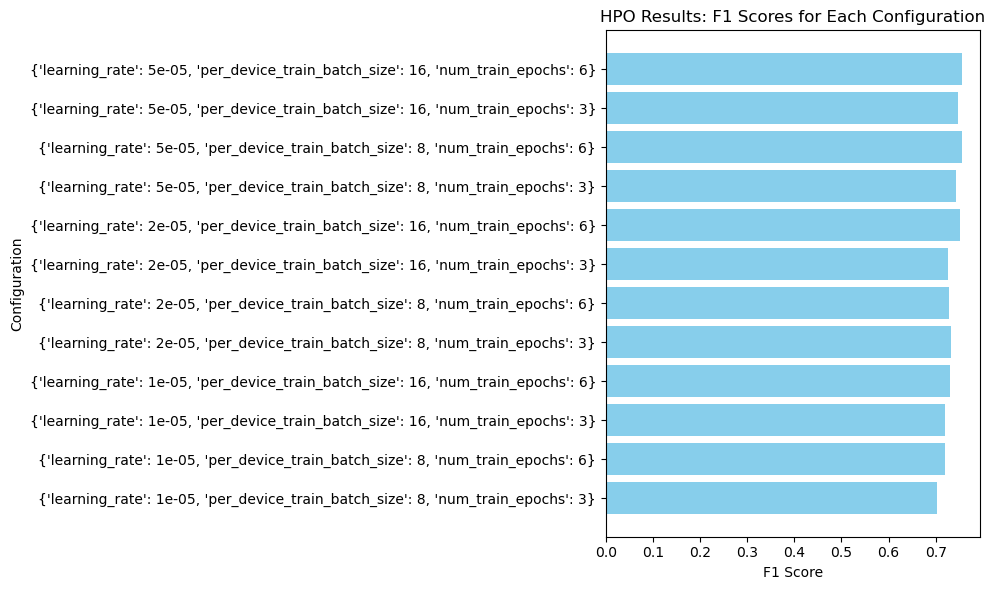

In [13]:
import matplotlib.pyplot as plt

# Extract configurations and corresponding F1 scores
configs = [str(res["config"]) for res in results]
f1_scores = [res["results"].get("eval_overall_f1", 0) for res in results]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(configs, f1_scores, color="skyblue")
plt.xlabel("F1 Score")
plt.ylabel("Configuration")
plt.title("HPO Results: F1 Scores for Each Configuration")
plt.tight_layout()
plt.show()


In [14]:
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=10,
)
from transformers import Trainer
from evaluate import load
import torch

# Load metric for evaluation
metric = load("seqeval")

def compute_metrics(predictions):
    predictions, labels = predictions
    predictions = torch.argmax(torch.tensor(predictions), dim=2)
    
    # Convert predictions and labels to CPU and then to plain Python integers
    predictions = predictions.cpu().numpy()
    
    true_labels = [
        [id_to_label[label] for label in label_seq if label != -100] 
        for label_seq in labels
    ]
    true_predictions = [
        [id_to_label[int(p)] for (p, l) in zip(prediction, label_seq) if l != -100]  # Convert tensor to int
        for prediction, label_seq in zip(predictions, labels)
    ]
    return metric.compute(predictions=true_predictions, references=true_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)


  3%|▎         | 10/378 [00:04<02:19,  2.65it/s]

{'loss': 0.007, 'grad_norm': 2.8474206924438477, 'learning_rate': 4.8677248677248676e-05, 'epoch': 0.16}


  5%|▌         | 20/378 [00:07<02:13,  2.69it/s]

{'loss': 0.0054, 'grad_norm': 1.7116445302963257, 'learning_rate': 4.7354497354497356e-05, 'epoch': 0.32}


  8%|▊         | 30/378 [00:11<02:09,  2.68it/s]

{'loss': 0.0097, 'grad_norm': 0.7677240371704102, 'learning_rate': 4.603174603174603e-05, 'epoch': 0.48}


 11%|█         | 40/378 [00:15<02:05,  2.68it/s]

{'loss': 0.0055, 'grad_norm': 0.7155522108078003, 'learning_rate': 4.470899470899471e-05, 'epoch': 0.63}


 13%|█▎        | 50/378 [00:19<02:00,  2.71it/s]

{'loss': 0.007, 'grad_norm': 0.8631329536437988, 'learning_rate': 4.3386243386243384e-05, 'epoch': 0.79}


 16%|█▌        | 60/378 [00:22<01:58,  2.69it/s]

{'loss': 0.0032, 'grad_norm': 0.27742382884025574, 'learning_rate': 4.2063492063492065e-05, 'epoch': 0.95}


 17%|█▋        | 63/378 [00:24<01:36,  3.26it/s]

{'eval_loss': 0.4677392840385437, 'eval_ADR': {'precision': 0.5702479338842975, 'recall': 0.518796992481203, 'f1': 0.5433070866141733, 'number': 665}, 'eval_DIS': {'precision': 0.23636363636363636, 'recall': 0.22413793103448276, 'f1': 0.23008849557522126, 'number': 58}, 'eval_DRU': {'precision': 0.8930348258706468, 'recall': 0.8975, 'f1': 0.8952618453865338, 'number': 400}, 'eval_SYM': {'precision': 0.3870967741935484, 'recall': 0.24, 'f1': 0.2962962962962963, 'number': 50}, 'eval_overall_precision': 0.666971637694419, 'eval_overall_recall': 0.6214833759590793, 'eval_overall_f1': 0.6434245366284201, 'eval_overall_accuracy': 0.9301238145416227, 'eval_runtime': 1.0968, 'eval_samples_per_second': 114.879, 'eval_steps_per_second': 7.294, 'epoch': 1.0}


 19%|█▊        | 70/378 [00:28<02:17,  2.23it/s]

{'loss': 0.0055, 'grad_norm': 0.1645617038011551, 'learning_rate': 4.074074074074074e-05, 'epoch': 1.11}


 21%|██        | 80/378 [00:32<01:52,  2.66it/s]

{'loss': 0.0057, 'grad_norm': 0.8839696645736694, 'learning_rate': 3.941798941798942e-05, 'epoch': 1.27}


 24%|██▍       | 90/378 [00:35<01:48,  2.66it/s]

{'loss': 0.0057, 'grad_norm': 0.575454592704773, 'learning_rate': 3.809523809523809e-05, 'epoch': 1.43}


 26%|██▋       | 100/378 [00:39<01:44,  2.66it/s]

{'loss': 0.0087, 'grad_norm': 0.5347455143928528, 'learning_rate': 3.677248677248677e-05, 'epoch': 1.59}


 29%|██▉       | 110/378 [00:43<01:41,  2.65it/s]

{'loss': 0.0056, 'grad_norm': 0.6709302067756653, 'learning_rate': 3.5449735449735446e-05, 'epoch': 1.75}


 32%|███▏      | 120/378 [00:47<01:37,  2.65it/s]

{'loss': 0.0165, 'grad_norm': 0.4670187830924988, 'learning_rate': 3.412698412698413e-05, 'epoch': 1.9}


 33%|███▎      | 126/378 [00:50<01:18,  3.22it/s]

{'eval_loss': 0.4366815388202667, 'eval_ADR': {'precision': 0.5555555555555556, 'recall': 0.5488721804511278, 'f1': 0.5521936459909229, 'number': 665}, 'eval_DIS': {'precision': 0.2553191489361702, 'recall': 0.20689655172413793, 'f1': 0.22857142857142854, 'number': 58}, 'eval_DRU': {'precision': 0.925531914893617, 'recall': 0.87, 'f1': 0.8969072164948454, 'number': 400}, 'eval_SYM': {'precision': 0.47368421052631576, 'recall': 0.18, 'f1': 0.2608695652173913, 'number': 50}, 'eval_overall_precision': 0.6678798908098271, 'eval_overall_recall': 0.6257459505541347, 'eval_overall_f1': 0.6461267605633804, 'eval_overall_accuracy': 0.9326923076923077, 'eval_runtime': 1.1288, 'eval_samples_per_second': 111.621, 'eval_steps_per_second': 7.087, 'epoch': 2.0}


 34%|███▍      | 130/378 [00:53<02:26,  1.69it/s]

{'loss': 0.0096, 'grad_norm': 1.1073930263519287, 'learning_rate': 3.280423280423281e-05, 'epoch': 2.06}


 37%|███▋      | 140/378 [00:56<01:30,  2.64it/s]

{'loss': 0.0047, 'grad_norm': 0.03864039480686188, 'learning_rate': 3.148148148148148e-05, 'epoch': 2.22}


 40%|███▉      | 150/378 [01:00<01:24,  2.70it/s]

{'loss': 0.0046, 'grad_norm': 0.2579965889453888, 'learning_rate': 3.0158730158730158e-05, 'epoch': 2.38}


 42%|████▏     | 160/378 [01:04<01:20,  2.72it/s]

{'loss': 0.0059, 'grad_norm': 0.41962823271751404, 'learning_rate': 2.8835978835978838e-05, 'epoch': 2.54}


 45%|████▍     | 170/378 [01:07<01:17,  2.70it/s]

{'loss': 0.0044, 'grad_norm': 0.9325053095817566, 'learning_rate': 2.7513227513227512e-05, 'epoch': 2.7}


 48%|████▊     | 180/378 [01:11<01:13,  2.70it/s]

{'loss': 0.0124, 'grad_norm': 1.3161948919296265, 'learning_rate': 2.6190476190476192e-05, 'epoch': 2.86}


 50%|█████     | 189/378 [01:15<00:58,  3.23it/s]

{'eval_loss': 0.47252610325813293, 'eval_ADR': {'precision': 0.5563798219584569, 'recall': 0.5639097744360902, 'f1': 0.5601194921583271, 'number': 665}, 'eval_DIS': {'precision': 0.18604651162790697, 'recall': 0.13793103448275862, 'f1': 0.15841584158415842, 'number': 58}, 'eval_DRU': {'precision': 0.9017632241813602, 'recall': 0.895, 'f1': 0.8983688833124216, 'number': 400}, 'eval_SYM': {'precision': 0.4444444444444444, 'recall': 0.24, 'f1': 0.3116883116883117, 'number': 50}, 'eval_overall_precision': 0.6599474145486416, 'eval_overall_recall': 0.6419437340153452, 'eval_overall_f1': 0.6508210890233362, 'eval_overall_accuracy': 0.9324288724973656, 'eval_runtime': 1.1221, 'eval_samples_per_second': 112.293, 'eval_steps_per_second': 7.13, 'epoch': 3.0}


 50%|█████     | 190/378 [01:17<03:40,  1.17s/it]

{'loss': 0.0054, 'grad_norm': 0.570457935333252, 'learning_rate': 2.4867724867724866e-05, 'epoch': 3.02}


 53%|█████▎    | 200/378 [01:21<01:11,  2.51it/s]

{'loss': 0.0049, 'grad_norm': 1.3297052383422852, 'learning_rate': 2.3544973544973546e-05, 'epoch': 3.17}


 56%|█████▌    | 210/378 [01:25<01:03,  2.65it/s]

{'loss': 0.0031, 'grad_norm': 0.8151782751083374, 'learning_rate': 2.2222222222222223e-05, 'epoch': 3.33}


 58%|█████▊    | 220/378 [01:29<00:59,  2.66it/s]

{'loss': 0.0107, 'grad_norm': 0.3459611237049103, 'learning_rate': 2.08994708994709e-05, 'epoch': 3.49}


 61%|██████    | 230/378 [01:32<00:55,  2.67it/s]

{'loss': 0.0053, 'grad_norm': 0.7582882642745972, 'learning_rate': 1.9576719576719577e-05, 'epoch': 3.65}


 63%|██████▎   | 240/378 [01:36<00:51,  2.66it/s]

{'loss': 0.0043, 'grad_norm': 0.24035359919071198, 'learning_rate': 1.8253968253968254e-05, 'epoch': 3.81}


 66%|██████▌   | 250/378 [01:40<00:47,  2.67it/s]

{'loss': 0.0021, 'grad_norm': 0.695418119430542, 'learning_rate': 1.693121693121693e-05, 'epoch': 3.97}


 67%|██████▋   | 252/378 [01:42<00:39,  3.23it/s]

{'eval_loss': 0.4674300253391266, 'eval_ADR': {'precision': 0.563265306122449, 'recall': 0.6225563909774436, 'f1': 0.5914285714285713, 'number': 665}, 'eval_DIS': {'precision': 0.20588235294117646, 'recall': 0.1206896551724138, 'f1': 0.15217391304347824, 'number': 58}, 'eval_DRU': {'precision': 0.9075, 'recall': 0.9075, 'f1': 0.9075, 'number': 400}, 'eval_SYM': {'precision': 0.5185185185185185, 'recall': 0.28, 'f1': 0.36363636363636365, 'number': 50}, 'eval_overall_precision': 0.6672240802675585, 'eval_overall_recall': 0.680306905370844, 'eval_overall_f1': 0.6737019839594767, 'eval_overall_accuracy': 0.9342070600632244, 'eval_runtime': 1.1323, 'eval_samples_per_second': 111.277, 'eval_steps_per_second': 7.065, 'epoch': 4.0}


 69%|██████▉   | 260/378 [01:46<00:50,  2.34it/s]

{'loss': 0.0035, 'grad_norm': 0.7936808466911316, 'learning_rate': 1.560846560846561e-05, 'epoch': 4.13}


 71%|███████▏  | 270/378 [01:50<00:40,  2.65it/s]

{'loss': 0.0049, 'grad_norm': 0.5745812058448792, 'learning_rate': 1.4285714285714285e-05, 'epoch': 4.29}


 74%|███████▍  | 280/378 [01:53<00:36,  2.66it/s]

{'loss': 0.0058, 'grad_norm': 0.6288386583328247, 'learning_rate': 1.2962962962962962e-05, 'epoch': 4.44}


 77%|███████▋  | 290/378 [01:57<00:33,  2.65it/s]

{'loss': 0.004, 'grad_norm': 0.4999643862247467, 'learning_rate': 1.164021164021164e-05, 'epoch': 4.6}


 79%|███████▉  | 300/378 [02:01<00:29,  2.63it/s]

{'loss': 0.0059, 'grad_norm': 0.8364145159721375, 'learning_rate': 1.0317460317460318e-05, 'epoch': 4.76}


 82%|████████▏ | 310/378 [02:05<00:25,  2.66it/s]

{'loss': 0.005, 'grad_norm': 0.43622979521751404, 'learning_rate': 8.994708994708995e-06, 'epoch': 4.92}


 83%|████████▎ | 315/378 [02:07<00:19,  3.23it/s]

{'eval_loss': 0.45246511697769165, 'eval_ADR': {'precision': 0.5601604278074866, 'recall': 0.6300751879699248, 'f1': 0.5930644019815994, 'number': 665}, 'eval_DIS': {'precision': 0.18421052631578946, 'recall': 0.1206896551724138, 'f1': 0.14583333333333334, 'number': 58}, 'eval_DRU': {'precision': 0.905, 'recall': 0.905, 'f1': 0.905, 'number': 400}, 'eval_SYM': {'precision': 0.5, 'recall': 0.26, 'f1': 0.34210526315789475, 'number': 50}, 'eval_overall_precision': 0.6608910891089109, 'eval_overall_recall': 0.6828644501278772, 'eval_overall_f1': 0.6716981132075472, 'eval_overall_accuracy': 0.9336801896733403, 'eval_runtime': 1.1251, 'eval_samples_per_second': 111.988, 'eval_steps_per_second': 7.11, 'epoch': 5.0}


 85%|████████▍ | 320/378 [02:11<00:30,  1.89it/s]

{'loss': 0.0077, 'grad_norm': 0.47215354442596436, 'learning_rate': 7.671957671957672e-06, 'epoch': 5.08}


 87%|████████▋ | 330/378 [02:14<00:18,  2.66it/s]

{'loss': 0.0057, 'grad_norm': 1.863453984260559, 'learning_rate': 6.349206349206349e-06, 'epoch': 5.24}


 90%|████████▉ | 340/378 [02:18<00:14,  2.66it/s]

{'loss': 0.0018, 'grad_norm': 0.5348927974700928, 'learning_rate': 5.026455026455026e-06, 'epoch': 5.4}


 93%|█████████▎| 350/378 [02:22<00:10,  2.65it/s]

{'loss': 0.0035, 'grad_norm': 0.20847660303115845, 'learning_rate': 3.7037037037037037e-06, 'epoch': 5.56}


 95%|█████████▌| 360/378 [02:26<00:07,  2.56it/s]

{'loss': 0.0063, 'grad_norm': 0.14769482612609863, 'learning_rate': 2.3809523809523808e-06, 'epoch': 5.71}


 98%|█████████▊| 370/378 [02:29<00:03,  2.63it/s]

{'loss': 0.0045, 'grad_norm': 0.13611827790737152, 'learning_rate': 1.0582010582010582e-06, 'epoch': 5.87}


100%|██████████| 378/378 [02:35<00:00,  3.23it/s]

{'eval_loss': 0.456741064786911, 'eval_ADR': {'precision': 0.5733333333333334, 'recall': 0.5819548872180451, 'f1': 0.5776119402985074, 'number': 665}, 'eval_DIS': {'precision': 0.20833333333333334, 'recall': 0.1724137931034483, 'f1': 0.18867924528301888, 'number': 58}, 'eval_DRU': {'precision': 0.9081885856079405, 'recall': 0.915, 'f1': 0.9115815691158158, 'number': 400}, 'eval_SYM': {'precision': 0.43333333333333335, 'recall': 0.26, 'f1': 0.325, 'number': 50}, 'eval_overall_precision': 0.671280276816609, 'eval_overall_recall': 0.6615515771526002, 'eval_overall_f1': 0.6663804207814512, 'eval_overall_accuracy': 0.9347339304531085, 'eval_runtime': 1.1414, 'eval_samples_per_second': 110.391, 'eval_steps_per_second': 7.009, 'epoch': 6.0}


100%|██████████| 378/378 [02:36<00:00,  2.41it/s]


{'train_runtime': 156.9893, 'train_samples_per_second': 38.143, 'train_steps_per_second': 2.408, 'train_loss': 0.005930585298864614, 'epoch': 6.0}


100%|██████████| 8/8 [00:00<00:00,  8.08it/s]

Evaluation Results: {'eval_loss': 0.4366815388202667, 'eval_ADR': {'precision': 0.5555555555555556, 'recall': 0.5488721804511278, 'f1': 0.5521936459909229, 'number': 665}, 'eval_DIS': {'precision': 0.2553191489361702, 'recall': 0.20689655172413793, 'f1': 0.22857142857142854, 'number': 58}, 'eval_DRU': {'precision': 0.925531914893617, 'recall': 0.87, 'f1': 0.8969072164948454, 'number': 400}, 'eval_SYM': {'precision': 0.47368421052631576, 'recall': 0.18, 'f1': 0.2608695652173913, 'number': 50}, 'eval_overall_precision': 0.6678798908098271, 'eval_overall_recall': 0.6257459505541347, 'eval_overall_f1': 0.6461267605633804, 'eval_overall_accuracy': 0.9326923076923077, 'eval_runtime': 1.2419, 'eval_samples_per_second': 101.458, 'eval_steps_per_second': 6.442, 'epoch': 6.0}
